In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from line import line
from tracker import tracker

%matplotlib inline

## Implementation of helper functions
The following sections contain the implementation of individual functions that will form a pipeline

## Correcting Image distortion
In this section, we will perform and display results of the following steps:
- Undistort image using *undistort_image* function

In [2]:
def get_camera_cal_params():
    # Read in the saved objpoints and imgpoints
    cal_pickle = pickle.load( open( "calibration_params/cal_pickle.p", "rb" ) )
    mtx = cal_pickle["mtx"] 
    dist = cal_pickle["dist"]
    return mtx, dist

def undistort_image(distorted_image):
    mtx, dist = get_camera_cal_params()
    undistorted_image = cv2.undistort(distorted_image, mtx, dist, None, mtx)
    return undistorted_image

In [3]:
print("Undistorting a test image...")
sample_original_image = cv2.imread('./test_images/right_lane11.jpg')

sample_original_image = cv2.cvtColor(sample_original_image, cv2.COLOR_BGR2RGB)
sample_undistorted_image = undistort_image(sample_original_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sample_original_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(sample_undistorted_image)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., hspace=2)

Undistorting a test image...


## Applying color and gradient threshold
In this section, we will define methods to apply color and gradient threshold and display the result

In [4]:
#TODO: Seperate sobel transform and color transform functions
def get_s_channel_hsv(img):
    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    s_channel = hsv[:,:,1]
    return s_channel

def get_v_channel_hsv(img):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    return v_channel

def get_s_channel_hls(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return s_channel

def get_l_channel_hls(img):
    # Convert to HLS color space and separate the l channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    return l_channel

def get_scaled_sobelx(s_channel):
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    return scaled_sobel

def get_scaled_sobely(s_channel):
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    return scaled_sobel
    
def get_thresholded_x_gradient_binary(scaled_sobel, sx_thresh):
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary

def get_thresholded_y_gradient_binary(scaled_sobel, sy_thresh):
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= sy_thresh[0]) & (scaled_sobel <= sy_thresh[1])] = 1
    return sybinary

def get_combined_gradient_binary(sx_binary, sy_binary):
    binary = np.zeros_like(sx_binary)
    binary[(sx_binary ==1) & (sy_binary == 1)] = 1
    return binary

def get_color_channel_thresholded_binary(channel, thresh):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def get_combined_color_thresholded_binary(channel1, channel2):
    binary = np.zeros_like(channel1)
    binary[(channel1 ==1) | (channel2 == 1)] = 1
    return binary

def get_overall_combined_binary(binary1, binary2):
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 255
    return combined_binary

def apply_color_and_gradient_threshold(img, l_thresh_hls=(200,255), sx_thresh=(20,255)):    
    s_channel_hls = get_s_channel_hls(img)
    l_channel_hls = get_l_channel_hls(img)
    
    scaled_sobel = get_scaled_sobelx(s_channel_hls)
    sx_binary = get_thresholded_x_gradient_binary(scaled_sobel, sx_thresh)  
        
    l_binary_hls = get_color_channel_thresholded_binary(l_channel_hls, l_thresh_hls)
        
    overall_combined_binary = get_overall_combined_binary(sx_binary, l_binary_hls)
    
    return overall_combined_binary

thresholded_combined_binary = apply_color_and_gradient_threshold(sample_undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(sample_undistorted_image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(thresholded_combined_binary, cmap='gray')
ax2.set_title('Combined', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform
In this section, we will 
- Define and display source and destination points for perspective transform
- Perform perspective transform on the defined region using *transform_image* function
- Display results for a sample image

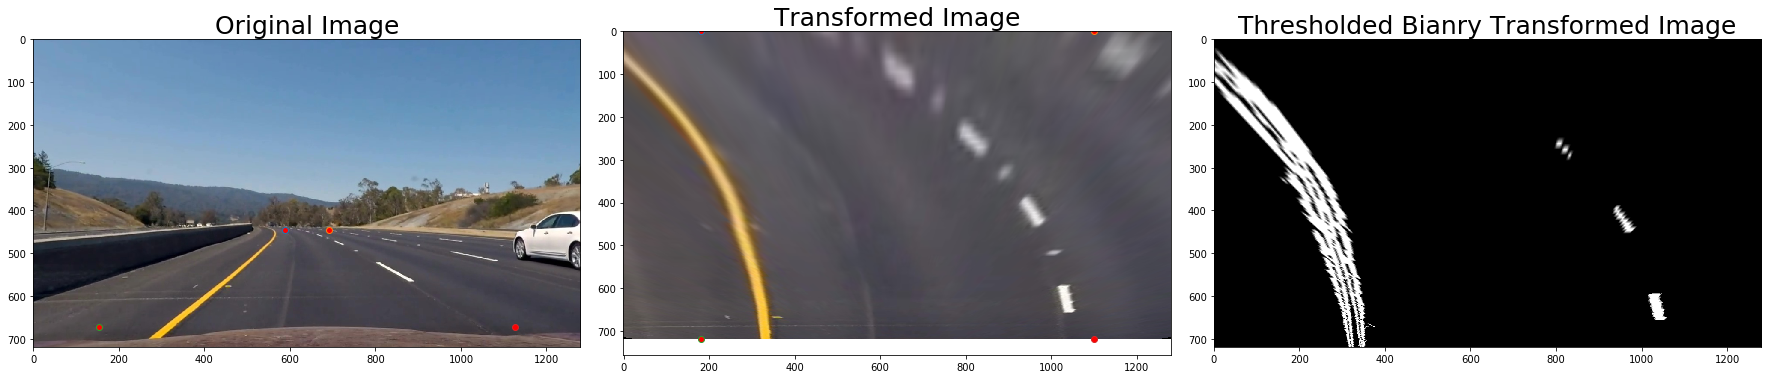

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def transform_image(img, srcpoints, destpoints):
    # Grab the image shape
    # TODO - Check if the shape of undistored image is the same as distorted image
    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcpoints, destpoints)
    Minv = cv2.getPerspectiveTransform(destpoints, srcpoints)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped,M, Minv

def get_perspective_transform_locations(img_shape):
    img_width = img_shape[1]
    img_height = img_shape[0]
    offset = img_height * .25
    
    bot_width = .76 # multiplication factor for the bottom width of source trapezoid
    mid_width = .08 # multiplication factor for the top width of source trapezoid
    height_pct = .62 # multiplication factor for the trapezoid height
    bottom_trim = .935 # this much percent will be the offset from the bottom to avoid car hood

    x1 = img_width * (.5 - mid_width/2)
    y1 = img_height * height_pct
    p1 = np.array((x1,y1))
    
    x2 = img_width * (.5 + mid_width/2)
    y2 = img_height * height_pct
    p2 = np.array((x2,y2))
    
    x3 = img_width * (.5 - bot_width/2)
    y3 = img_height * bottom_trim
    p3 = np.array((x3,y3))
    
    x4 = img_width * (.5 + bot_width/2)
    y4 = img_height * bottom_trim
    p4 = np.array((x4,y4))
    
    srcpoints = np.float32([p1, p2, p3, p4])
    
    p5 = np.array((offset,0))
    p6 = np.array((img_width - offset , 0))
    p7 = np.array((offset, img_height))
    p8 = np.array((img_width - offset , img_height))
    
    destpoints = np.float32([p5, p6, p7, p8])
    
    return srcpoints, destpoints    
    

srcpoints, destpoints = get_perspective_transform_locations(sample_undistorted_image.shape)

transformed_image, perspective_M, Minv = transform_image(sample_undistorted_image, srcpoints, destpoints)
binary_thresholded_transformed_image, perspective_M, Minv = transform_image(thresholded_combined_binary, srcpoints, destpoints)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

#ax1.imshow(thresholded_color_binary_image)
ax1.imshow(sample_undistorted_image)
ax1.set_title('Original Image', fontsize=25)
ax1.plot(srcpoints[0][0],srcpoints[0][1], 'o', markerfacecolor='red')
ax1.plot(srcpoints[1][0],srcpoints[1][1], 'o', markerfacecolor='red')
ax1.plot(srcpoints[2][0],srcpoints[2][1], 'o', markerfacecolor='red')
ax1.plot(srcpoints[3][0],srcpoints[3][1], 'o', markerfacecolor='red')

ax2.imshow(transformed_image)
ax2.set_title('Transformed Image', fontsize=25)
ax2.plot(destpoints[0][0],destpoints[0][1], 'o', markerfacecolor='red')
ax2.plot(destpoints[1][0],destpoints[1][1], 'o', markerfacecolor='red')
ax2.plot(destpoints[2][0],destpoints[2][1], 'o', markerfacecolor='red')
ax2.plot(destpoints[3][0],destpoints[3][1], 'o', markerfacecolor='red')

ax3.imshow(binary_thresholded_transformed_image, cmap='gray')
ax3.set_title('Thresholded Bianry Transformed Image', fontsize=25)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Fitting lane lines
In this section we will fit the lane lines to the binary warped perspective transformed image above and retrieve the pixel positions in the image for the same.
I have implemented sliding windows algorithm with *stack_sliding_windows* function. This function accepts
- binary warped image
- leftx_base and rightx_base, which are the most probable positions of the lane lines in the image
- nwindows, number of sliding windows we want
- margin, the buffer region around the sliding window center, where we will search for the lane pixels
- minpix, minumum number of detected lane pixels to cause the window to slide in either directions

Then we will display how the fitted line looks on a binary warped image and original undistorted image

Received bases: leftx_base:306, rightx_base:1034
is_consistent returned  True
consistent leftx base is 306
consistent rightx base is 1034


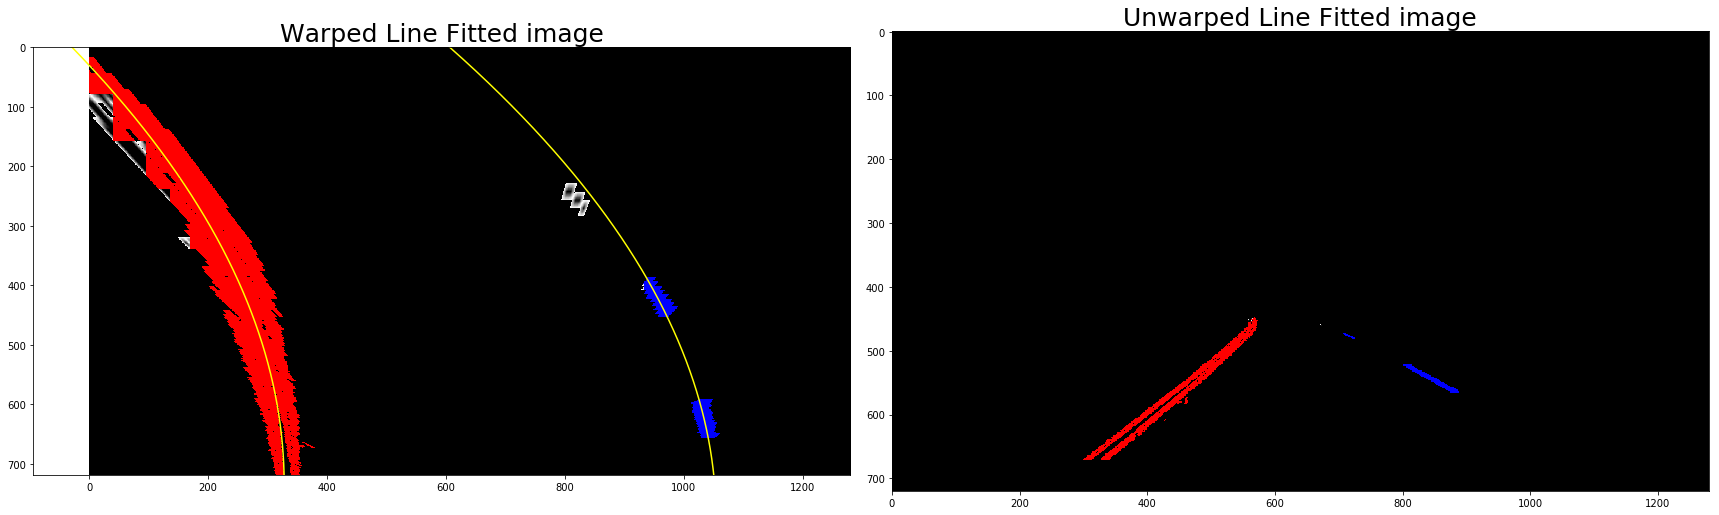

In [6]:
def get_lane_width_pixels(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    leftx_base, rightx_base = get_lane_positions(histogram)
    lane_width = rightx_base - leftx_base
    #print("Lane width in pixels:{}".format(lane_width))
    return lane_width

def get_lane_positions(histogram):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # point along the width where the histogram peak occurs in the left half
    leftx_base = np.argmax(histogram[:midpoint])
    # point along x axis where the peak occurs in the right half
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print("midpoint:{}, leftx_base:{}, rightx_base{}".format(midpoint, leftx_base, rightx_base))
    return leftx_base, rightx_base

def smoothen_last_n(xlist, smooth_factor=15):
    if len(xlist) > smooth_factor:
        # take an average over last n
        x_avg = np.average(xlist[-smooth_factor:])
        # replace last n with average value
        xlist[-smooth_factor] = x_avg
    return xlist

def stack_sliding_windows(out_img, leftx_base, rightx_base, nwindows = 9, margin = 100, minpix = 50):
        """This function will accept the binary warped image and starting window positions for left and right
        lanes. It'll then search the remaining lane line pixels and return a fitted polynomial for each
        lane"""

        # Set height of windows
        window_height = np.int(out_img.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = out_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        # e.g., these positions will slightly move to the right as the lane curves right and vice versa
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            # Identify the top and bottom y co-ordinates for the sliding window
            # don't need to do this separately because both left and right windows have same y co-ordinates
            win_y_low = out_img.shape[0] - (window+1)*window_height #top y co-ordinate for window
            win_y_high = out_img.shape[0] - window*window_height #bottom y co-ordinate for windwo

            # Identify the left and right co-ordinates for the sliding window for left lane
            win_xleft_low = leftx_current - margin # left peak of histogram minus the buffer space on left
            win_xleft_high = leftx_current + margin # left peak of histogram plus the buffer space on right

            # Identify the left and right co-ordinates for the sliding window for right lane
            win_xright_low = rightx_current - margin # right peak of histogram minus the buffer space on left
            win_xright_high = rightx_current + margin # right peak of histogram plus the buffer space on right

            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

            # fill the left rectangle (sliding windows)
            #polys_left_lane = np.array([[win_xleft_low, win_y_low],[win_xleft_high, win_y_low],[win_xleft_high,win_y_high], [win_xleft_low, win_y_high]])
            #cv2.fillPoly(out_img,[polys_left_lane],(127,0,0))

            # fill the right rectangle (sliding windows)
            #polys_right_lane = np.array([[win_xright_low, win_y_low],[win_xright_high, win_y_low],[win_xright_high,win_y_high], [win_xright_low, win_y_high]])
            #cv2.fillPoly(out_img,[polys_right_lane],(0,0,127))

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        # this will contain all the indices corresponding to lane pixels
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = np.array(nonzerox[left_lane_inds])
        lefty = np.array(nonzeroy[left_lane_inds])
        rightx = np.array(nonzerox[right_lane_inds])
        righty = np.array(nonzeroy[right_lane_inds])
        
        
        # Color the left lane pixels red
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        # Color the right lane pixels blue
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        return leftx, lefty, rightx, righty

def fit_lane_lines(img, left_lineobj, right_lineobj):
    binary_warped = np.copy(img)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Take a histogram of the bottom half of the warped image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    leftx_base, rightx_base = get_lane_positions(histogram)
    #plt.plot(histogram)
    leftx, lefty, rightx, righty = stack_sliding_windows(out_img, leftx_base, rightx_base)
    
    # Smoothen these with smoothing factor
    leftx = smoothen_last_n(leftx)
    rightx = smoothen_last_n(rightx)
    
    # get the fitted polynomial from x and y
    left_fit = left_lineobj.fit(leftx, lefty)
    right_fit = right_lineobj.fit(rightx, righty)

    return out_img, left_fit, right_fit, leftx_base, rightx_base

def get_side_pos(center_diff):
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    return side_pos    


def get_vehicle_position(left_fitx, right_fitx):
    """
    Return the x co-ordinate of the center of the lane
    using the bottom of the lane line markers
    """
    
    #print(left_fitx[-1])
    #print(right_fitx[-1])
    camera_center = (left_fitx[-1] + right_fitx[-1]) /2
    center_diff = (camera_center - binary_warped.shape[1]/2) * pixels_to_meters_x(lane_width)
    side_pos = get_side_pos(center_diff)
    return center_diff, side_pos


def pixels_to_meters_y(binary_warped):
    return 30.0/(binary_warped.shape[0]) # meters per pixel in y dimension


def pixels_to_meters_x(lane_width):
    return 3.7/lane_width # meters per pixel in x dimension

# Begin execution of above functions here:
left_lineobj = line() 
right_lineobj = line()
lanetracker = tracker()

binary_warped = np.copy(binary_thresholded_transformed_image)

# Lane width in pixel space
lane_width = get_lane_width_pixels(binary_warped)

# Fit the lane lines to binary warped image
out_img, left_fit, right_fit, leftx_base, rightx_base = fit_lane_lines(binary_warped, left_lineobj, right_lineobj)

if lanetracker.is_consistent(leftx_base, rightx_base):
    print("consistent leftx base is", leftx_base)
    print("consistent rightx base is", rightx_base)
    lanetracker.track(left_fit, right_fit, leftx_base, rightx_base)
else:
    print("inconsistent lane width. leftx rightx", leftx_base, rightx)
    left_fit, right_fit = lanetracker.get_best_fit()

# Get the pixel positions for the fitted lines
# Importat! This is the single most important output that will be used in further processing.
left_fitx = left_lineobj.get_fitted_curve_pixel_positions(out_img.shape, left_fit)
right_fitx = right_lineobj.get_fitted_curve_pixel_positions(out_img.shape, right_fit)

ploty = np.linspace(0, out_img.shape[0]-1, num=out_img.shape[0])
# Get the camera center
center_diff, side_pos = get_vehicle_position(left_fitx, right_fitx)
#print("center_diff:{}, side_pos:{}".format(center_diff, side_pos))

# Display the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(out_img)
ax1.set_title('Warped Line Fitted image', fontsize=25)
# Draw the yellow colored fitted lines
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')

img_size = (out_img.shape[1], out_img.shape[0])
unwarped = cv2.warpPerspective(out_img, Minv, img_size, flags=cv2.INTER_NEAREST)
ax2.imshow(unwarped)
ax2.set_title('Unwarped Line Fitted image', fontsize=25)

## Calculating the curve radius
In the following section, we will calculate the curve radius in both, pixel space and in meters.

In [7]:
def get_curverad(binary_warped, lineobj):
    lane_width = get_lane_width_pixels(binary_warped)
    xm_per_pix = pixels_to_meters_x(lane_width)
    ym_per_pix = pixels_to_meters_y(binary_warped)
    curverad = lineobj.get_curverad(binary_warped.shape[0],xm_per_pix, ym_per_pix)
    return curverad

curverad = get_curverad(binary_warped, right_lineobj)
print("Radius in real world space: left curvature = {} m".format(curverad))

Radius in real world space: left curvature = 239.82972202556675 m


## Projecting lane lines on undistorted image
We will do a visualization here to display how the lane lines look on original undistorted image and highlight the entire lane using *project_lanes_on_original_image* function

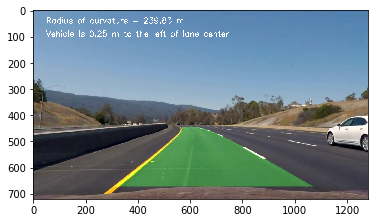

In [8]:
def project_lanes_on_original_image(binary_warped, undistorted_image, Minv, left_fitx, right_fitx):
    #print("Shape of binary warped:{}".format(binary_warped.shape))
    #print("Shape of undistorted_image:{}".format(undistorted_image.shape))
    # Create an image to draw the lines on
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return result

def write_radii_center_pos(lane_projected_image, curverad, center_diff, side_pos):
    cv2.putText(lane_projected_image, 'Radius of curvature = '+str(round(curverad, 3))+' m', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    #cv2.putText(lane_projected_image, 'Radius of curvature = '+str(round(center_diff, 3))+' m', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(lane_projected_image,'Vehicle is '+str(abs(round(center_diff, 3)))+' m to the '+side_pos+' of lane center', (50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2)

lane_projected_image = project_lanes_on_original_image(binary_warped, sample_undistorted_image, Minv,left_fitx, right_fitx)
center_diff, side_pos = get_vehicle_position(left_fitx, right_fitx)
write_radii_center_pos(lane_projected_image, curverad, center_diff, side_pos)
plt.imshow(lane_projected_image)

## Pipeline

 ## Test on video:
**Run the pipeline on video here**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Image processing pipeline goes here
**Steps**


In [10]:
left_lineobj = line()
right_lineobj = line()
lanetracker = tracker()

def get_binary_warped(img):
    undistorted_image = undistort_image(img)
    thresholded_combined_binary = apply_color_and_gradient_threshold(undistorted_image)
    binary_thresholded_transformed_image, perspective_M, Minv = transform_image(thresholded_combined_binary, srcpoints, destpoints)
    return binary_thresholded_transformed_image, perspective_M, Minv

def lane_marker_pipeline(undistorted_image):
    lane_projected_image = undistorted_image
   
    # step1: Get binary warped image in which lanes are properly highlighted
    binary_warped, perspective_M, perspective_Minv = get_binary_warped(undistorted_image)
    
    # step2: Fit lane lines
    out_img, left_fit, right_fit, leftx_base, rightx_base = fit_lane_lines(binary_warped, left_lineobj, right_lineobj)
    if (len(left_fit) > 0) and (len(right_fit) > 0) :
        if lanetracker.is_consistent(leftx_base, rightx_base):
            print("consistent leftx base is", leftx_base)
            print("consistent rightx base is", rightx_base)
            lanetracker.track(left_fit, right_fit, leftx_base, rightx_base)
        else:
            left_fit, right_fit = lanetracker.get_best_fit()
            print("inconsistent left_fit",left_fit)
            print("inconsistent right_fit",right_fit)
        left_fitx = left_lineobj.get_fitted_curve_pixel_positions(binary_warped.shape, left_fit)
        right_fitx = right_lineobj.get_fitted_curve_pixel_positions(binary_warped.shape, right_fit)
        lane_projected_image = project_lanes_on_original_image(binary_warped, undistorted_image, Minv,left_fitx, right_fitx)
        
        # step3: Calculate radii
        lane_width = get_lane_width_pixels(binary_warped)
        xm_per_pix = pixels_to_meters_x(lane_width)
        ym_per_pix = pixels_to_meters_y(binary_warped)
        curverad = left_lineobj.get_curverad(out_img.shape[0],xm_per_pix, ym_per_pix)
        
        # write these values on the image
        center_diff, side_pos = get_vehicle_position(left_fitx, right_fitx)
        write_radii_center_pos(lane_projected_image, curverad, center_diff, side_pos)
        
    else:
        lane_projected_image = undistorted_image
    
    
    return lane_projected_image

In [11]:

lane_marked_output = 'lane_marked_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(lane_marker_pipeline)
%time out_clip.write_videofile(lane_marked_output, audio=False)

Received bases: leftx_base:338, rightx_base:1011
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1011
[MoviePy] >>>> Building video lane_marked_output.mp4
[MoviePy] Writing video lane_marked_output.mp4


  0%|          | 1/1261 [00:00<06:46,  3.10it/s]

Received bases: leftx_base:338, rightx_base:1011
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1011


  0%|          | 2/1261 [00:00<06:43,  3.12it/s]

Received bases: leftx_base:340, rightx_base:1068
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1068


  0%|          | 3/1261 [00:00<06:39,  3.15it/s]

Received bases: leftx_base:337, rightx_base:1018
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1018


  0%|          | 4/1261 [00:01<06:29,  3.22it/s]

Received bases: leftx_base:340, rightx_base:1073
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1073


  0%|          | 5/1261 [00:01<06:23,  3.28it/s]

Received bases: leftx_base:340, rightx_base:1029
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1029


  0%|          | 6/1261 [00:01<06:18,  3.32it/s]

Received bases: leftx_base:342, rightx_base:1032
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1032


  1%|          | 7/1261 [00:02<06:15,  3.34it/s]

Received bases: leftx_base:343, rightx_base:1039
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1039


  1%|          | 8/1261 [00:02<06:28,  3.22it/s]

Received bases: leftx_base:346, rightx_base:1042
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1042


  1%|          | 9/1261 [00:02<06:24,  3.25it/s]

Received bases: leftx_base:333, rightx_base:1046
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1046


  1%|          | 10/1261 [00:03<06:20,  3.28it/s]

Received bases: leftx_base:341, rightx_base:1052
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1052


  1%|          | 11/1261 [00:03<06:43,  3.10it/s]

Received bases: leftx_base:343, rightx_base:1058
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1058


  1%|          | 12/1261 [00:03<07:46,  2.68it/s]

Received bases: leftx_base:339, rightx_base:1069
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1069


  1%|          | 13/1261 [00:04<08:31,  2.44it/s]

Received bases: leftx_base:329, rightx_base:1065
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1065


  1%|          | 14/1261 [00:04<08:14,  2.52it/s]

Received bases: leftx_base:335, rightx_base:993
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 993


  1%|          | 15/1261 [00:05<07:35,  2.74it/s]

Received bases: leftx_base:336, rightx_base:989
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 989


  1%|▏         | 16/1261 [00:05<07:08,  2.90it/s]

Received bases: leftx_base:342, rightx_base:1067
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1067


  1%|▏         | 17/1261 [00:05<07:31,  2.76it/s]

Received bases: leftx_base:344, rightx_base:998
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 998


  1%|▏         | 18/1261 [00:06<07:30,  2.76it/s]

Received bases: leftx_base:303, rightx_base:1000
is_consistent returned  True
consistent leftx base is 303
consistent rightx base is 1000


  2%|▏         | 19/1261 [00:06<07:14,  2.86it/s]

Received bases: leftx_base:313, rightx_base:1012
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1012


  2%|▏         | 20/1261 [00:06<06:46,  3.05it/s]

Received bases: leftx_base:310, rightx_base:1018
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1018


  2%|▏         | 21/1261 [00:07<06:29,  3.18it/s]

Received bases: leftx_base:308, rightx_base:1029
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1029


  2%|▏         | 22/1261 [00:07<06:53,  2.99it/s]

Received bases: leftx_base:304, rightx_base:1035
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1035


  2%|▏         | 23/1261 [00:07<06:55,  2.98it/s]

Received bases: leftx_base:295, rightx_base:1044
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1044


  2%|▏         | 24/1261 [00:08<06:56,  2.97it/s]

Received bases: leftx_base:307, rightx_base:1047
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1047


  2%|▏         | 25/1261 [00:08<06:50,  3.01it/s]

Received bases: leftx_base:303, rightx_base:1055
is_consistent returned  True
consistent leftx base is 303
consistent rightx base is 1055


  2%|▏         | 26/1261 [00:08<07:09,  2.88it/s]

Received bases: leftx_base:302, rightx_base:1061
is_consistent returned  True
consistent leftx base is 302
consistent rightx base is 1061


  2%|▏         | 27/1261 [00:09<07:08,  2.88it/s]

Received bases: leftx_base:306, rightx_base:1064
is_consistent returned  True
consistent leftx base is 306
consistent rightx base is 1064


  2%|▏         | 28/1261 [00:09<07:06,  2.89it/s]

Received bases: leftx_base:303, rightx_base:1070
is_consistent returned  True
consistent leftx base is 303
consistent rightx base is 1070


  2%|▏         | 29/1261 [00:09<07:05,  2.89it/s]

Received bases: leftx_base:294, rightx_base:1014
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1014


  2%|▏         | 30/1261 [00:10<07:12,  2.85it/s]

Received bases: leftx_base:303, rightx_base:1016
is_consistent returned  True
consistent leftx base is 303
consistent rightx base is 1016


  2%|▏         | 31/1261 [00:10<06:49,  3.00it/s]

Received bases: leftx_base:318, rightx_base:1018
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1018


  3%|▎         | 32/1261 [00:10<06:30,  3.15it/s]

Received bases: leftx_base:323, rightx_base:1021
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1021


  3%|▎         | 33/1261 [00:11<06:17,  3.25it/s]

Received bases: leftx_base:323, rightx_base:1031
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1031


  3%|▎         | 34/1261 [00:11<06:03,  3.37it/s]

Received bases: leftx_base:324, rightx_base:1037
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1037


  3%|▎         | 35/1261 [00:11<05:54,  3.46it/s]

Received bases: leftx_base:325, rightx_base:1042
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1042


  3%|▎         | 36/1261 [00:11<05:50,  3.50it/s]

Received bases: leftx_base:329, rightx_base:1043
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1043


  3%|▎         | 37/1261 [00:12<06:07,  3.33it/s]

Received bases: leftx_base:329, rightx_base:1045
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1045


  3%|▎         | 38/1261 [00:12<06:23,  3.19it/s]

Received bases: leftx_base:331, rightx_base:1050
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1050


  3%|▎         | 39/1261 [00:12<06:36,  3.08it/s]

Received bases: leftx_base:332, rightx_base:1050
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1050


  3%|▎         | 40/1261 [00:13<06:46,  3.01it/s]

Received bases: leftx_base:332, rightx_base:1054
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1054


  3%|▎         | 41/1261 [00:13<06:45,  3.01it/s]

Received bases: leftx_base:334, rightx_base:1057
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1057


  3%|▎         | 42/1261 [00:13<06:28,  3.14it/s]

Received bases: leftx_base:336, rightx_base:1065
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1065


  3%|▎         | 43/1261 [00:14<06:19,  3.21it/s]

Received bases: leftx_base:336, rightx_base:1005
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1005


  3%|▎         | 44/1261 [00:14<06:10,  3.28it/s]

Received bases: leftx_base:332, rightx_base:1017
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1017


  4%|▎         | 45/1261 [00:14<06:00,  3.37it/s]

Received bases: leftx_base:332, rightx_base:1026
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1026


  4%|▎         | 46/1261 [00:14<05:54,  3.43it/s]

Received bases: leftx_base:334, rightx_base:1031
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1031


  4%|▎         | 47/1261 [00:15<05:53,  3.43it/s]

Received bases: leftx_base:333, rightx_base:1038
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1038


  4%|▍         | 48/1261 [00:15<05:51,  3.45it/s]

Received bases: leftx_base:335, rightx_base:1041
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1041


  4%|▍         | 49/1261 [00:15<05:50,  3.45it/s]

Received bases: leftx_base:334, rightx_base:1054
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1054


  4%|▍         | 50/1261 [00:16<05:50,  3.45it/s]

Received bases: leftx_base:335, rightx_base:1058
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1058


  4%|▍         | 51/1261 [00:16<05:49,  3.47it/s]

Received bases: leftx_base:335, rightx_base:1059
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1059


  4%|▍         | 52/1261 [00:16<05:47,  3.48it/s]

Received bases: leftx_base:336, rightx_base:1058
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1058


  4%|▍         | 53/1261 [00:17<05:49,  3.46it/s]

Received bases: leftx_base:336, rightx_base:1058
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1058


  4%|▍         | 54/1261 [00:17<05:49,  3.45it/s]

Received bases: leftx_base:331, rightx_base:1061
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1061


  4%|▍         | 55/1261 [00:17<05:50,  3.44it/s]

Received bases: leftx_base:305, rightx_base:996
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 996


  4%|▍         | 56/1261 [00:17<05:48,  3.46it/s]

Received bases: leftx_base:279, rightx_base:1003
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1003


  5%|▍         | 57/1261 [00:18<05:50,  3.44it/s]

Received bases: leftx_base:281, rightx_base:1011
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1011


  5%|▍         | 58/1261 [00:18<05:46,  3.47it/s]

Received bases: leftx_base:280, rightx_base:1018
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1018


  5%|▍         | 59/1261 [00:18<05:43,  3.49it/s]

Received bases: leftx_base:300, rightx_base:1019
is_consistent returned  True
consistent leftx base is 300
consistent rightx base is 1019


  5%|▍         | 60/1261 [00:19<05:45,  3.48it/s]

Received bases: leftx_base:309, rightx_base:1020
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1020


  5%|▍         | 61/1261 [00:19<05:48,  3.44it/s]

Received bases: leftx_base:317, rightx_base:1024
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1024


  5%|▍         | 62/1261 [00:19<05:46,  3.46it/s]

Received bases: leftx_base:326, rightx_base:1029
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1029


  5%|▍         | 63/1261 [00:19<05:47,  3.45it/s]

Received bases: leftx_base:324, rightx_base:1035
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1035


  5%|▌         | 64/1261 [00:20<05:45,  3.47it/s]

Received bases: leftx_base:323, rightx_base:1039
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1039


  5%|▌         | 65/1261 [00:20<05:47,  3.44it/s]

Received bases: leftx_base:310, rightx_base:1047
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1047


  5%|▌         | 66/1261 [00:20<05:46,  3.45it/s]

Received bases: leftx_base:307, rightx_base:1047
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1047


  5%|▌         | 67/1261 [00:21<05:47,  3.44it/s]

Received bases: leftx_base:308, rightx_base:974
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 974


  5%|▌         | 68/1261 [00:21<05:47,  3.44it/s]

Received bases: leftx_base:307, rightx_base:983
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 983


  5%|▌         | 69/1261 [00:21<05:44,  3.46it/s]

Received bases: leftx_base:320, rightx_base:987
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 987


  6%|▌         | 70/1261 [00:21<05:43,  3.47it/s]

Received bases: leftx_base:317, rightx_base:997
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 997


  6%|▌         | 71/1261 [00:22<05:41,  3.48it/s]

Received bases: leftx_base:319, rightx_base:1002
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1002


  6%|▌         | 72/1261 [00:22<05:41,  3.48it/s]

Received bases: leftx_base:317, rightx_base:1011
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1011


  6%|▌         | 73/1261 [00:22<05:40,  3.49it/s]

Received bases: leftx_base:317, rightx_base:1015
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1015


  6%|▌         | 74/1261 [00:23<05:49,  3.40it/s]

Received bases: leftx_base:316, rightx_base:1022
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1022


  6%|▌         | 75/1261 [00:23<05:50,  3.38it/s]

Received bases: leftx_base:309, rightx_base:1029
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1029


  6%|▌         | 76/1261 [00:23<05:53,  3.35it/s]

Received bases: leftx_base:315, rightx_base:1033
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1033


  6%|▌         | 77/1261 [00:23<05:52,  3.36it/s]

Received bases: leftx_base:286, rightx_base:1034
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1034


  6%|▌         | 78/1261 [00:24<05:52,  3.36it/s]

Received bases: leftx_base:281, rightx_base:976
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 976


  6%|▋         | 79/1261 [00:24<05:50,  3.37it/s]

Received bases: leftx_base:289, rightx_base:985
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 985


  6%|▋         | 80/1261 [00:24<05:49,  3.38it/s]

Received bases: leftx_base:271, rightx_base:993
is_consistent returned  True
consistent leftx base is 271
consistent rightx base is 993


  6%|▋         | 81/1261 [00:25<05:48,  3.39it/s]

Received bases: leftx_base:285, rightx_base:996
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 996


  7%|▋         | 82/1261 [00:25<05:49,  3.37it/s]

Received bases: leftx_base:285, rightx_base:1002
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1002


  7%|▋         | 83/1261 [00:25<05:53,  3.33it/s]

Received bases: leftx_base:283, rightx_base:1012
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1012


  7%|▋         | 84/1261 [00:26<06:07,  3.20it/s]

Received bases: leftx_base:273, rightx_base:1020
is_consistent returned  True
consistent leftx base is 273
consistent rightx base is 1020


  7%|▋         | 85/1261 [00:26<06:09,  3.18it/s]

Received bases: leftx_base:280, rightx_base:1025
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1025


  7%|▋         | 86/1261 [00:26<06:06,  3.21it/s]

Received bases: leftx_base:277, rightx_base:1025
is_consistent returned  True
consistent leftx base is 277
consistent rightx base is 1025


  7%|▋         | 87/1261 [00:27<06:09,  3.18it/s]

Received bases: leftx_base:295, rightx_base:1024
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1024


  7%|▋         | 88/1261 [00:27<06:10,  3.16it/s]

Received bases: leftx_base:296, rightx_base:1024
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1024


  7%|▋         | 89/1261 [00:27<06:09,  3.17it/s]

Received bases: leftx_base:296, rightx_base:1027
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1027


  7%|▋         | 90/1261 [00:28<06:07,  3.19it/s]

Received bases: leftx_base:301, rightx_base:1031
is_consistent returned  True
consistent leftx base is 301
consistent rightx base is 1031


  7%|▋         | 91/1261 [00:28<06:02,  3.23it/s]

Received bases: leftx_base:302, rightx_base:1036
is_consistent returned  True
consistent leftx base is 302
consistent rightx base is 1036


  7%|▋         | 92/1261 [00:28<06:06,  3.19it/s]

Received bases: leftx_base:304, rightx_base:976
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 976


  7%|▋         | 93/1261 [00:28<05:56,  3.27it/s]

Received bases: leftx_base:305, rightx_base:981
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 981


  7%|▋         | 94/1261 [00:29<05:55,  3.28it/s]

Received bases: leftx_base:306, rightx_base:983
is_consistent returned  True
consistent leftx base is 306
consistent rightx base is 983


  8%|▊         | 95/1261 [00:29<05:52,  3.31it/s]

Received bases: leftx_base:305, rightx_base:992
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 992


  8%|▊         | 96/1261 [00:29<05:53,  3.30it/s]

Received bases: leftx_base:311, rightx_base:997
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 997


  8%|▊         | 97/1261 [00:30<05:52,  3.30it/s]

Received bases: leftx_base:307, rightx_base:1002
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1002


  8%|▊         | 98/1261 [00:30<05:51,  3.31it/s]

Received bases: leftx_base:306, rightx_base:1011
is_consistent returned  True
consistent leftx base is 306
consistent rightx base is 1011


  8%|▊         | 99/1261 [00:30<05:57,  3.25it/s]

Received bases: leftx_base:309, rightx_base:1019
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1019


  8%|▊         | 100/1261 [00:31<05:56,  3.26it/s]

Received bases: leftx_base:309, rightx_base:1027
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1027


  8%|▊         | 101/1261 [00:31<05:57,  3.24it/s]

Received bases: leftx_base:311, rightx_base:1026
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 1026


  8%|▊         | 102/1261 [00:31<05:52,  3.29it/s]

Received bases: leftx_base:312, rightx_base:1023
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1023


  8%|▊         | 103/1261 [00:31<05:48,  3.32it/s]

Received bases: leftx_base:313, rightx_base:1035
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1035


  8%|▊         | 104/1261 [00:32<05:48,  3.32it/s]

Received bases: leftx_base:314, rightx_base:1030
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1030


  8%|▊         | 105/1261 [00:32<05:57,  3.23it/s]

Received bases: leftx_base:313, rightx_base:995
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 995


  8%|▊         | 106/1261 [00:32<05:58,  3.23it/s]

Received bases: leftx_base:303, rightx_base:1004
is_consistent returned  True
consistent leftx base is 303
consistent rightx base is 1004


  8%|▊         | 107/1261 [00:33<06:01,  3.19it/s]

Received bases: leftx_base:314, rightx_base:1015
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1015


  9%|▊         | 108/1261 [00:33<05:54,  3.26it/s]

Received bases: leftx_base:313, rightx_base:1016
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1016


  9%|▊         | 109/1261 [00:33<05:57,  3.22it/s]

Received bases: leftx_base:316, rightx_base:1023
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1023


  9%|▊         | 110/1261 [00:34<05:55,  3.24it/s]

Received bases: leftx_base:317, rightx_base:1025
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1025


  9%|▉         | 111/1261 [00:34<05:58,  3.21it/s]

Received bases: leftx_base:318, rightx_base:1029
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1029


  9%|▉         | 112/1261 [00:34<06:04,  3.15it/s]

Received bases: leftx_base:316, rightx_base:1045
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1045


  9%|▉         | 113/1261 [00:35<06:26,  2.97it/s]

Received bases: leftx_base:318, rightx_base:1048
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1048


  9%|▉         | 114/1261 [00:35<06:57,  2.75it/s]

Received bases: leftx_base:320, rightx_base:1045
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1045


  9%|▉         | 115/1261 [00:35<06:51,  2.79it/s]

Received bases: leftx_base:321, rightx_base:1052
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1052


  9%|▉         | 116/1261 [00:36<06:29,  2.94it/s]

Received bases: leftx_base:322, rightx_base:1054
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1054


  9%|▉         | 117/1261 [00:36<06:14,  3.06it/s]

Received bases: leftx_base:323, rightx_base:1051
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1051


  9%|▉         | 118/1261 [00:36<06:02,  3.16it/s]

Received bases: leftx_base:324, rightx_base:1004
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1004


  9%|▉         | 119/1261 [00:37<05:54,  3.22it/s]

Received bases: leftx_base:320, rightx_base:1011
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1011


 10%|▉         | 120/1261 [00:37<05:47,  3.29it/s]

Received bases: leftx_base:326, rightx_base:1014
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1014


 10%|▉         | 121/1261 [00:37<05:42,  3.33it/s]

Received bases: leftx_base:328, rightx_base:1025
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1025


 10%|▉         | 122/1261 [00:37<05:37,  3.37it/s]

Received bases: leftx_base:329, rightx_base:1025
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1025


 10%|▉         | 123/1261 [00:38<05:35,  3.39it/s]

Received bases: leftx_base:332, rightx_base:1027
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1027


 10%|▉         | 124/1261 [00:38<05:31,  3.43it/s]

Received bases: leftx_base:332, rightx_base:1030
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1030


 10%|▉         | 125/1261 [00:38<05:30,  3.44it/s]

Received bases: leftx_base:334, rightx_base:1038
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1038


 10%|▉         | 126/1261 [00:39<05:29,  3.45it/s]

Received bases: leftx_base:334, rightx_base:1048
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1048


 10%|█         | 127/1261 [00:39<05:30,  3.44it/s]

Received bases: leftx_base:334, rightx_base:1046
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1046


 10%|█         | 128/1261 [00:39<05:29,  3.44it/s]

Received bases: leftx_base:334, rightx_base:1053
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1053


 10%|█         | 129/1261 [00:40<05:29,  3.44it/s]

Received bases: leftx_base:338, rightx_base:1053
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1053


 10%|█         | 130/1261 [00:40<05:26,  3.46it/s]

Received bases: leftx_base:338, rightx_base:1057
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1057


 10%|█         | 131/1261 [00:40<05:29,  3.43it/s]

Received bases: leftx_base:334, rightx_base:1000
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1000


 10%|█         | 132/1261 [00:40<05:24,  3.48it/s]

Received bases: leftx_base:339, rightx_base:1005
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1005


 11%|█         | 133/1261 [00:41<05:22,  3.49it/s]

Received bases: leftx_base:341, rightx_base:1015
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1015


 11%|█         | 134/1261 [00:41<05:19,  3.52it/s]

Received bases: leftx_base:342, rightx_base:1022
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1022


 11%|█         | 135/1261 [00:41<05:20,  3.52it/s]

Received bases: leftx_base:344, rightx_base:1031
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1031


 11%|█         | 136/1261 [00:42<05:19,  3.52it/s]

Received bases: leftx_base:344, rightx_base:1038
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1038


 11%|█         | 137/1261 [00:42<05:24,  3.47it/s]

Received bases: leftx_base:339, rightx_base:1048
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1048


 11%|█         | 138/1261 [00:42<05:25,  3.45it/s]

Received bases: leftx_base:342, rightx_base:1059
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1059


 11%|█         | 139/1261 [00:42<05:25,  3.45it/s]

Received bases: leftx_base:342, rightx_base:1062
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1062


 11%|█         | 140/1261 [00:43<05:30,  3.40it/s]

Received bases: leftx_base:339, rightx_base:1070
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1070


 11%|█         | 141/1261 [00:43<05:29,  3.40it/s]

Received bases: leftx_base:340, rightx_base:1066
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1066


 11%|█▏        | 142/1261 [00:43<05:30,  3.39it/s]

Received bases: leftx_base:327, rightx_base:1068
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1068


 11%|█▏        | 143/1261 [00:44<05:28,  3.40it/s]

Received bases: leftx_base:331, rightx_base:1008
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1008


 11%|█▏        | 144/1261 [00:44<05:29,  3.39it/s]

Received bases: leftx_base:324, rightx_base:1015
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1015


 11%|█▏        | 145/1261 [00:44<05:27,  3.41it/s]

Received bases: leftx_base:325, rightx_base:1020
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1020


 12%|█▏        | 146/1261 [00:44<05:36,  3.31it/s]

Received bases: leftx_base:338, rightx_base:1025
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1025


 12%|█▏        | 147/1261 [00:45<05:39,  3.28it/s]

Received bases: leftx_base:317, rightx_base:1032
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1032


 12%|█▏        | 148/1261 [00:45<05:42,  3.25it/s]

Received bases: leftx_base:338, rightx_base:1032
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1032


 12%|█▏        | 149/1261 [00:45<05:49,  3.18it/s]

Received bases: leftx_base:339, rightx_base:1039
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1039


 12%|█▏        | 150/1261 [00:46<05:43,  3.24it/s]

Received bases: leftx_base:333, rightx_base:1044
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1044


 12%|█▏        | 151/1261 [00:46<05:40,  3.26it/s]

Received bases: leftx_base:339, rightx_base:1048
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1048


 12%|█▏        | 152/1261 [00:46<05:38,  3.28it/s]

Received bases: leftx_base:335, rightx_base:1052
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1052


 12%|█▏        | 153/1261 [00:47<05:41,  3.25it/s]

Received bases: leftx_base:320, rightx_base:1054
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1054


 12%|█▏        | 154/1261 [00:47<05:41,  3.25it/s]

Received bases: leftx_base:316, rightx_base:1059
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1059


 12%|█▏        | 155/1261 [00:47<05:37,  3.27it/s]

Received bases: leftx_base:320, rightx_base:1068
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1068


 12%|█▏        | 156/1261 [00:48<05:41,  3.23it/s]

Received bases: leftx_base:315, rightx_base:1015
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1015


 12%|█▏        | 157/1261 [00:48<05:34,  3.30it/s]

Received bases: leftx_base:313, rightx_base:1019
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1019


 13%|█▎        | 158/1261 [00:48<05:29,  3.35it/s]

Received bases: leftx_base:320, rightx_base:1022
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1022


 13%|█▎        | 159/1261 [00:48<05:25,  3.38it/s]

Received bases: leftx_base:320, rightx_base:1028
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1028


 13%|█▎        | 160/1261 [00:49<05:24,  3.39it/s]

Received bases: leftx_base:324, rightx_base:1029
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1029


 13%|█▎        | 161/1261 [00:49<05:19,  3.44it/s]

Received bases: leftx_base:323, rightx_base:1036
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1036


 13%|█▎        | 162/1261 [00:49<05:18,  3.46it/s]

Received bases: leftx_base:322, rightx_base:1044
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1044


 13%|█▎        | 163/1261 [00:50<05:15,  3.48it/s]

Received bases: leftx_base:316, rightx_base:1047
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1047


 13%|█▎        | 164/1261 [00:50<05:17,  3.46it/s]

Received bases: leftx_base:318, rightx_base:1050
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1050


 13%|█▎        | 165/1261 [00:50<05:17,  3.45it/s]

Received bases: leftx_base:308, rightx_base:1049
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1049


 13%|█▎        | 166/1261 [00:51<05:39,  3.22it/s]

Received bases: leftx_base:318, rightx_base:1052
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1052


 13%|█▎        | 167/1261 [00:51<05:42,  3.19it/s]

Received bases: leftx_base:313, rightx_base:1055
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1055


 13%|█▎        | 168/1261 [00:51<05:42,  3.19it/s]

Received bases: leftx_base:301, rightx_base:994
is_consistent returned  True
consistent leftx base is 301
consistent rightx base is 994


 13%|█▎        | 169/1261 [00:51<05:42,  3.19it/s]

Received bases: leftx_base:298, rightx_base:1002
is_consistent returned  True
consistent leftx base is 298
consistent rightx base is 1002


 13%|█▎        | 170/1261 [00:52<05:59,  3.03it/s]

Received bases: leftx_base:295, rightx_base:1012
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1012


 14%|█▎        | 171/1261 [00:52<05:53,  3.09it/s]

Received bases: leftx_base:282, rightx_base:1021
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1021


 14%|█▎        | 172/1261 [00:53<06:27,  2.81it/s]

Received bases: leftx_base:299, rightx_base:1023
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1023


 14%|█▎        | 173/1261 [00:53<06:05,  2.98it/s]

Received bases: leftx_base:280, rightx_base:1023
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1023


 14%|█▍        | 174/1261 [00:53<05:44,  3.16it/s]

Received bases: leftx_base:310, rightx_base:1024
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1024


 14%|█▍        | 175/1261 [00:53<05:33,  3.26it/s]

Received bases: leftx_base:307, rightx_base:1033
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1033


 14%|█▍        | 176/1261 [00:54<05:41,  3.18it/s]

Received bases: leftx_base:310, rightx_base:1032
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1032


 14%|█▍        | 177/1261 [00:54<06:02,  2.99it/s]

Received bases: leftx_base:307, rightx_base:1037
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1037


 14%|█▍        | 178/1261 [00:54<06:00,  3.01it/s]

Received bases: leftx_base:304, rightx_base:1046
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1046


 14%|█▍        | 179/1261 [00:55<06:22,  2.83it/s]

Received bases: leftx_base:285, rightx_base:1047
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1047


 14%|█▍        | 180/1261 [00:55<06:33,  2.74it/s]

Received bases: leftx_base:282, rightx_base:1052
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1052


 14%|█▍        | 181/1261 [00:56<06:17,  2.86it/s]

Received bases: leftx_base:312, rightx_base:1007
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1007


 14%|█▍        | 182/1261 [00:56<06:10,  2.91it/s]

Received bases: leftx_base:304, rightx_base:1018
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1018


 15%|█▍        | 183/1261 [00:56<05:58,  3.01it/s]

Received bases: leftx_base:297, rightx_base:1021
is_consistent returned  True
consistent leftx base is 297
consistent rightx base is 1021


 15%|█▍        | 184/1261 [00:57<05:50,  3.08it/s]

Received bases: leftx_base:302, rightx_base:1025
is_consistent returned  True
consistent leftx base is 302
consistent rightx base is 1025


 15%|█▍        | 185/1261 [00:57<06:02,  2.97it/s]

Received bases: leftx_base:307, rightx_base:1029
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1029


 15%|█▍        | 186/1261 [00:57<05:54,  3.04it/s]

Received bases: leftx_base:313, rightx_base:1028
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1028


 15%|█▍        | 187/1261 [00:57<05:44,  3.12it/s]

Received bases: leftx_base:314, rightx_base:1035
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1035


 15%|█▍        | 188/1261 [00:58<05:37,  3.18it/s]

Received bases: leftx_base:312, rightx_base:1038
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1038


 15%|█▍        | 189/1261 [00:58<05:35,  3.20it/s]

Received bases: leftx_base:315, rightx_base:1043
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1043


 15%|█▌        | 190/1261 [00:58<05:34,  3.21it/s]

Received bases: leftx_base:317, rightx_base:1049
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1049


 15%|█▌        | 191/1261 [00:59<05:33,  3.21it/s]

Received bases: leftx_base:321, rightx_base:1051
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1051


 15%|█▌        | 192/1261 [00:59<05:28,  3.25it/s]

Received bases: leftx_base:323, rightx_base:1057
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1057


 15%|█▌        | 193/1261 [00:59<05:27,  3.26it/s]

Received bases: leftx_base:329, rightx_base:976
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 976


 15%|█▌        | 194/1261 [01:00<05:25,  3.28it/s]

Received bases: leftx_base:331, rightx_base:988
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 988


 15%|█▌        | 195/1261 [01:00<05:28,  3.25it/s]

Received bases: leftx_base:330, rightx_base:999
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 999


 16%|█▌        | 196/1261 [01:00<05:24,  3.28it/s]

Received bases: leftx_base:320, rightx_base:1016
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1016


 16%|█▌        | 197/1261 [01:01<05:26,  3.26it/s]

Received bases: leftx_base:325, rightx_base:1030
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1030


 16%|█▌        | 198/1261 [01:01<05:26,  3.25it/s]

Received bases: leftx_base:289, rightx_base:1043
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1043


 16%|█▌        | 199/1261 [01:01<05:31,  3.20it/s]

Received bases: leftx_base:286, rightx_base:1053
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1053


 16%|█▌        | 200/1261 [01:02<05:33,  3.18it/s]

Received bases: leftx_base:290, rightx_base:1055
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1055


 16%|█▌        | 201/1261 [01:02<05:33,  3.18it/s]

Received bases: leftx_base:276, rightx_base:1059
is_consistent returned  True
consistent leftx base is 276
consistent rightx base is 1059


 16%|█▌        | 202/1261 [01:02<05:41,  3.10it/s]

Received bases: leftx_base:284, rightx_base:1061
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1061


 16%|█▌        | 203/1261 [01:02<05:36,  3.14it/s]

Received bases: leftx_base:298, rightx_base:1064
is_consistent returned  True
consistent leftx base is 298
consistent rightx base is 1064


 16%|█▌        | 204/1261 [01:03<05:36,  3.14it/s]

Received bases: leftx_base:310, rightx_base:1064
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1064


 16%|█▋        | 205/1261 [01:03<05:27,  3.22it/s]

Received bases: leftx_base:307, rightx_base:996
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 996


 16%|█▋        | 206/1261 [01:03<05:24,  3.25it/s]

Received bases: leftx_base:310, rightx_base:1003
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1003


 16%|█▋        | 207/1261 [01:04<05:17,  3.32it/s]

Received bases: leftx_base:316, rightx_base:1003
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1003


 16%|█▋        | 208/1261 [01:04<05:19,  3.30it/s]

Received bases: leftx_base:317, rightx_base:1005
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1005


 17%|█▋        | 209/1261 [01:04<05:18,  3.30it/s]

Received bases: leftx_base:308, rightx_base:1017
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1017


 17%|█▋        | 210/1261 [01:05<05:21,  3.27it/s]

Received bases: leftx_base:299, rightx_base:1025
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1025


 17%|█▋        | 211/1261 [01:05<05:18,  3.29it/s]

Received bases: leftx_base:307, rightx_base:1038
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1038


 17%|█▋        | 212/1261 [01:05<05:22,  3.25it/s]

Received bases: leftx_base:297, rightx_base:1041
is_consistent returned  True
consistent leftx base is 297
consistent rightx base is 1041


 17%|█▋        | 213/1261 [01:06<05:21,  3.26it/s]

Received bases: leftx_base:291, rightx_base:1044
is_consistent returned  True
consistent leftx base is 291
consistent rightx base is 1044


 17%|█▋        | 214/1261 [01:06<05:21,  3.25it/s]

Received bases: leftx_base:292, rightx_base:1049
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1049


 17%|█▋        | 215/1261 [01:06<05:20,  3.26it/s]

Received bases: leftx_base:304, rightx_base:1051
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1051


 17%|█▋        | 216/1261 [01:06<05:22,  3.24it/s]

Received bases: leftx_base:306, rightx_base:1051
is_consistent returned  True
consistent leftx base is 306
consistent rightx base is 1051


 17%|█▋        | 217/1261 [01:07<05:22,  3.23it/s]

Received bases: leftx_base:310, rightx_base:977
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 977


 17%|█▋        | 218/1261 [01:07<05:24,  3.21it/s]

Received bases: leftx_base:304, rightx_base:989
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 989


 17%|█▋        | 219/1261 [01:07<05:20,  3.25it/s]

Received bases: leftx_base:308, rightx_base:989
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 989


 17%|█▋        | 220/1261 [01:08<05:30,  3.15it/s]

Received bases: leftx_base:307, rightx_base:999
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 999


 18%|█▊        | 221/1261 [01:08<05:33,  3.12it/s]

Received bases: leftx_base:309, rightx_base:1006
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1006


 18%|█▊        | 222/1261 [01:08<05:42,  3.03it/s]

Received bases: leftx_base:307, rightx_base:1012
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1012


 18%|█▊        | 223/1261 [01:09<05:26,  3.18it/s]

Received bases: leftx_base:280, rightx_base:1018
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1018


 18%|█▊        | 224/1261 [01:09<05:45,  3.00it/s]

Received bases: leftx_base:295, rightx_base:1019
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1019


 18%|█▊        | 225/1261 [01:09<05:38,  3.06it/s]

Received bases: leftx_base:298, rightx_base:1025
is_consistent returned  True
consistent leftx base is 298
consistent rightx base is 1025


 18%|█▊        | 226/1261 [01:10<05:28,  3.15it/s]

Received bases: leftx_base:308, rightx_base:1027
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1027


 18%|█▊        | 227/1261 [01:10<05:14,  3.28it/s]

Received bases: leftx_base:301, rightx_base:1034
is_consistent returned  True
consistent leftx base is 301
consistent rightx base is 1034


 18%|█▊        | 228/1261 [01:10<05:11,  3.32it/s]

Received bases: leftx_base:275, rightx_base:958
is_consistent returned  True
consistent leftx base is 275
consistent rightx base is 958


 18%|█▊        | 229/1261 [01:10<05:05,  3.37it/s]

Received bases: leftx_base:274, rightx_base:967
is_consistent returned  True
consistent leftx base is 274
consistent rightx base is 967


 18%|█▊        | 230/1261 [01:11<05:05,  3.38it/s]

Received bases: leftx_base:270, rightx_base:976
is_consistent returned  True
consistent leftx base is 270
consistent rightx base is 976


 18%|█▊        | 231/1261 [01:11<05:29,  3.13it/s]

Received bases: leftx_base:278, rightx_base:982
is_consistent returned  True
consistent leftx base is 278
consistent rightx base is 982


 18%|█▊        | 232/1261 [01:11<05:28,  3.13it/s]

Received bases: leftx_base:256, rightx_base:990
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 990


 18%|█▊        | 233/1261 [01:12<05:28,  3.13it/s]

Received bases: leftx_base:279, rightx_base:994
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 994


 19%|█▊        | 234/1261 [01:12<05:27,  3.14it/s]

Received bases: leftx_base:275, rightx_base:998
is_consistent returned  True
consistent leftx base is 275
consistent rightx base is 998


 19%|█▊        | 235/1261 [01:12<05:38,  3.03it/s]

Received bases: leftx_base:271, rightx_base:1001
is_consistent returned  True
consistent leftx base is 271
consistent rightx base is 1001


 19%|█▊        | 236/1261 [01:13<05:48,  2.94it/s]

Received bases: leftx_base:268, rightx_base:1001
is_consistent returned  True
consistent leftx base is 268
consistent rightx base is 1001


 19%|█▉        | 237/1261 [01:13<05:55,  2.88it/s]

Received bases: leftx_base:288, rightx_base:1006
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1006


 19%|█▉        | 238/1261 [01:13<05:36,  3.04it/s]

Received bases: leftx_base:288, rightx_base:1010
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1010


 19%|█▉        | 239/1261 [01:14<05:19,  3.20it/s]

Received bases: leftx_base:258, rightx_base:1013
is_consistent returned  True
consistent leftx base is 258
consistent rightx base is 1013


 19%|█▉        | 240/1261 [01:14<05:07,  3.32it/s]

Received bases: leftx_base:261, rightx_base:1023
is_consistent returned  True
consistent leftx base is 261
consistent rightx base is 1023


 19%|█▉        | 241/1261 [01:14<04:59,  3.40it/s]

Received bases: leftx_base:265, rightx_base:1026
is_consistent returned  True
consistent leftx base is 265
consistent rightx base is 1026


 19%|█▉        | 242/1261 [01:15<04:58,  3.41it/s]

Received bases: leftx_base:279, rightx_base:966
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 966


 19%|█▉        | 243/1261 [01:15<04:52,  3.48it/s]

Received bases: leftx_base:284, rightx_base:969
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 969


 19%|█▉        | 244/1261 [01:15<05:48,  2.92it/s]

Received bases: leftx_base:279, rightx_base:976
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 976


 19%|█▉        | 245/1261 [01:16<07:02,  2.40it/s]

Received bases: leftx_base:274, rightx_base:979
is_consistent returned  True
consistent leftx base is 274
consistent rightx base is 979


 20%|█▉        | 246/1261 [01:16<06:30,  2.60it/s]

Received bases: leftx_base:279, rightx_base:983
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 983


 20%|█▉        | 247/1261 [01:17<06:59,  2.42it/s]

Received bases: leftx_base:280, rightx_base:990
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 990


 20%|█▉        | 248/1261 [01:17<06:23,  2.64it/s]

Received bases: leftx_base:279, rightx_base:993
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 993


 20%|█▉        | 249/1261 [01:17<06:30,  2.59it/s]

Received bases: leftx_base:279, rightx_base:1005
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1005


 20%|█▉        | 250/1261 [01:18<06:10,  2.73it/s]

Received bases: leftx_base:283, rightx_base:1006
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1006


 20%|█▉        | 251/1261 [01:18<06:31,  2.58it/s]

Received bases: leftx_base:279, rightx_base:1015
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1015


 20%|█▉        | 252/1261 [01:19<08:23,  2.01it/s]

Received bases: leftx_base:280, rightx_base:1022
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1022


 20%|██        | 253/1261 [01:19<07:32,  2.23it/s]

Received bases: leftx_base:280, rightx_base:1017
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1017


 20%|██        | 254/1261 [01:20<07:16,  2.30it/s]

Received bases: leftx_base:270, rightx_base:958
is_consistent returned  True
consistent leftx base is 270
consistent rightx base is 958


 20%|██        | 255/1261 [01:20<06:56,  2.42it/s]

Received bases: leftx_base:282, rightx_base:963
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 963


 20%|██        | 256/1261 [01:21<07:09,  2.34it/s]

Received bases: leftx_base:282, rightx_base:971
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 971


 20%|██        | 257/1261 [01:21<07:49,  2.14it/s]

Received bases: leftx_base:284, rightx_base:978
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 978


 20%|██        | 258/1261 [01:21<07:19,  2.28it/s]

Received bases: leftx_base:283, rightx_base:983
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 983


 21%|██        | 259/1261 [01:22<06:55,  2.41it/s]

Received bases: leftx_base:283, rightx_base:989
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 989


 21%|██        | 260/1261 [01:22<06:25,  2.60it/s]

Received bases: leftx_base:286, rightx_base:996
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 996


 21%|██        | 261/1261 [01:22<06:12,  2.69it/s]

Received bases: leftx_base:285, rightx_base:1010
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1010


 21%|██        | 262/1261 [01:23<05:52,  2.83it/s]

Received bases: leftx_base:286, rightx_base:1018
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1018


 21%|██        | 263/1261 [01:23<05:45,  2.89it/s]

Received bases: leftx_base:277, rightx_base:1020
is_consistent returned  True
consistent leftx base is 277
consistent rightx base is 1020


 21%|██        | 264/1261 [01:23<05:38,  2.94it/s]

Received bases: leftx_base:282, rightx_base:1027
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1027


 21%|██        | 265/1261 [01:24<05:32,  3.00it/s]

Received bases: leftx_base:285, rightx_base:1028
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1028


 21%|██        | 266/1261 [01:24<05:53,  2.81it/s]

Received bases: leftx_base:280, rightx_base:1026
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1026


 21%|██        | 267/1261 [01:25<05:59,  2.77it/s]

Received bases: leftx_base:284, rightx_base:993
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 993


 21%|██▏       | 268/1261 [01:25<05:59,  2.76it/s]

Received bases: leftx_base:284, rightx_base:1001
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1001


 21%|██▏       | 269/1261 [01:25<06:09,  2.68it/s]

Received bases: leftx_base:282, rightx_base:1010
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1010


 21%|██▏       | 270/1261 [01:26<06:07,  2.70it/s]

Received bases: leftx_base:282, rightx_base:1015
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1015


 21%|██▏       | 271/1261 [01:26<06:18,  2.62it/s]

Received bases: leftx_base:285, rightx_base:1013
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1013


 22%|██▏       | 272/1261 [01:26<06:05,  2.71it/s]

Received bases: leftx_base:287, rightx_base:1016
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1016


 22%|██▏       | 273/1261 [01:27<05:57,  2.77it/s]

Received bases: leftx_base:289, rightx_base:1018
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1018


 22%|██▏       | 274/1261 [01:27<05:57,  2.76it/s]

Received bases: leftx_base:292, rightx_base:1021
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1021


 22%|██▏       | 275/1261 [01:28<06:10,  2.66it/s]

Received bases: leftx_base:293, rightx_base:1030
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1030


 22%|██▏       | 276/1261 [01:28<05:51,  2.80it/s]

Received bases: leftx_base:293, rightx_base:1036
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1036


 22%|██▏       | 277/1261 [01:28<05:38,  2.91it/s]

Received bases: leftx_base:293, rightx_base:1035
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1035


 22%|██▏       | 278/1261 [01:28<05:32,  2.96it/s]

Received bases: leftx_base:293, rightx_base:992
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 992


 22%|██▏       | 279/1261 [01:29<06:07,  2.67it/s]

Received bases: leftx_base:302, rightx_base:1000
is_consistent returned  True
consistent leftx base is 302
consistent rightx base is 1000


 22%|██▏       | 280/1261 [01:29<06:00,  2.72it/s]

Received bases: leftx_base:296, rightx_base:1006
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1006


 22%|██▏       | 281/1261 [01:30<05:45,  2.84it/s]

Received bases: leftx_base:304, rightx_base:1013
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1013


 22%|██▏       | 282/1261 [01:30<05:31,  2.96it/s]

Received bases: leftx_base:300, rightx_base:1013
is_consistent returned  True
consistent leftx base is 300
consistent rightx base is 1013


 22%|██▏       | 283/1261 [01:30<05:28,  2.98it/s]

Received bases: leftx_base:301, rightx_base:1021
is_consistent returned  True
consistent leftx base is 301
consistent rightx base is 1021


 23%|██▎       | 284/1261 [01:31<05:20,  3.04it/s]

Received bases: leftx_base:308, rightx_base:1032
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1032


 23%|██▎       | 285/1261 [01:31<05:19,  3.05it/s]

Received bases: leftx_base:304, rightx_base:1032
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1032


 23%|██▎       | 286/1261 [01:31<05:25,  3.00it/s]

Received bases: leftx_base:305, rightx_base:991
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 991


 23%|██▎       | 287/1261 [01:32<05:24,  3.00it/s]

Received bases: leftx_base:305, rightx_base:1003
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1003


 23%|██▎       | 288/1261 [01:32<05:25,  2.99it/s]

Received bases: leftx_base:304, rightx_base:1006
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1006


 23%|██▎       | 289/1261 [01:32<05:33,  2.92it/s]

Received bases: leftx_base:313, rightx_base:1046
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1046


 23%|██▎       | 290/1261 [01:33<05:23,  3.00it/s]

Received bases: leftx_base:313, rightx_base:1024
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1024


 23%|██▎       | 291/1261 [01:33<05:39,  2.85it/s]

Received bases: leftx_base:309, rightx_base:1019
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1019


 23%|██▎       | 292/1261 [01:33<05:27,  2.96it/s]

Received bases: leftx_base:318, rightx_base:1022
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1022


 23%|██▎       | 293/1261 [01:34<05:25,  2.97it/s]

Received bases: leftx_base:318, rightx_base:1029
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1029


 23%|██▎       | 294/1261 [01:34<05:14,  3.08it/s]

Received bases: leftx_base:320, rightx_base:1036
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1036


 23%|██▎       | 295/1261 [01:34<05:08,  3.13it/s]

Received bases: leftx_base:320, rightx_base:1033
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1033


 23%|██▎       | 296/1261 [01:35<05:21,  3.00it/s]

Received bases: leftx_base:346, rightx_base:1046
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1046


 24%|██▎       | 297/1261 [01:35<05:33,  2.89it/s]

Received bases: leftx_base:338, rightx_base:1050
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1050


 24%|██▎       | 298/1261 [01:35<05:28,  2.93it/s]

Received bases: leftx_base:315, rightx_base:1055
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1055


 24%|██▎       | 299/1261 [01:36<05:21,  2.99it/s]

Received bases: leftx_base:337, rightx_base:1045
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1045


 24%|██▍       | 300/1261 [01:36<05:22,  2.98it/s]

Received bases: leftx_base:336, rightx_base:1052
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1052


 24%|██▍       | 301/1261 [01:36<05:19,  3.00it/s]

Received bases: leftx_base:313, rightx_base:1050
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1050


 24%|██▍       | 302/1261 [01:37<05:18,  3.01it/s]

Received bases: leftx_base:312, rightx_base:1025
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1025


 24%|██▍       | 303/1261 [01:37<05:16,  3.02it/s]

Received bases: leftx_base:311, rightx_base:1025
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 1025


 24%|██▍       | 304/1261 [01:37<05:17,  3.01it/s]

Received bases: leftx_base:310, rightx_base:1034
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1034


 24%|██▍       | 305/1261 [01:38<05:15,  3.03it/s]

Received bases: leftx_base:310, rightx_base:1035
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1035


 24%|██▍       | 306/1261 [01:38<05:09,  3.09it/s]

Received bases: leftx_base:335, rightx_base:1033
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1033


 24%|██▍       | 307/1261 [01:38<05:05,  3.12it/s]

Received bases: leftx_base:334, rightx_base:1050
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1050


 24%|██▍       | 308/1261 [01:39<05:02,  3.15it/s]

Received bases: leftx_base:345, rightx_base:1044
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1044


 25%|██▍       | 309/1261 [01:39<05:00,  3.17it/s]

Received bases: leftx_base:346, rightx_base:1044
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1044


 25%|██▍       | 310/1261 [01:39<05:01,  3.15it/s]

Received bases: leftx_base:348, rightx_base:1045
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1045


 25%|██▍       | 311/1261 [01:39<04:57,  3.19it/s]

Received bases: leftx_base:350, rightx_base:1003
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1003


 25%|██▍       | 312/1261 [01:40<04:56,  3.20it/s]

Received bases: leftx_base:351, rightx_base:1048
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1048


 25%|██▍       | 313/1261 [01:40<04:54,  3.22it/s]

Received bases: leftx_base:322, rightx_base:1049
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1049


 25%|██▍       | 314/1261 [01:40<04:51,  3.25it/s]

Received bases: leftx_base:355, rightx_base:1012
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1012


 25%|██▍       | 315/1261 [01:41<04:53,  3.22it/s]

Received bases: leftx_base:356, rightx_base:1017
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1017


 25%|██▌       | 316/1261 [01:41<04:53,  3.22it/s]

Received bases: leftx_base:356, rightx_base:1024
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1024


 25%|██▌       | 317/1261 [01:41<04:57,  3.18it/s]

Received bases: leftx_base:355, rightx_base:1038
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1038


 25%|██▌       | 318/1261 [01:42<04:52,  3.22it/s]

Received bases: leftx_base:330, rightx_base:1035
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1035


 25%|██▌       | 319/1261 [01:42<04:51,  3.23it/s]

Received bases: leftx_base:330, rightx_base:1030
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1030


 25%|██▌       | 320/1261 [01:42<05:01,  3.12it/s]

Received bases: leftx_base:332, rightx_base:1037
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1037


 25%|██▌       | 321/1261 [01:43<04:58,  3.14it/s]

Received bases: leftx_base:332, rightx_base:1048
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1048


 26%|██▌       | 322/1261 [01:43<04:54,  3.19it/s]

Received bases: leftx_base:332, rightx_base:1037
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1037


 26%|██▌       | 323/1261 [01:43<04:51,  3.22it/s]

Received bases: leftx_base:333, rightx_base:1038
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1038


 26%|██▌       | 324/1261 [01:44<04:53,  3.19it/s]

Received bases: leftx_base:326, rightx_base:1044
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1044


 26%|██▌       | 325/1261 [01:44<04:52,  3.20it/s]

Received bases: leftx_base:332, rightx_base:1044
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1044


 26%|██▌       | 326/1261 [01:44<04:54,  3.17it/s]

Received bases: leftx_base:331, rightx_base:1046
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1046


 26%|██▌       | 327/1261 [01:44<04:52,  3.19it/s]

Received bases: leftx_base:328, rightx_base:1048
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1048


 26%|██▌       | 328/1261 [01:45<04:49,  3.22it/s]

Received bases: leftx_base:327, rightx_base:1051
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1051


 26%|██▌       | 329/1261 [01:45<04:51,  3.20it/s]

Received bases: leftx_base:323, rightx_base:1055
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1055


 26%|██▌       | 330/1261 [01:45<04:48,  3.23it/s]

Received bases: leftx_base:326, rightx_base:1058
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1058


 26%|██▌       | 331/1261 [01:46<04:50,  3.20it/s]

Received bases: leftx_base:327, rightx_base:1041
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1041


 26%|██▋       | 332/1261 [01:46<04:49,  3.21it/s]

Received bases: leftx_base:330, rightx_base:1054
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1054


 26%|██▋       | 333/1261 [01:46<04:48,  3.22it/s]

Received bases: leftx_base:322, rightx_base:1040
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1040


 26%|██▋       | 334/1261 [01:47<04:48,  3.21it/s]

Received bases: leftx_base:330, rightx_base:1043
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1043


 27%|██▋       | 335/1261 [01:47<04:52,  3.16it/s]

Received bases: leftx_base:323, rightx_base:1045
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1045


 27%|██▋       | 336/1261 [01:47<04:53,  3.16it/s]

Received bases: leftx_base:329, rightx_base:1050
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1050


 27%|██▋       | 337/1261 [01:48<04:59,  3.09it/s]

Received bases: leftx_base:329, rightx_base:1052
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1052


 27%|██▋       | 338/1261 [01:48<04:58,  3.09it/s]

Received bases: leftx_base:329, rightx_base:1054
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1054


 27%|██▋       | 339/1261 [01:48<04:58,  3.09it/s]

Received bases: leftx_base:330, rightx_base:1053
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1053


 27%|██▋       | 340/1261 [01:49<04:54,  3.13it/s]

Received bases: leftx_base:332, rightx_base:1052
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1052


 27%|██▋       | 341/1261 [01:49<04:52,  3.14it/s]

Received bases: leftx_base:353, rightx_base:1037
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1037


 27%|██▋       | 342/1261 [01:49<04:50,  3.16it/s]

Received bases: leftx_base:326, rightx_base:1033
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1033


 27%|██▋       | 343/1261 [01:49<04:49,  3.17it/s]

Received bases: leftx_base:325, rightx_base:1036
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1036


 27%|██▋       | 344/1261 [01:50<04:45,  3.21it/s]

Received bases: leftx_base:333, rightx_base:1040
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1040


 27%|██▋       | 345/1261 [01:50<04:51,  3.14it/s]

Received bases: leftx_base:333, rightx_base:1043
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1043


 27%|██▋       | 346/1261 [01:50<04:56,  3.08it/s]

Received bases: leftx_base:331, rightx_base:1048
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1048


 28%|██▊       | 347/1261 [01:51<04:49,  3.15it/s]

Received bases: leftx_base:334, rightx_base:1047
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1047


 28%|██▊       | 348/1261 [01:51<04:54,  3.10it/s]

Received bases: leftx_base:332, rightx_base:1052
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1052


 28%|██▊       | 349/1261 [01:51<04:50,  3.14it/s]

Received bases: leftx_base:333, rightx_base:1051
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1051


 28%|██▊       | 350/1261 [01:52<04:43,  3.21it/s]

Received bases: leftx_base:331, rightx_base:1056
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1056


 28%|██▊       | 351/1261 [01:52<04:40,  3.25it/s]

Received bases: leftx_base:331, rightx_base:1057
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1057


 28%|██▊       | 352/1261 [01:52<04:35,  3.30it/s]

Received bases: leftx_base:331, rightx_base:1057
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1057


 28%|██▊       | 353/1261 [01:53<04:35,  3.29it/s]

Received bases: leftx_base:328, rightx_base:1063
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1063


 28%|██▊       | 354/1261 [01:53<04:33,  3.31it/s]

Received bases: leftx_base:329, rightx_base:1050
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1050


 28%|██▊       | 355/1261 [01:53<04:34,  3.30it/s]

Received bases: leftx_base:327, rightx_base:1054
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1054


 28%|██▊       | 356/1261 [01:54<04:33,  3.31it/s]

Received bases: leftx_base:328, rightx_base:1050
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1050


 28%|██▊       | 357/1261 [01:54<04:36,  3.27it/s]

Received bases: leftx_base:321, rightx_base:1047
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1047


 28%|██▊       | 358/1261 [01:54<04:33,  3.30it/s]

Received bases: leftx_base:330, rightx_base:1052
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1052


 28%|██▊       | 359/1261 [01:54<04:35,  3.27it/s]

Received bases: leftx_base:325, rightx_base:1048
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1048


 29%|██▊       | 360/1261 [01:55<04:35,  3.27it/s]

Received bases: leftx_base:332, rightx_base:1053
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1053


 29%|██▊       | 361/1261 [01:55<04:41,  3.20it/s]

Received bases: leftx_base:333, rightx_base:1055
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1055


 29%|██▊       | 362/1261 [01:55<04:43,  3.17it/s]

Received bases: leftx_base:335, rightx_base:1053
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1053


 29%|██▉       | 363/1261 [01:56<04:44,  3.15it/s]

Received bases: leftx_base:336, rightx_base:1057
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1057


 29%|██▉       | 364/1261 [01:56<04:46,  3.13it/s]

Received bases: leftx_base:339, rightx_base:1052
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1052


 29%|██▉       | 365/1261 [01:56<04:53,  3.05it/s]

Received bases: leftx_base:339, rightx_base:1040
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1040


 29%|██▉       | 366/1261 [01:57<04:54,  3.04it/s]

Received bases: leftx_base:340, rightx_base:1041
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1041


 29%|██▉       | 367/1261 [01:57<05:22,  2.77it/s]

Received bases: leftx_base:338, rightx_base:1044
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1044


 29%|██▉       | 368/1261 [01:58<05:48,  2.56it/s]

Received bases: leftx_base:333, rightx_base:1047
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1047


 29%|██▉       | 369/1261 [01:58<05:39,  2.63it/s]

Received bases: leftx_base:365, rightx_base:1044
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1044


 29%|██▉       | 370/1261 [01:58<05:24,  2.75it/s]

Received bases: leftx_base:363, rightx_base:1049
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1049


 29%|██▉       | 371/1261 [01:59<05:21,  2.77it/s]

Received bases: leftx_base:361, rightx_base:1049
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1049


 30%|██▉       | 372/1261 [01:59<05:07,  2.89it/s]

Received bases: leftx_base:358, rightx_base:1051
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1051


 30%|██▉       | 373/1261 [01:59<05:05,  2.91it/s]

Received bases: leftx_base:356, rightx_base:1055
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1055


 30%|██▉       | 374/1261 [02:00<05:29,  2.69it/s]

Received bases: leftx_base:325, rightx_base:1051
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1051


 30%|██▉       | 375/1261 [02:00<05:23,  2.74it/s]

Received bases: leftx_base:324, rightx_base:1052
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1052


 30%|██▉       | 376/1261 [02:00<05:08,  2.87it/s]

Received bases: leftx_base:345, rightx_base:1047
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1047


 30%|██▉       | 377/1261 [02:01<04:59,  2.95it/s]

Received bases: leftx_base:326, rightx_base:1033
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1033


 30%|██▉       | 378/1261 [02:01<04:54,  3.00it/s]

Received bases: leftx_base:351, rightx_base:1033
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1033


 30%|███       | 379/1261 [02:01<04:51,  3.02it/s]

Received bases: leftx_base:326, rightx_base:1038
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1038


 30%|███       | 380/1261 [02:02<04:48,  3.05it/s]

Received bases: leftx_base:324, rightx_base:1042
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1042


 30%|███       | 381/1261 [02:02<04:45,  3.08it/s]

Received bases: leftx_base:324, rightx_base:1047
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1047


 30%|███       | 382/1261 [02:02<04:48,  3.05it/s]

Received bases: leftx_base:323, rightx_base:1047
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1047


 30%|███       | 383/1261 [02:03<04:54,  2.98it/s]

Received bases: leftx_base:324, rightx_base:1046
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1046


 30%|███       | 384/1261 [02:03<05:20,  2.73it/s]

Received bases: leftx_base:325, rightx_base:1047
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1047


 31%|███       | 385/1261 [02:03<05:18,  2.75it/s]

Received bases: leftx_base:325, rightx_base:1049
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1049


 31%|███       | 386/1261 [02:04<05:12,  2.80it/s]

Received bases: leftx_base:319, rightx_base:1051
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1051


 31%|███       | 387/1261 [02:04<05:00,  2.91it/s]

Received bases: leftx_base:317, rightx_base:1057
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1057


 31%|███       | 388/1261 [02:04<04:52,  2.99it/s]

Received bases: leftx_base:319, rightx_base:1052
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1052


 31%|███       | 389/1261 [02:05<05:05,  2.85it/s]

Received bases: leftx_base:327, rightx_base:1058
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1058


 31%|███       | 390/1261 [02:05<05:01,  2.88it/s]

Received bases: leftx_base:326, rightx_base:1045
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1045


 31%|███       | 391/1261 [02:06<05:04,  2.86it/s]

Received bases: leftx_base:325, rightx_base:1048
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1048


 31%|███       | 392/1261 [02:06<05:00,  2.89it/s]

Received bases: leftx_base:318, rightx_base:1050
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1050


 31%|███       | 393/1261 [02:06<05:02,  2.87it/s]

Received bases: leftx_base:326, rightx_base:1044
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1044


 31%|███       | 394/1261 [02:07<05:03,  2.86it/s]

Received bases: leftx_base:319, rightx_base:1044
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1044


 31%|███▏      | 395/1261 [02:07<05:04,  2.84it/s]

Received bases: leftx_base:319, rightx_base:1042
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1042


 31%|███▏      | 396/1261 [02:07<05:06,  2.82it/s]

Received bases: leftx_base:318, rightx_base:1045
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1045


 31%|███▏      | 397/1261 [02:08<05:02,  2.86it/s]

Received bases: leftx_base:317, rightx_base:1046
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1046


 32%|███▏      | 398/1261 [02:08<05:04,  2.84it/s]

Received bases: leftx_base:348, rightx_base:1046
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1046


 32%|███▏      | 399/1261 [02:08<05:03,  2.84it/s]

Received bases: leftx_base:346, rightx_base:1051
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1051


 32%|███▏      | 400/1261 [02:09<05:00,  2.86it/s]

Received bases: leftx_base:347, rightx_base:1050
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1050


 32%|███▏      | 401/1261 [02:09<05:02,  2.85it/s]

Received bases: leftx_base:345, rightx_base:1054
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1054


 32%|███▏      | 402/1261 [02:09<04:58,  2.88it/s]

Received bases: leftx_base:344, rightx_base:1052
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1052


 32%|███▏      | 403/1261 [02:10<04:57,  2.88it/s]

Received bases: leftx_base:346, rightx_base:1037
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1037


 32%|███▏      | 404/1261 [02:10<04:51,  2.94it/s]

Received bases: leftx_base:343, rightx_base:1039
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1039


 32%|███▏      | 405/1261 [02:10<04:45,  3.00it/s]

Received bases: leftx_base:344, rightx_base:1037
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1037


 32%|███▏      | 406/1261 [02:11<04:39,  3.06it/s]

Received bases: leftx_base:342, rightx_base:1039
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1039


 32%|███▏      | 407/1261 [02:11<04:36,  3.09it/s]

Received bases: leftx_base:340, rightx_base:1044
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1044


 32%|███▏      | 408/1261 [02:11<04:36,  3.08it/s]

Received bases: leftx_base:340, rightx_base:1045
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1045


 32%|███▏      | 409/1261 [02:12<04:36,  3.08it/s]

Received bases: leftx_base:339, rightx_base:1044
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1044


 33%|███▎      | 410/1261 [02:12<04:34,  3.10it/s]

Received bases: leftx_base:339, rightx_base:1036
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1036


 33%|███▎      | 411/1261 [02:12<04:37,  3.06it/s]

Received bases: leftx_base:338, rightx_base:1042
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1042


 33%|███▎      | 412/1261 [02:13<04:34,  3.10it/s]

Received bases: leftx_base:337, rightx_base:1039
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1039


 33%|███▎      | 413/1261 [02:13<04:35,  3.08it/s]

Received bases: leftx_base:336, rightx_base:1034
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1034


 33%|███▎      | 414/1261 [02:13<04:32,  3.11it/s]

Received bases: leftx_base:335, rightx_base:1043
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1043


 33%|███▎      | 415/1261 [02:14<04:33,  3.10it/s]

Received bases: leftx_base:308, rightx_base:1023
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1023


 33%|███▎      | 416/1261 [02:14<04:32,  3.11it/s]

Received bases: leftx_base:334, rightx_base:1032
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1032


 33%|███▎      | 417/1261 [02:14<04:28,  3.15it/s]

Received bases: leftx_base:305, rightx_base:1027
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1027


 33%|███▎      | 418/1261 [02:15<04:27,  3.15it/s]

Received bases: leftx_base:304, rightx_base:1028
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1028


 33%|███▎      | 419/1261 [02:15<04:27,  3.14it/s]

Received bases: leftx_base:332, rightx_base:1031
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1031


 33%|███▎      | 420/1261 [02:15<04:25,  3.16it/s]

Received bases: leftx_base:305, rightx_base:1029
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1029


 33%|███▎      | 421/1261 [02:15<04:25,  3.17it/s]

Received bases: leftx_base:321, rightx_base:1031
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1031


 33%|███▎      | 422/1261 [02:16<04:22,  3.19it/s]

Received bases: leftx_base:322, rightx_base:1026
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1026


 34%|███▎      | 423/1261 [02:16<04:21,  3.20it/s]

Received bases: leftx_base:320, rightx_base:1028
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1028


 34%|███▎      | 424/1261 [02:16<04:19,  3.23it/s]

Received bases: leftx_base:319, rightx_base:1029
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1029


 34%|███▎      | 425/1261 [02:17<04:20,  3.21it/s]

Received bases: leftx_base:319, rightx_base:1026
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1026


 34%|███▍      | 426/1261 [02:17<04:18,  3.23it/s]

Received bases: leftx_base:327, rightx_base:1027
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1027


 34%|███▍      | 427/1261 [02:17<04:19,  3.21it/s]

Received bases: leftx_base:327, rightx_base:1021
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1021


 34%|███▍      | 428/1261 [02:18<04:16,  3.25it/s]

Received bases: leftx_base:327, rightx_base:1024
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1024


 34%|███▍      | 429/1261 [02:18<04:15,  3.26it/s]

Received bases: leftx_base:327, rightx_base:1020
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1020


 34%|███▍      | 430/1261 [02:18<04:11,  3.31it/s]

Received bases: leftx_base:326, rightx_base:1019
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1019


 34%|███▍      | 431/1261 [02:19<04:08,  3.34it/s]

Received bases: leftx_base:323, rightx_base:1022
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1022


 34%|███▍      | 432/1261 [02:19<04:09,  3.32it/s]

Received bases: leftx_base:322, rightx_base:1024
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1024


 34%|███▍      | 433/1261 [02:19<04:08,  3.34it/s]

Received bases: leftx_base:318, rightx_base:1030
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1030


 34%|███▍      | 434/1261 [02:19<04:09,  3.32it/s]

Received bases: leftx_base:319, rightx_base:1034
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1034


 34%|███▍      | 435/1261 [02:20<04:09,  3.31it/s]

Received bases: leftx_base:318, rightx_base:1026
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1026


 35%|███▍      | 436/1261 [02:20<04:08,  3.32it/s]

Received bases: leftx_base:319, rightx_base:1022
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1022


 35%|███▍      | 437/1261 [02:20<04:12,  3.26it/s]

Received bases: leftx_base:322, rightx_base:1024
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1024


 35%|███▍      | 438/1261 [02:21<04:15,  3.22it/s]

Received bases: leftx_base:319, rightx_base:1019
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1019


 35%|███▍      | 439/1261 [02:21<04:13,  3.24it/s]

Received bases: leftx_base:288, rightx_base:1011
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1011


 35%|███▍      | 440/1261 [02:21<04:31,  3.02it/s]

Received bases: leftx_base:295, rightx_base:1008
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1008


 35%|███▍      | 441/1261 [02:22<04:20,  3.14it/s]

Received bases: leftx_base:293, rightx_base:1012
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1012


 35%|███▌      | 442/1261 [02:22<04:10,  3.27it/s]

Received bases: leftx_base:292, rightx_base:1014
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1014


 35%|███▌      | 443/1261 [02:22<04:09,  3.28it/s]

Received bases: leftx_base:315, rightx_base:1024
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1024


 35%|███▌      | 444/1261 [02:23<04:08,  3.29it/s]

Received bases: leftx_base:282, rightx_base:1018
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1018


 35%|███▌      | 445/1261 [02:23<04:13,  3.21it/s]

Received bases: leftx_base:313, rightx_base:1026
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1026


 35%|███▌      | 446/1261 [02:23<04:14,  3.21it/s]

Received bases: leftx_base:281, rightx_base:1028
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1028


 35%|███▌      | 447/1261 [02:24<04:26,  3.06it/s]

Received bases: leftx_base:285, rightx_base:1018
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1018


 36%|███▌      | 448/1261 [02:24<04:27,  3.04it/s]

Received bases: leftx_base:284, rightx_base:1021
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1021


 36%|███▌      | 449/1261 [02:24<04:42,  2.88it/s]

Received bases: leftx_base:285, rightx_base:1022
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1022


 36%|███▌      | 450/1261 [02:25<04:41,  2.88it/s]

Received bases: leftx_base:283, rightx_base:1010
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1010


 36%|███▌      | 451/1261 [02:25<04:34,  2.95it/s]

Received bases: leftx_base:283, rightx_base:1009
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1009


 36%|███▌      | 452/1261 [02:25<04:33,  2.96it/s]

Received bases: leftx_base:283, rightx_base:1011
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1011


 36%|███▌      | 453/1261 [02:26<04:32,  2.97it/s]

Received bases: leftx_base:282, rightx_base:1017
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1017


 36%|███▌      | 454/1261 [02:26<04:26,  3.02it/s]

Received bases: leftx_base:274, rightx_base:1014
is_consistent returned  True
consistent leftx base is 274
consistent rightx base is 1014


 36%|███▌      | 455/1261 [02:26<04:24,  3.05it/s]

Received bases: leftx_base:275, rightx_base:1015
is_consistent returned  True
consistent leftx base is 275
consistent rightx base is 1015


 36%|███▌      | 456/1261 [02:27<04:21,  3.08it/s]

Received bases: leftx_base:277, rightx_base:1016
is_consistent returned  True
consistent leftx base is 277
consistent rightx base is 1016


 36%|███▌      | 457/1261 [02:27<04:20,  3.09it/s]

Received bases: leftx_base:279, rightx_base:1017
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1017


 36%|███▋      | 458/1261 [02:27<04:18,  3.11it/s]

Received bases: leftx_base:280, rightx_base:1019
is_consistent returned  True
consistent leftx base is 280
consistent rightx base is 1019


 36%|███▋      | 459/1261 [02:27<04:16,  3.13it/s]

Received bases: leftx_base:289, rightx_base:1017
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1017


 36%|███▋      | 460/1261 [02:28<04:15,  3.13it/s]

Received bases: leftx_base:283, rightx_base:1022
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1022


 37%|███▋      | 461/1261 [02:28<04:19,  3.09it/s]

Received bases: leftx_base:312, rightx_base:1013
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1013


 37%|███▋      | 462/1261 [02:28<04:17,  3.10it/s]

Received bases: leftx_base:281, rightx_base:1019
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1019


 37%|███▋      | 463/1261 [02:29<04:20,  3.07it/s]

Received bases: leftx_base:279, rightx_base:1024
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1024


 37%|███▋      | 464/1261 [02:29<04:20,  3.06it/s]

Received bases: leftx_base:283, rightx_base:1020
is_consistent returned  True
consistent leftx base is 283
consistent rightx base is 1020


 37%|███▋      | 465/1261 [02:29<04:21,  3.05it/s]

Received bases: leftx_base:284, rightx_base:1021
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1021


 37%|███▋      | 466/1261 [02:30<04:17,  3.09it/s]

Received bases: leftx_base:316, rightx_base:1018
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1018


 37%|███▋      | 467/1261 [02:30<04:18,  3.07it/s]

Received bases: leftx_base:289, rightx_base:1019
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1019


 37%|███▋      | 468/1261 [02:30<04:19,  3.06it/s]

Received bases: leftx_base:289, rightx_base:1021
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1021


 37%|███▋      | 469/1261 [02:31<04:20,  3.04it/s]

Received bases: leftx_base:290, rightx_base:1018
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1018


 37%|███▋      | 470/1261 [02:31<04:15,  3.09it/s]

Received bases: leftx_base:317, rightx_base:1022
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1022


 37%|███▋      | 471/1261 [02:31<04:15,  3.10it/s]

Received bases: leftx_base:287, rightx_base:1021
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1021


 37%|███▋      | 472/1261 [02:32<04:13,  3.11it/s]

Received bases: leftx_base:320, rightx_base:1019
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1019


 38%|███▊      | 473/1261 [02:32<04:15,  3.09it/s]

Received bases: leftx_base:319, rightx_base:1020
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1020


 38%|███▊      | 474/1261 [02:32<04:14,  3.10it/s]

Received bases: leftx_base:320, rightx_base:1022
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1022


 38%|███▊      | 475/1261 [02:33<04:16,  3.06it/s]

Received bases: leftx_base:295, rightx_base:1029
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1029


 38%|███▊      | 476/1261 [02:33<04:18,  3.04it/s]

Received bases: leftx_base:297, rightx_base:1025
is_consistent returned  True
consistent leftx base is 297
consistent rightx base is 1025


 38%|███▊      | 477/1261 [02:33<04:18,  3.03it/s]

Received bases: leftx_base:294, rightx_base:1032
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1032


 38%|███▊      | 478/1261 [02:34<04:16,  3.05it/s]

Received bases: leftx_base:288, rightx_base:1037
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1037


 38%|███▊      | 479/1261 [02:34<04:16,  3.05it/s]

Received bases: leftx_base:288, rightx_base:1038
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1038


 38%|███▊      | 480/1261 [02:34<04:17,  3.03it/s]

Received bases: leftx_base:322, rightx_base:1041
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1041


 38%|███▊      | 481/1261 [02:35<04:24,  2.95it/s]

Received bases: leftx_base:289, rightx_base:1040
is_consistent returned  True
consistent leftx base is 289
consistent rightx base is 1040


 38%|███▊      | 482/1261 [02:35<04:22,  2.97it/s]

Received bases: leftx_base:321, rightx_base:1042
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1042


 38%|███▊      | 483/1261 [02:35<04:26,  2.92it/s]

Received bases: leftx_base:319, rightx_base:1043
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1043


 38%|███▊      | 484/1261 [02:36<04:25,  2.93it/s]

Received bases: leftx_base:285, rightx_base:1041
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1041


 38%|███▊      | 485/1261 [02:36<04:25,  2.92it/s]

Received bases: leftx_base:284, rightx_base:1048
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1048


 39%|███▊      | 486/1261 [02:36<04:23,  2.95it/s]

Received bases: leftx_base:292, rightx_base:1036
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1036


 39%|███▊      | 487/1261 [02:37<04:23,  2.94it/s]

Received bases: leftx_base:292, rightx_base:1044
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1044


 39%|███▊      | 488/1261 [02:37<04:20,  2.97it/s]

Received bases: leftx_base:295, rightx_base:1035
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1035


 39%|███▉      | 489/1261 [02:37<04:16,  3.01it/s]

Received bases: leftx_base:286, rightx_base:1033
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1033


 39%|███▉      | 490/1261 [02:38<04:15,  3.02it/s]

Received bases: leftx_base:286, rightx_base:1036
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1036


 39%|███▉      | 491/1261 [02:38<04:10,  3.08it/s]

Received bases: leftx_base:287, rightx_base:1034
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1034


 39%|███▉      | 492/1261 [02:38<04:08,  3.10it/s]

Received bases: leftx_base:296, rightx_base:1042
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1042


 39%|███▉      | 493/1261 [02:39<04:09,  3.07it/s]

Received bases: leftx_base:296, rightx_base:1041
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1041


 39%|███▉      | 494/1261 [02:39<04:12,  3.04it/s]

Received bases: leftx_base:293, rightx_base:1045
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1045


 39%|███▉      | 495/1261 [02:39<04:12,  3.03it/s]

Received bases: leftx_base:292, rightx_base:1044
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1044


 39%|███▉      | 496/1261 [02:40<04:20,  2.94it/s]

Received bases: leftx_base:293, rightx_base:1045
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1045


 39%|███▉      | 497/1261 [02:40<04:17,  2.97it/s]

Received bases: leftx_base:293, rightx_base:1039
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1039


 39%|███▉      | 498/1261 [02:40<04:15,  2.99it/s]

Received bases: leftx_base:295, rightx_base:1034
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1034


 40%|███▉      | 499/1261 [02:41<04:12,  3.01it/s]

Received bases: leftx_base:292, rightx_base:1037
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1037


 40%|███▉      | 500/1261 [02:41<04:12,  3.01it/s]

Received bases: leftx_base:288, rightx_base:1041
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1041


 40%|███▉      | 501/1261 [02:41<04:30,  2.81it/s]

Received bases: leftx_base:287, rightx_base:1046
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1046


 40%|███▉      | 502/1261 [02:42<05:13,  2.42it/s]

Received bases: leftx_base:318, rightx_base:1058
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1058


 40%|███▉      | 503/1261 [02:42<05:02,  2.51it/s]

Received bases: leftx_base:285, rightx_base:1052
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1052


 40%|███▉      | 504/1261 [02:43<04:50,  2.61it/s]

Received bases: leftx_base:284, rightx_base:1055
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1055


 40%|████      | 505/1261 [02:43<05:00,  2.52it/s]

Received bases: leftx_base:284, rightx_base:1056
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1056


 40%|████      | 506/1261 [02:44<04:53,  2.57it/s]

Received bases: leftx_base:287, rightx_base:1053
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1053


 40%|████      | 507/1261 [02:44<04:37,  2.72it/s]

Received bases: leftx_base:320, rightx_base:1055
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1055


 40%|████      | 508/1261 [02:44<04:25,  2.83it/s]

Received bases: leftx_base:284, rightx_base:1052
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1052


 40%|████      | 509/1261 [02:44<04:19,  2.90it/s]

Received bases: leftx_base:318, rightx_base:1056
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1056


 40%|████      | 510/1261 [02:45<04:15,  2.94it/s]

Received bases: leftx_base:319, rightx_base:1048
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1048


 41%|████      | 511/1261 [02:45<04:27,  2.81it/s]

Received bases: leftx_base:318, rightx_base:1045
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1045


 41%|████      | 512/1261 [02:46<04:30,  2.76it/s]

Received bases: leftx_base:319, rightx_base:1044
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1044


 41%|████      | 513/1261 [02:46<04:28,  2.79it/s]

Received bases: leftx_base:285, rightx_base:1034
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1034


 41%|████      | 514/1261 [02:46<04:36,  2.70it/s]

Received bases: leftx_base:285, rightx_base:1037
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1037


 41%|████      | 515/1261 [02:47<04:31,  2.75it/s]

Received bases: leftx_base:286, rightx_base:1038
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1038


 41%|████      | 516/1261 [02:47<04:28,  2.78it/s]

Received bases: leftx_base:320, rightx_base:1041
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1041


 41%|████      | 517/1261 [02:47<04:16,  2.90it/s]

Received bases: leftx_base:319, rightx_base:1046
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1046


 41%|████      | 518/1261 [02:48<04:10,  2.96it/s]

Received bases: leftx_base:320, rightx_base:1043
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1043


 41%|████      | 519/1261 [02:48<04:09,  2.98it/s]

Received bases: leftx_base:319, rightx_base:1046
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1046


 41%|████      | 520/1261 [02:48<04:00,  3.08it/s]

Received bases: leftx_base:322, rightx_base:1041
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1041


 41%|████▏     | 521/1261 [02:49<03:53,  3.16it/s]

Received bases: leftx_base:324, rightx_base:1039
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1039


 41%|████▏     | 522/1261 [02:49<03:46,  3.26it/s]

Received bases: leftx_base:288, rightx_base:1052
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1052


 41%|████▏     | 523/1261 [02:49<03:43,  3.31it/s]

Received bases: leftx_base:290, rightx_base:1041
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1041


 42%|████▏     | 524/1261 [02:49<03:38,  3.38it/s]

Received bases: leftx_base:294, rightx_base:1040
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1040


 42%|████▏     | 525/1261 [02:50<03:38,  3.37it/s]

Received bases: leftx_base:295, rightx_base:1035
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1035


 42%|████▏     | 526/1261 [02:50<03:41,  3.32it/s]

Received bases: leftx_base:292, rightx_base:1048
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1048


 42%|████▏     | 527/1261 [02:50<03:44,  3.26it/s]

Received bases: leftx_base:290, rightx_base:1052
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1052


 42%|████▏     | 528/1261 [02:51<03:45,  3.24it/s]

Received bases: leftx_base:318, rightx_base:1052
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1052


 42%|████▏     | 529/1261 [02:51<03:41,  3.30it/s]

Received bases: leftx_base:309, rightx_base:1052
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1052


 42%|████▏     | 530/1261 [02:51<03:36,  3.38it/s]

Received bases: leftx_base:313, rightx_base:1043
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1043


 42%|████▏     | 531/1261 [02:52<03:34,  3.41it/s]

Received bases: leftx_base:322, rightx_base:1040
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1040


 42%|████▏     | 532/1261 [02:52<03:29,  3.47it/s]

Received bases: leftx_base:292, rightx_base:1027
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1027


 42%|████▏     | 533/1261 [02:52<03:29,  3.47it/s]

Received bases: leftx_base:293, rightx_base:1029
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1029


 42%|████▏     | 534/1261 [02:52<03:27,  3.50it/s]

Received bases: leftx_base:293, rightx_base:1028
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1028


 42%|████▏     | 535/1261 [02:53<03:28,  3.48it/s]

Received bases: leftx_base:325, rightx_base:1039
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1039


 43%|████▎     | 536/1261 [02:53<03:26,  3.51it/s]

Received bases: leftx_base:300, rightx_base:1045
is_consistent returned  True
consistent leftx base is 300
consistent rightx base is 1045


 43%|████▎     | 537/1261 [02:53<03:28,  3.47it/s]

Received bases: leftx_base:328, rightx_base:1045
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1045


 43%|████▎     | 538/1261 [02:54<03:36,  3.33it/s]

Received bases: leftx_base:293, rightx_base:1053
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1053


 43%|████▎     | 539/1261 [02:54<03:32,  3.40it/s]

Received bases: leftx_base:319, rightx_base:1049
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1049


 43%|████▎     | 540/1261 [02:54<03:34,  3.37it/s]

Received bases: leftx_base:318, rightx_base:1049
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1049


 43%|████▎     | 541/1261 [02:54<03:35,  3.34it/s]

Received bases: leftx_base:327, rightx_base:1048
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1048


 43%|████▎     | 542/1261 [02:55<03:32,  3.38it/s]

Received bases: leftx_base:298, rightx_base:1040
is_consistent returned  True
consistent leftx base is 298
consistent rightx base is 1040


 43%|████▎     | 543/1261 [02:55<03:33,  3.36it/s]

Received bases: leftx_base:295, rightx_base:1040
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1040


 43%|████▎     | 544/1261 [02:55<03:33,  3.36it/s]

Received bases: leftx_base:295, rightx_base:1035
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1035


 43%|████▎     | 545/1261 [02:56<03:29,  3.41it/s]

Received bases: leftx_base:294, rightx_base:1045
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1045


 43%|████▎     | 546/1261 [02:56<03:26,  3.46it/s]

Received bases: leftx_base:295, rightx_base:1047
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1047


 43%|████▎     | 547/1261 [02:56<03:25,  3.47it/s]

Received bases: leftx_base:330, rightx_base:1049
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1049


 43%|████▎     | 548/1261 [02:56<03:24,  3.49it/s]

Received bases: leftx_base:329, rightx_base:1048
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1048


 44%|████▎     | 549/1261 [02:57<03:24,  3.47it/s]

Received bases: leftx_base:328, rightx_base:1048
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1048


 44%|████▎     | 550/1261 [02:57<03:25,  3.47it/s]

Received bases: leftx_base:315, rightx_base:1054
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1054


 44%|████▎     | 551/1261 [02:57<03:24,  3.48it/s]

Received bases: leftx_base:316, rightx_base:1053
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1053


 44%|████▍     | 552/1261 [02:58<03:23,  3.48it/s]

Received bases: leftx_base:314, rightx_base:1054
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1054


 44%|████▍     | 553/1261 [02:58<03:24,  3.47it/s]

Received bases: leftx_base:319, rightx_base:1055
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1055


 44%|████▍     | 554/1261 [02:58<03:22,  3.49it/s]

Received bases: leftx_base:318, rightx_base:1055
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1055


 44%|████▍     | 555/1261 [02:58<03:22,  3.49it/s]

Received bases: leftx_base:318, rightx_base:1070
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1070


 44%|████▍     | 556/1261 [02:59<03:20,  3.51it/s]

Received bases: leftx_base:320, rightx_base:1058
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1058


 44%|████▍     | 557/1261 [02:59<03:19,  3.53it/s]

Received bases: leftx_base:322, rightx_base:1059
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1059


 44%|████▍     | 558/1261 [02:59<03:19,  3.52it/s]

Received bases: leftx_base:316, rightx_base:1063
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1063


 44%|████▍     | 559/1261 [03:00<03:19,  3.52it/s]

Received bases: leftx_base:307, rightx_base:1075
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1075


 44%|████▍     | 560/1261 [03:00<03:21,  3.48it/s]

Received bases: leftx_base:278, rightx_base:1087
is_consistent returned  True
consistent leftx base is 278
consistent rightx base is 1087


 44%|████▍     | 561/1261 [03:00<03:19,  3.51it/s]

Received bases: leftx_base:270, rightx_base:1081
is_consistent returned  True
consistent leftx base is 270
consistent rightx base is 1081


 45%|████▍     | 562/1261 [03:00<03:20,  3.49it/s]

Received bases: leftx_base:248, rightx_base:1162
is_consistent returned  False
Getting the best fit...
inconsistent left_fit [ -4.65641534e-04   5.85359206e-01   1.13710832e+02]
inconsistent right_fit [  3.16509225e-05  -1.64493367e-01   1.15503298e+03]


 45%|████▍     | 563/1261 [03:01<03:17,  3.53it/s]

Received bases: leftx_base:287, rightx_base:1123
is_consistent returned  True
consistent leftx base is 287
consistent rightx base is 1123


 45%|████▍     | 564/1261 [03:01<03:15,  3.56it/s]

Received bases: leftx_base:300, rightx_base:1071
is_consistent returned  True
consistent leftx base is 300
consistent rightx base is 1071


 45%|████▍     | 565/1261 [03:01<03:13,  3.60it/s]

Received bases: leftx_base:309, rightx_base:1067
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1067


 45%|████▍     | 566/1261 [03:02<03:10,  3.64it/s]

Received bases: leftx_base:288, rightx_base:1056
is_consistent returned  True
consistent leftx base is 288
consistent rightx base is 1056


 45%|████▍     | 567/1261 [03:02<03:07,  3.71it/s]

Received bases: leftx_base:292, rightx_base:1045
is_consistent returned  True
consistent leftx base is 292
consistent rightx base is 1045


 45%|████▌     | 568/1261 [03:02<03:04,  3.75it/s]

Received bases: leftx_base:295, rightx_base:1048
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1048


 45%|████▌     | 569/1261 [03:02<03:01,  3.81it/s]

Received bases: leftx_base:291, rightx_base:1057
is_consistent returned  True
consistent leftx base is 291
consistent rightx base is 1057


 45%|████▌     | 570/1261 [03:03<03:04,  3.75it/s]

Received bases: leftx_base:317, rightx_base:1064
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1064


 45%|████▌     | 571/1261 [03:03<03:05,  3.71it/s]

Received bases: leftx_base:312, rightx_base:1069
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1069


 45%|████▌     | 572/1261 [03:03<03:08,  3.66it/s]

Received bases: leftx_base:315, rightx_base:1067
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1067


 45%|████▌     | 573/1261 [03:03<03:07,  3.68it/s]

Received bases: leftx_base:311, rightx_base:1068
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 1068


 46%|████▌     | 574/1261 [03:04<03:06,  3.69it/s]

Received bases: leftx_base:314, rightx_base:1068
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1068


 46%|████▌     | 575/1261 [03:04<03:02,  3.75it/s]

Received bases: leftx_base:317, rightx_base:1068
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1068


 46%|████▌     | 576/1261 [03:04<03:02,  3.76it/s]

Received bases: leftx_base:319, rightx_base:1067
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1067


 46%|████▌     | 577/1261 [03:05<03:01,  3.77it/s]

Received bases: leftx_base:319, rightx_base:1061
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1061


 46%|████▌     | 578/1261 [03:05<03:02,  3.75it/s]

Received bases: leftx_base:294, rightx_base:1055
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1055


 46%|████▌     | 579/1261 [03:05<03:00,  3.78it/s]

Received bases: leftx_base:295, rightx_base:1051
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1051


 46%|████▌     | 580/1261 [03:05<03:01,  3.75it/s]

Received bases: leftx_base:295, rightx_base:1053
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1053


 46%|████▌     | 581/1261 [03:06<02:59,  3.78it/s]

Received bases: leftx_base:295, rightx_base:1057
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1057


 46%|████▌     | 582/1261 [03:06<02:59,  3.77it/s]

Received bases: leftx_base:294, rightx_base:1055
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1055


 46%|████▌     | 583/1261 [03:06<02:57,  3.81it/s]

Received bases: leftx_base:294, rightx_base:1050
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1050


 46%|████▋     | 584/1261 [03:06<02:58,  3.78it/s]

Received bases: leftx_base:297, rightx_base:1046
is_consistent returned  True
consistent leftx base is 297
consistent rightx base is 1046


 46%|████▋     | 585/1261 [03:07<02:56,  3.83it/s]

Received bases: leftx_base:291, rightx_base:1050
is_consistent returned  True
consistent leftx base is 291
consistent rightx base is 1050


 46%|████▋     | 586/1261 [03:07<02:59,  3.77it/s]

Received bases: leftx_base:296, rightx_base:1046
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1046


 47%|████▋     | 587/1261 [03:07<02:58,  3.77it/s]

Received bases: leftx_base:319, rightx_base:1047
is_consistent returned  True
consistent leftx base is 319
consistent rightx base is 1047


 47%|████▋     | 588/1261 [03:07<02:57,  3.80it/s]

Received bases: leftx_base:295, rightx_base:1045
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1045


 47%|████▋     | 589/1261 [03:08<02:55,  3.83it/s]

Received bases: leftx_base:293, rightx_base:1047
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1047


 47%|████▋     | 590/1261 [03:08<02:55,  3.82it/s]

Received bases: leftx_base:315, rightx_base:1056
is_consistent returned  True
consistent leftx base is 315
consistent rightx base is 1056


 47%|████▋     | 591/1261 [03:08<02:56,  3.79it/s]

Received bases: leftx_base:310, rightx_base:1060
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1060


 47%|████▋     | 592/1261 [03:08<02:54,  3.83it/s]

Received bases: leftx_base:309, rightx_base:1057
is_consistent returned  True
consistent leftx base is 309
consistent rightx base is 1057


 47%|████▋     | 593/1261 [03:09<02:55,  3.80it/s]

Received bases: leftx_base:307, rightx_base:1056
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1056


 47%|████▋     | 594/1261 [03:09<02:55,  3.80it/s]

Received bases: leftx_base:304, rightx_base:1058
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1058


 47%|████▋     | 595/1261 [03:09<02:54,  3.82it/s]

Received bases: leftx_base:304, rightx_base:1052
is_consistent returned  True
consistent leftx base is 304
consistent rightx base is 1052


 47%|████▋     | 596/1261 [03:10<02:54,  3.82it/s]

Received bases: leftx_base:302, rightx_base:1057
is_consistent returned  True
consistent leftx base is 302
consistent rightx base is 1057


 47%|████▋     | 597/1261 [03:10<02:54,  3.81it/s]

Received bases: leftx_base:299, rightx_base:1059
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1059


 47%|████▋     | 598/1261 [03:10<02:53,  3.81it/s]

Received bases: leftx_base:299, rightx_base:1059
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1059


 48%|████▊     | 599/1261 [03:10<02:54,  3.79it/s]

Received bases: leftx_base:293, rightx_base:1057
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1057


 48%|████▊     | 600/1261 [03:11<02:53,  3.82it/s]

Received bases: leftx_base:294, rightx_base:1059
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1059


 48%|████▊     | 601/1261 [03:11<02:54,  3.79it/s]

Received bases: leftx_base:286, rightx_base:1070
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1070


 48%|████▊     | 602/1261 [03:11<02:53,  3.80it/s]

Received bases: leftx_base:285, rightx_base:1073
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1073


 48%|████▊     | 603/1261 [03:11<02:52,  3.82it/s]

Received bases: leftx_base:286, rightx_base:1072
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1072


 48%|████▊     | 604/1261 [03:12<02:53,  3.79it/s]

Received bases: leftx_base:285, rightx_base:1066
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1066


 48%|████▊     | 605/1261 [03:12<02:50,  3.84it/s]

Received bases: leftx_base:290, rightx_base:1058
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1058


 48%|████▊     | 606/1261 [03:12<02:50,  3.84it/s]

Received bases: leftx_base:266, rightx_base:1046
is_consistent returned  True
consistent leftx base is 266
consistent rightx base is 1046


 48%|████▊     | 607/1261 [03:12<02:46,  3.93it/s]

Received bases: leftx_base:267, rightx_base:1046
is_consistent returned  True
consistent leftx base is 267
consistent rightx base is 1046


 48%|████▊     | 608/1261 [03:13<02:45,  3.95it/s]

Received bases: leftx_base:263, rightx_base:1046
is_consistent returned  True
consistent leftx base is 263
consistent rightx base is 1046


 48%|████▊     | 609/1261 [03:13<02:43,  3.98it/s]

Received bases: leftx_base:259, rightx_base:1046
is_consistent returned  True
consistent leftx base is 259
consistent rightx base is 1046


 48%|████▊     | 610/1261 [03:13<02:57,  3.68it/s]

Received bases: leftx_base:256, rightx_base:1064
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1064


 48%|████▊     | 611/1261 [03:13<02:54,  3.72it/s]

Received bases: leftx_base:253, rightx_base:1060
is_consistent returned  True
consistent leftx base is 253
consistent rightx base is 1060


 49%|████▊     | 612/1261 [03:14<02:54,  3.72it/s]

Received bases: leftx_base:257, rightx_base:1049
is_consistent returned  True
consistent leftx base is 257
consistent rightx base is 1049


 49%|████▊     | 613/1261 [03:14<02:53,  3.74it/s]

Received bases: leftx_base:256, rightx_base:1045
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1045


 49%|████▊     | 614/1261 [03:14<02:52,  3.76it/s]

Received bases: leftx_base:256, rightx_base:1036
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1036


 49%|████▉     | 615/1261 [03:14<02:47,  3.85it/s]

Received bases: leftx_base:253, rightx_base:1036
is_consistent returned  True
consistent leftx base is 253
consistent rightx base is 1036


 49%|████▉     | 616/1261 [03:15<02:46,  3.88it/s]

Received bases: leftx_base:254, rightx_base:1029
is_consistent returned  True
consistent leftx base is 254
consistent rightx base is 1029


 49%|████▉     | 617/1261 [03:15<02:44,  3.91it/s]

Received bases: leftx_base:256, rightx_base:1024
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1024


 49%|████▉     | 618/1261 [03:15<02:45,  3.88it/s]

Received bases: leftx_base:254, rightx_base:1022
is_consistent returned  True
consistent leftx base is 254
consistent rightx base is 1022


 49%|████▉     | 619/1261 [03:16<02:44,  3.89it/s]

Received bases: leftx_base:286, rightx_base:1015
is_consistent returned  True
consistent leftx base is 286
consistent rightx base is 1015


 49%|████▉     | 620/1261 [03:16<02:42,  3.94it/s]

Received bases: leftx_base:284, rightx_base:1017
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1017


 49%|████▉     | 621/1261 [03:16<02:43,  3.91it/s]

Received bases: leftx_base:284, rightx_base:1014
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1014


 49%|████▉     | 622/1261 [03:16<02:42,  3.93it/s]

Received bases: leftx_base:281, rightx_base:1018
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1018


 49%|████▉     | 623/1261 [03:17<02:44,  3.88it/s]

Received bases: leftx_base:281, rightx_base:1020
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1020


 49%|████▉     | 624/1261 [03:17<02:43,  3.91it/s]

Received bases: leftx_base:281, rightx_base:1020
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1020


 50%|████▉     | 625/1261 [03:17<02:41,  3.94it/s]

Received bases: leftx_base:305, rightx_base:1015
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1015


 50%|████▉     | 626/1261 [03:17<02:40,  3.95it/s]

Received bases: leftx_base:307, rightx_base:1056
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1056


 50%|████▉     | 627/1261 [03:18<02:40,  3.95it/s]

Received bases: leftx_base:308, rightx_base:1056
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1056


 50%|████▉     | 628/1261 [03:18<02:39,  3.97it/s]

Received bases: leftx_base:311, rightx_base:1046
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 1046


 50%|████▉     | 629/1261 [03:18<02:43,  3.85it/s]

Received bases: leftx_base:311, rightx_base:1051
is_consistent returned  True
consistent leftx base is 311
consistent rightx base is 1051


 50%|████▉     | 630/1261 [03:18<02:56,  3.58it/s]

Received bases: leftx_base:305, rightx_base:1066
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1066


 50%|█████     | 631/1261 [03:19<03:26,  3.05it/s]

Received bases: leftx_base:299, rightx_base:1075
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1075


 50%|█████     | 632/1261 [03:19<03:25,  3.06it/s]

Received bases: leftx_base:293, rightx_base:1076
is_consistent returned  True
consistent leftx base is 293
consistent rightx base is 1076


 50%|█████     | 633/1261 [03:19<03:18,  3.17it/s]

Received bases: leftx_base:291, rightx_base:1067
is_consistent returned  True
consistent leftx base is 291
consistent rightx base is 1067


 50%|█████     | 634/1261 [03:20<03:03,  3.41it/s]

Received bases: leftx_base:296, rightx_base:1057
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1057


 50%|█████     | 635/1261 [03:20<02:54,  3.58it/s]

Received bases: leftx_base:308, rightx_base:1043
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1043


 50%|█████     | 636/1261 [03:20<02:46,  3.74it/s]

Received bases: leftx_base:333, rightx_base:1035
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1035


 51%|█████     | 637/1261 [03:20<02:41,  3.86it/s]

Received bases: leftx_base:342, rightx_base:1031
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1031


 51%|█████     | 638/1261 [03:21<02:39,  3.91it/s]

Received bases: leftx_base:333, rightx_base:1032
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1032


 51%|█████     | 639/1261 [03:21<02:36,  3.97it/s]

Received bases: leftx_base:333, rightx_base:1057
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1057


 51%|█████     | 640/1261 [03:21<02:36,  3.97it/s]

Received bases: leftx_base:355, rightx_base:1071
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1071


 51%|█████     | 641/1261 [03:21<02:37,  3.95it/s]

Received bases: leftx_base:347, rightx_base:1084
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1084


 51%|█████     | 642/1261 [03:22<02:39,  3.89it/s]

Received bases: leftx_base:343, rightx_base:1086
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1086


 51%|█████     | 643/1261 [03:22<02:37,  3.92it/s]

Received bases: leftx_base:321, rightx_base:1078
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1078


 51%|█████     | 644/1261 [03:22<02:35,  3.96it/s]

Received bases: leftx_base:326, rightx_base:1068
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1068


 51%|█████     | 645/1261 [03:22<02:34,  3.98it/s]

Received bases: leftx_base:377, rightx_base:1060
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1060


 51%|█████     | 646/1261 [03:23<02:33,  4.02it/s]

Received bases: leftx_base:376, rightx_base:1057
is_consistent returned  True
consistent leftx base is 376
consistent rightx base is 1057


 51%|█████▏    | 647/1261 [03:23<02:32,  4.01it/s]

Received bases: leftx_base:371, rightx_base:1050
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1050


 51%|█████▏    | 648/1261 [03:23<02:33,  4.01it/s]

Received bases: leftx_base:394, rightx_base:1053
is_consistent returned  True
consistent leftx base is 394
consistent rightx base is 1053


 51%|█████▏    | 649/1261 [03:23<02:35,  3.94it/s]

Received bases: leftx_base:393, rightx_base:1046
is_consistent returned  True
consistent leftx base is 393
consistent rightx base is 1046


 52%|█████▏    | 650/1261 [03:24<02:34,  3.95it/s]

Received bases: leftx_base:372, rightx_base:1051
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1051


 52%|█████▏    | 651/1261 [03:24<02:34,  3.95it/s]

Received bases: leftx_base:368, rightx_base:1085
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1085


 52%|█████▏    | 652/1261 [03:24<02:34,  3.95it/s]

Received bases: leftx_base:366, rightx_base:1081
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1081


 52%|█████▏    | 653/1261 [03:24<02:34,  3.95it/s]

Received bases: leftx_base:372, rightx_base:1074
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1074


 52%|█████▏    | 654/1261 [03:25<02:32,  3.98it/s]

Received bases: leftx_base:359, rightx_base:1071
is_consistent returned  True
consistent leftx base is 359
consistent rightx base is 1071


 52%|█████▏    | 655/1261 [03:25<02:31,  3.99it/s]

Received bases: leftx_base:360, rightx_base:1065
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1065


 52%|█████▏    | 656/1261 [03:25<02:33,  3.94it/s]

Received bases: leftx_base:361, rightx_base:1062
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1062


 52%|█████▏    | 657/1261 [03:25<02:32,  3.97it/s]

Received bases: leftx_base:366, rightx_base:1061
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1061


 52%|█████▏    | 658/1261 [03:26<02:31,  3.98it/s]

Received bases: leftx_base:361, rightx_base:1056
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1056


 52%|█████▏    | 659/1261 [03:26<02:30,  4.01it/s]

Received bases: leftx_base:355, rightx_base:1055
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1055


 52%|█████▏    | 660/1261 [03:26<02:30,  4.01it/s]

Received bases: leftx_base:355, rightx_base:1053
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1053


 52%|█████▏    | 661/1261 [03:26<02:30,  3.98it/s]

Received bases: leftx_base:351, rightx_base:1049
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1049


 52%|█████▏    | 662/1261 [03:27<02:30,  3.99it/s]

Received bases: leftx_base:365, rightx_base:1049
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1049


 53%|█████▎    | 663/1261 [03:27<02:30,  3.96it/s]

Received bases: leftx_base:365, rightx_base:1046
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1046


 53%|█████▎    | 664/1261 [03:27<02:31,  3.95it/s]

Received bases: leftx_base:351, rightx_base:1089
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1089


 53%|█████▎    | 665/1261 [03:27<02:29,  3.98it/s]

Received bases: leftx_base:351, rightx_base:1081
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1081


 53%|█████▎    | 666/1261 [03:28<02:28,  4.00it/s]

Received bases: leftx_base:352, rightx_base:1072
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1072


 53%|█████▎    | 667/1261 [03:28<02:27,  4.01it/s]

Received bases: leftx_base:353, rightx_base:1070
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1070


 53%|█████▎    | 668/1261 [03:28<02:27,  4.01it/s]

Received bases: leftx_base:355, rightx_base:1071
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1071


 53%|█████▎    | 669/1261 [03:28<02:27,  4.01it/s]

Received bases: leftx_base:348, rightx_base:1071
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1071


 53%|█████▎    | 670/1261 [03:29<02:27,  4.01it/s]

Received bases: leftx_base:353, rightx_base:1068
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1068


 53%|█████▎    | 671/1261 [03:29<02:31,  3.89it/s]

Received bases: leftx_base:349, rightx_base:1070
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1070


 53%|█████▎    | 672/1261 [03:29<02:30,  3.90it/s]

Received bases: leftx_base:349, rightx_base:1063
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1063


 53%|█████▎    | 673/1261 [03:29<02:30,  3.91it/s]

Received bases: leftx_base:376, rightx_base:1061
is_consistent returned  True
consistent leftx base is 376
consistent rightx base is 1061


 53%|█████▎    | 674/1261 [03:30<02:28,  3.95it/s]

Received bases: leftx_base:392, rightx_base:1063
is_consistent returned  True
consistent leftx base is 392
consistent rightx base is 1063


 54%|█████▎    | 675/1261 [03:30<02:29,  3.92it/s]

Received bases: leftx_base:396, rightx_base:1061
is_consistent returned  True
consistent leftx base is 396
consistent rightx base is 1061


 54%|█████▎    | 676/1261 [03:30<02:28,  3.93it/s]

Received bases: leftx_base:400, rightx_base:1086
is_consistent returned  True
consistent leftx base is 400
consistent rightx base is 1086


 54%|█████▎    | 677/1261 [03:30<02:29,  3.92it/s]

Received bases: leftx_base:399, rightx_base:1082
is_consistent returned  True
consistent leftx base is 399
consistent rightx base is 1082


 54%|█████▍    | 678/1261 [03:31<02:28,  3.94it/s]

Received bases: leftx_base:397, rightx_base:1077
is_consistent returned  True
consistent leftx base is 397
consistent rightx base is 1077


 54%|█████▍    | 679/1261 [03:31<02:27,  3.94it/s]

Received bases: leftx_base:365, rightx_base:1074
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1074


 54%|█████▍    | 680/1261 [03:31<02:26,  3.96it/s]

Received bases: leftx_base:364, rightx_base:1071
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1071


 54%|█████▍    | 681/1261 [03:32<02:26,  3.95it/s]

Received bases: leftx_base:372, rightx_base:1069
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1069


 54%|█████▍    | 682/1261 [03:32<02:26,  3.96it/s]

Received bases: leftx_base:371, rightx_base:1067
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1067


 54%|█████▍    | 683/1261 [03:32<02:26,  3.96it/s]

Received bases: leftx_base:393, rightx_base:1065
is_consistent returned  True
consistent leftx base is 393
consistent rightx base is 1065


 54%|█████▍    | 684/1261 [03:32<02:25,  3.97it/s]

Received bases: leftx_base:363, rightx_base:1067
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1067


 54%|█████▍    | 685/1261 [03:33<02:26,  3.93it/s]

Received bases: leftx_base:363, rightx_base:1066
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1066


 54%|█████▍    | 686/1261 [03:33<02:25,  3.94it/s]

Received bases: leftx_base:362, rightx_base:1064
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1064


 54%|█████▍    | 687/1261 [03:33<02:25,  3.96it/s]

Received bases: leftx_base:357, rightx_base:1063
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1063


 55%|█████▍    | 688/1261 [03:33<02:25,  3.94it/s]

Received bases: leftx_base:368, rightx_base:1063
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1063


 55%|█████▍    | 689/1261 [03:34<02:25,  3.92it/s]

Received bases: leftx_base:358, rightx_base:1087
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1087


 55%|█████▍    | 690/1261 [03:34<02:24,  3.94it/s]

Received bases: leftx_base:358, rightx_base:1078
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1078


 55%|█████▍    | 691/1261 [03:34<02:26,  3.89it/s]

Received bases: leftx_base:375, rightx_base:1075
is_consistent returned  True
consistent leftx base is 375
consistent rightx base is 1075


 55%|█████▍    | 692/1261 [03:34<02:25,  3.91it/s]

Received bases: leftx_base:369, rightx_base:1068
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1068


 55%|█████▍    | 693/1261 [03:35<02:26,  3.89it/s]

Received bases: leftx_base:378, rightx_base:1068
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1068


 55%|█████▌    | 694/1261 [03:35<02:25,  3.89it/s]

Received bases: leftx_base:358, rightx_base:1067
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1067


 55%|█████▌    | 695/1261 [03:35<02:25,  3.89it/s]

Received bases: leftx_base:356, rightx_base:1063
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1063


 55%|█████▌    | 696/1261 [03:35<02:24,  3.92it/s]

Received bases: leftx_base:356, rightx_base:1062
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1062


 55%|█████▌    | 697/1261 [03:36<02:25,  3.89it/s]

Received bases: leftx_base:358, rightx_base:1058
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1058


 55%|█████▌    | 698/1261 [03:36<02:23,  3.92it/s]

Received bases: leftx_base:365, rightx_base:1061
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1061


 55%|█████▌    | 699/1261 [03:36<02:22,  3.94it/s]

Received bases: leftx_base:360, rightx_base:1061
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1061


 56%|█████▌    | 700/1261 [03:36<02:22,  3.95it/s]

Received bases: leftx_base:363, rightx_base:1058
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1058


 56%|█████▌    | 701/1261 [03:37<02:21,  3.97it/s]

Received bases: leftx_base:360, rightx_base:1057
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1057


 56%|█████▌    | 702/1261 [03:37<02:19,  4.00it/s]

Received bases: leftx_base:373, rightx_base:1058
is_consistent returned  True
consistent leftx base is 373
consistent rightx base is 1058


 56%|█████▌    | 703/1261 [03:37<02:19,  3.99it/s]

Received bases: leftx_base:372, rightx_base:1067
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1067


 56%|█████▌    | 704/1261 [03:37<02:33,  3.63it/s]

Received bases: leftx_base:374, rightx_base:1065
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1065


 56%|█████▌    | 705/1261 [03:38<02:34,  3.59it/s]

Received bases: leftx_base:363, rightx_base:1061
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1061


 56%|█████▌    | 706/1261 [03:38<02:33,  3.62it/s]

Received bases: leftx_base:366, rightx_base:1060
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1060


 56%|█████▌    | 707/1261 [03:38<02:36,  3.54it/s]

Received bases: leftx_base:364, rightx_base:1058
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1058


 56%|█████▌    | 708/1261 [03:39<02:36,  3.54it/s]

Received bases: leftx_base:368, rightx_base:1060
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1060


 56%|█████▌    | 709/1261 [03:39<02:31,  3.64it/s]

Received bases: leftx_base:369, rightx_base:1059
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1059


 56%|█████▋    | 710/1261 [03:39<02:26,  3.76it/s]

Received bases: leftx_base:356, rightx_base:1059
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1059


 56%|█████▋    | 711/1261 [03:39<02:24,  3.82it/s]

Received bases: leftx_base:368, rightx_base:1058
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1058


 56%|█████▋    | 712/1261 [03:40<02:21,  3.88it/s]

Received bases: leftx_base:366, rightx_base:1058
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1058


 57%|█████▋    | 713/1261 [03:40<02:21,  3.88it/s]

Received bases: leftx_base:365, rightx_base:1057
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1057


 57%|█████▋    | 714/1261 [03:40<02:20,  3.88it/s]

Received bases: leftx_base:368, rightx_base:1055
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1055


 57%|█████▋    | 715/1261 [03:40<02:19,  3.91it/s]

Received bases: leftx_base:362, rightx_base:1061
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1061


 57%|█████▋    | 716/1261 [03:41<02:17,  3.96it/s]

Received bases: leftx_base:363, rightx_base:1059
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1059


 57%|█████▋    | 717/1261 [03:41<02:17,  3.97it/s]

Received bases: leftx_base:362, rightx_base:1058
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1058


 57%|█████▋    | 718/1261 [03:41<02:15,  4.00it/s]

Received bases: leftx_base:356, rightx_base:1060
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1060


 57%|█████▋    | 719/1261 [03:41<02:15,  4.01it/s]

Received bases: leftx_base:401, rightx_base:1060
is_consistent returned  True
consistent leftx base is 401
consistent rightx base is 1060


 57%|█████▋    | 720/1261 [03:42<02:15,  4.01it/s]

Received bases: leftx_base:355, rightx_base:1061
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1061


 57%|█████▋    | 721/1261 [03:42<02:17,  3.91it/s]

Received bases: leftx_base:388, rightx_base:1060
is_consistent returned  True
consistent leftx base is 388
consistent rightx base is 1060


 57%|█████▋    | 722/1261 [03:42<02:16,  3.94it/s]

Received bases: leftx_base:389, rightx_base:1057
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1057


 57%|█████▋    | 723/1261 [03:42<02:17,  3.91it/s]

Received bases: leftx_base:378, rightx_base:1061
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1061


 57%|█████▋    | 724/1261 [03:43<02:17,  3.91it/s]

Received bases: leftx_base:381, rightx_base:1059
is_consistent returned  True
consistent leftx base is 381
consistent rightx base is 1059


 57%|█████▋    | 725/1261 [03:43<02:17,  3.90it/s]

Received bases: leftx_base:366, rightx_base:1104
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1104


 58%|█████▊    | 726/1261 [03:43<02:16,  3.93it/s]

Received bases: leftx_base:368, rightx_base:1100
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1100


 58%|█████▊    | 727/1261 [03:43<02:14,  3.97it/s]

Received bases: leftx_base:363, rightx_base:1096
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1096


 58%|█████▊    | 728/1261 [03:44<02:14,  3.97it/s]

Received bases: leftx_base:384, rightx_base:1092
is_consistent returned  True
consistent leftx base is 384
consistent rightx base is 1092


 58%|█████▊    | 729/1261 [03:44<02:12,  4.01it/s]

Received bases: leftx_base:405, rightx_base:1084
is_consistent returned  True
consistent leftx base is 405
consistent rightx base is 1084


 58%|█████▊    | 730/1261 [03:44<02:12,  4.02it/s]

Received bases: leftx_base:404, rightx_base:1081
is_consistent returned  True
consistent leftx base is 404
consistent rightx base is 1081


 58%|█████▊    | 731/1261 [03:44<02:11,  4.02it/s]

Received bases: leftx_base:381, rightx_base:1075
is_consistent returned  True
consistent leftx base is 381
consistent rightx base is 1075


 58%|█████▊    | 732/1261 [03:45<02:10,  4.05it/s]

Received bases: leftx_base:398, rightx_base:1072
is_consistent returned  True
consistent leftx base is 398
consistent rightx base is 1072


 58%|█████▊    | 733/1261 [03:45<02:10,  4.06it/s]

Received bases: leftx_base:385, rightx_base:1072
is_consistent returned  True
consistent leftx base is 385
consistent rightx base is 1072


 58%|█████▊    | 734/1261 [03:45<02:09,  4.06it/s]

Received bases: leftx_base:374, rightx_base:1069
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1069


 58%|█████▊    | 735/1261 [03:45<02:10,  4.04it/s]

Received bases: leftx_base:396, rightx_base:1070
is_consistent returned  True
consistent leftx base is 396
consistent rightx base is 1070


 58%|█████▊    | 736/1261 [03:46<02:09,  4.04it/s]

Received bases: leftx_base:374, rightx_base:1070
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1070


 58%|█████▊    | 737/1261 [03:46<02:11,  3.99it/s]

Received bases: leftx_base:373, rightx_base:1106
is_consistent returned  True
consistent leftx base is 373
consistent rightx base is 1106


 59%|█████▊    | 738/1261 [03:46<02:11,  3.98it/s]

Received bases: leftx_base:399, rightx_base:1101
is_consistent returned  True
consistent leftx base is 399
consistent rightx base is 1101


 59%|█████▊    | 739/1261 [03:46<02:11,  3.98it/s]

Received bases: leftx_base:371, rightx_base:1095
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1095


 59%|█████▊    | 740/1261 [03:47<02:10,  4.00it/s]

Received bases: leftx_base:401, rightx_base:1089
is_consistent returned  True
consistent leftx base is 401
consistent rightx base is 1089


 59%|█████▉    | 741/1261 [03:47<02:10,  3.99it/s]

Received bases: leftx_base:405, rightx_base:1084
is_consistent returned  True
consistent leftx base is 405
consistent rightx base is 1084


 59%|█████▉    | 742/1261 [03:47<02:09,  4.01it/s]

Received bases: leftx_base:395, rightx_base:1083
is_consistent returned  True
consistent leftx base is 395
consistent rightx base is 1083


 59%|█████▉    | 743/1261 [03:47<02:08,  4.03it/s]

Received bases: leftx_base:394, rightx_base:1082
is_consistent returned  True
consistent leftx base is 394
consistent rightx base is 1082


 59%|█████▉    | 744/1261 [03:48<02:09,  3.98it/s]

Received bases: leftx_base:395, rightx_base:1078
is_consistent returned  True
consistent leftx base is 395
consistent rightx base is 1078


 59%|█████▉    | 745/1261 [03:48<02:09,  3.99it/s]

Received bases: leftx_base:446, rightx_base:1075
is_consistent returned  True
consistent leftx base is 446
consistent rightx base is 1075


 59%|█████▉    | 746/1261 [03:48<02:10,  3.94it/s]

Received bases: leftx_base:445, rightx_base:1077
is_consistent returned  True
consistent leftx base is 445
consistent rightx base is 1077


 59%|█████▉    | 747/1261 [03:48<02:12,  3.88it/s]

Received bases: leftx_base:412, rightx_base:1077
is_consistent returned  True
consistent leftx base is 412
consistent rightx base is 1077


 59%|█████▉    | 748/1261 [03:49<02:12,  3.87it/s]

Received bases: leftx_base:424, rightx_base:1078
is_consistent returned  True
consistent leftx base is 424
consistent rightx base is 1078


 59%|█████▉    | 749/1261 [03:49<02:13,  3.83it/s]

Received bases: leftx_base:429, rightx_base:1123
is_consistent returned  True
consistent leftx base is 429
consistent rightx base is 1123


 59%|█████▉    | 750/1261 [03:49<02:12,  3.86it/s]

Received bases: leftx_base:406, rightx_base:1117
is_consistent returned  True
consistent leftx base is 406
consistent rightx base is 1117


 60%|█████▉    | 751/1261 [03:49<02:14,  3.78it/s]

Received bases: leftx_base:423, rightx_base:1116
is_consistent returned  True
consistent leftx base is 423
consistent rightx base is 1116


 60%|█████▉    | 752/1261 [03:50<02:12,  3.83it/s]

Received bases: leftx_base:408, rightx_base:1113
is_consistent returned  True
consistent leftx base is 408
consistent rightx base is 1113


 60%|█████▉    | 753/1261 [03:50<02:12,  3.82it/s]

Received bases: leftx_base:444, rightx_base:1107
is_consistent returned  True
consistent leftx base is 444
consistent rightx base is 1107


 60%|█████▉    | 754/1261 [03:50<02:10,  3.88it/s]

Received bases: leftx_base:443, rightx_base:1097
is_consistent returned  True
consistent leftx base is 443
consistent rightx base is 1097


 60%|█████▉    | 755/1261 [03:50<02:10,  3.87it/s]

Received bases: leftx_base:456, rightx_base:1101
is_consistent returned  True
consistent leftx base is 456
consistent rightx base is 1101


 60%|█████▉    | 756/1261 [03:51<02:11,  3.85it/s]

Received bases: leftx_base:427, rightx_base:1098
is_consistent returned  True
consistent leftx base is 427
consistent rightx base is 1098


 60%|██████    | 757/1261 [03:51<02:09,  3.88it/s]

Received bases: leftx_base:457, rightx_base:1098
is_consistent returned  True
consistent leftx base is 457
consistent rightx base is 1098


 60%|██████    | 758/1261 [03:51<02:08,  3.91it/s]

Received bases: leftx_base:452, rightx_base:1096
is_consistent returned  True
consistent leftx base is 452
consistent rightx base is 1096


 60%|██████    | 759/1261 [03:51<02:08,  3.89it/s]

Received bases: leftx_base:446, rightx_base:1093
is_consistent returned  True
consistent leftx base is 446
consistent rightx base is 1093


 60%|██████    | 760/1261 [03:52<02:07,  3.92it/s]

Received bases: leftx_base:424, rightx_base:1088
is_consistent returned  True
consistent leftx base is 424
consistent rightx base is 1088


 60%|██████    | 761/1261 [03:52<02:08,  3.88it/s]

Received bases: leftx_base:418, rightx_base:1147
is_consistent returned  True
consistent leftx base is 418
consistent rightx base is 1147


 60%|██████    | 762/1261 [03:52<02:09,  3.86it/s]

Received bases: leftx_base:438, rightx_base:1147
is_consistent returned  True
consistent leftx base is 438
consistent rightx base is 1147


 61%|██████    | 763/1261 [03:53<02:08,  3.87it/s]

Received bases: leftx_base:419, rightx_base:1138
is_consistent returned  True
consistent leftx base is 419
consistent rightx base is 1138


 61%|██████    | 764/1261 [03:53<02:08,  3.86it/s]

Received bases: leftx_base:421, rightx_base:1136
is_consistent returned  True
consistent leftx base is 421
consistent rightx base is 1136


 61%|██████    | 765/1261 [03:53<02:08,  3.87it/s]

Received bases: leftx_base:414, rightx_base:1130
is_consistent returned  True
consistent leftx base is 414
consistent rightx base is 1130


 61%|██████    | 766/1261 [03:53<02:07,  3.89it/s]

Received bases: leftx_base:413, rightx_base:1122
is_consistent returned  True
consistent leftx base is 413
consistent rightx base is 1122


 61%|██████    | 767/1261 [03:54<02:08,  3.85it/s]

Received bases: leftx_base:420, rightx_base:1118
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1118


 61%|██████    | 768/1261 [03:54<02:08,  3.83it/s]

Received bases: leftx_base:411, rightx_base:1113
is_consistent returned  True
consistent leftx base is 411
consistent rightx base is 1113


 61%|██████    | 769/1261 [03:54<02:07,  3.84it/s]

Received bases: leftx_base:413, rightx_base:1109
is_consistent returned  True
consistent leftx base is 413
consistent rightx base is 1109


 61%|██████    | 770/1261 [03:54<02:07,  3.84it/s]

Received bases: leftx_base:415, rightx_base:1106
is_consistent returned  True
consistent leftx base is 415
consistent rightx base is 1106


 61%|██████    | 771/1261 [03:55<02:06,  3.88it/s]

Received bases: leftx_base:415, rightx_base:1105
is_consistent returned  True
consistent leftx base is 415
consistent rightx base is 1105


 61%|██████    | 772/1261 [03:55<02:07,  3.84it/s]

Received bases: leftx_base:416, rightx_base:1105
is_consistent returned  True
consistent leftx base is 416
consistent rightx base is 1105


 61%|██████▏   | 773/1261 [03:55<02:10,  3.73it/s]

Received bases: leftx_base:410, rightx_base:1154
is_consistent returned  True
consistent leftx base is 410
consistent rightx base is 1154


 61%|██████▏   | 774/1261 [03:55<02:09,  3.77it/s]

Received bases: leftx_base:410, rightx_base:1150
is_consistent returned  True
consistent leftx base is 410
consistent rightx base is 1150


 61%|██████▏   | 775/1261 [03:56<02:08,  3.77it/s]

Received bases: leftx_base:410, rightx_base:1146
is_consistent returned  True
consistent leftx base is 410
consistent rightx base is 1146


 62%|██████▏   | 776/1261 [03:56<02:07,  3.80it/s]

Received bases: leftx_base:412, rightx_base:1137
is_consistent returned  True
consistent leftx base is 412
consistent rightx base is 1137


 62%|██████▏   | 777/1261 [03:56<02:07,  3.80it/s]

Received bases: leftx_base:406, rightx_base:1128
is_consistent returned  True
consistent leftx base is 406
consistent rightx base is 1128


 62%|██████▏   | 778/1261 [03:56<02:06,  3.83it/s]

Received bases: leftx_base:414, rightx_base:1122
is_consistent returned  True
consistent leftx base is 414
consistent rightx base is 1122


 62%|██████▏   | 779/1261 [03:57<02:07,  3.78it/s]

Received bases: leftx_base:456, rightx_base:1117
is_consistent returned  True
consistent leftx base is 456
consistent rightx base is 1117


 62%|██████▏   | 780/1261 [03:57<02:05,  3.83it/s]

Received bases: leftx_base:444, rightx_base:1118
is_consistent returned  True
consistent leftx base is 444
consistent rightx base is 1118


 62%|██████▏   | 781/1261 [03:57<02:08,  3.74it/s]

Received bases: leftx_base:435, rightx_base:1117
is_consistent returned  True
consistent leftx base is 435
consistent rightx base is 1117


 62%|██████▏   | 782/1261 [03:58<02:09,  3.71it/s]

Received bases: leftx_base:432, rightx_base:1115
is_consistent returned  True
consistent leftx base is 432
consistent rightx base is 1115


 62%|██████▏   | 783/1261 [03:58<02:10,  3.67it/s]

Received bases: leftx_base:420, rightx_base:1116
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1116


 62%|██████▏   | 784/1261 [03:58<02:09,  3.68it/s]

Received bases: leftx_base:407, rightx_base:1114
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1114


 62%|██████▏   | 785/1261 [03:58<02:11,  3.62it/s]

Received bases: leftx_base:420, rightx_base:1138
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1138


 62%|██████▏   | 786/1261 [03:59<02:10,  3.65it/s]

Received bases: leftx_base:428, rightx_base:1133
is_consistent returned  True
consistent leftx base is 428
consistent rightx base is 1133


 62%|██████▏   | 787/1261 [03:59<02:09,  3.65it/s]

Received bases: leftx_base:423, rightx_base:1128
is_consistent returned  True
consistent leftx base is 423
consistent rightx base is 1128


 62%|██████▏   | 788/1261 [03:59<02:08,  3.68it/s]

Received bases: leftx_base:423, rightx_base:1121
is_consistent returned  True
consistent leftx base is 423
consistent rightx base is 1121


 63%|██████▎   | 789/1261 [03:59<02:08,  3.67it/s]

Received bases: leftx_base:417, rightx_base:1116
is_consistent returned  True
consistent leftx base is 417
consistent rightx base is 1116


 63%|██████▎   | 790/1261 [04:00<02:07,  3.68it/s]

Received bases: leftx_base:417, rightx_base:1114
is_consistent returned  True
consistent leftx base is 417
consistent rightx base is 1114


 63%|██████▎   | 791/1261 [04:00<02:08,  3.65it/s]

Received bases: leftx_base:423, rightx_base:1112
is_consistent returned  True
consistent leftx base is 423
consistent rightx base is 1112


 63%|██████▎   | 792/1261 [04:00<02:08,  3.66it/s]

Received bases: leftx_base:416, rightx_base:1113
is_consistent returned  True
consistent leftx base is 416
consistent rightx base is 1113


 63%|██████▎   | 793/1261 [04:01<02:08,  3.63it/s]

Received bases: leftx_base:435, rightx_base:1110
is_consistent returned  True
consistent leftx base is 435
consistent rightx base is 1110


 63%|██████▎   | 794/1261 [04:01<02:08,  3.64it/s]

Received bases: leftx_base:420, rightx_base:1109
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1109


 63%|██████▎   | 795/1261 [04:01<02:07,  3.64it/s]

Received bases: leftx_base:429, rightx_base:1106
is_consistent returned  True
consistent leftx base is 429
consistent rightx base is 1106


 63%|██████▎   | 796/1261 [04:01<02:07,  3.66it/s]

Received bases: leftx_base:429, rightx_base:1104
is_consistent returned  True
consistent leftx base is 429
consistent rightx base is 1104


 63%|██████▎   | 797/1261 [04:02<02:05,  3.69it/s]

Received bases: leftx_base:424, rightx_base:1104
is_consistent returned  True
consistent leftx base is 424
consistent rightx base is 1104


 63%|██████▎   | 798/1261 [04:02<02:05,  3.69it/s]

Received bases: leftx_base:424, rightx_base:1103
is_consistent returned  True
consistent leftx base is 424
consistent rightx base is 1103


 63%|██████▎   | 799/1261 [04:02<02:04,  3.71it/s]

Received bases: leftx_base:414, rightx_base:1107
is_consistent returned  True
consistent leftx base is 414
consistent rightx base is 1107


 63%|██████▎   | 800/1261 [04:02<02:04,  3.69it/s]

Received bases: leftx_base:407, rightx_base:1113
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1113


 64%|██████▎   | 801/1261 [04:03<02:04,  3.69it/s]

Received bases: leftx_base:405, rightx_base:1110
is_consistent returned  True
consistent leftx base is 405
consistent rightx base is 1110


 64%|██████▎   | 802/1261 [04:03<02:06,  3.63it/s]

Received bases: leftx_base:402, rightx_base:1109
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1109


 64%|██████▎   | 803/1261 [04:03<02:06,  3.63it/s]

Received bases: leftx_base:400, rightx_base:1109
is_consistent returned  True
consistent leftx base is 400
consistent rightx base is 1109


 64%|██████▍   | 804/1261 [04:04<02:10,  3.49it/s]

Received bases: leftx_base:407, rightx_base:1109
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1109


 64%|██████▍   | 805/1261 [04:04<02:08,  3.55it/s]

Received bases: leftx_base:420, rightx_base:1103
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1103


 64%|██████▍   | 806/1261 [04:04<02:07,  3.57it/s]

Received bases: leftx_base:411, rightx_base:1100
is_consistent returned  True
consistent leftx base is 411
consistent rightx base is 1100


 64%|██████▍   | 807/1261 [04:04<02:05,  3.61it/s]

Received bases: leftx_base:410, rightx_base:1099
is_consistent returned  True
consistent leftx base is 410
consistent rightx base is 1099


 64%|██████▍   | 808/1261 [04:05<02:04,  3.65it/s]

Received bases: leftx_base:407, rightx_base:1098
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1098


 64%|██████▍   | 809/1261 [04:05<02:03,  3.67it/s]

Received bases: leftx_base:404, rightx_base:1099
is_consistent returned  True
consistent leftx base is 404
consistent rightx base is 1099


 64%|██████▍   | 810/1261 [04:05<02:02,  3.69it/s]

Received bases: leftx_base:402, rightx_base:1098
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1098


 64%|██████▍   | 811/1261 [04:05<02:03,  3.66it/s]

Received bases: leftx_base:399, rightx_base:1108
is_consistent returned  True
consistent leftx base is 399
consistent rightx base is 1108


 64%|██████▍   | 812/1261 [04:06<02:03,  3.65it/s]

Received bases: leftx_base:397, rightx_base:1112
is_consistent returned  True
consistent leftx base is 397
consistent rightx base is 1112


 64%|██████▍   | 813/1261 [04:06<02:04,  3.61it/s]

Received bases: leftx_base:370, rightx_base:1113
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1113


 65%|██████▍   | 814/1261 [04:06<02:05,  3.56it/s]

Received bases: leftx_base:367, rightx_base:1112
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1112


 65%|██████▍   | 815/1261 [04:07<02:04,  3.58it/s]

Received bases: leftx_base:389, rightx_base:1108
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1108


 65%|██████▍   | 816/1261 [04:07<02:03,  3.59it/s]

Received bases: leftx_base:386, rightx_base:1099
is_consistent returned  True
consistent leftx base is 386
consistent rightx base is 1099


 65%|██████▍   | 817/1261 [04:07<02:02,  3.62it/s]

Received bases: leftx_base:387, rightx_base:1090
is_consistent returned  True
consistent leftx base is 387
consistent rightx base is 1090


 65%|██████▍   | 818/1261 [04:07<02:01,  3.64it/s]

Received bases: leftx_base:391, rightx_base:1084
is_consistent returned  True
consistent leftx base is 391
consistent rightx base is 1084


 65%|██████▍   | 819/1261 [04:08<02:01,  3.65it/s]

Received bases: leftx_base:386, rightx_base:1088
is_consistent returned  True
consistent leftx base is 386
consistent rightx base is 1088


 65%|██████▌   | 820/1261 [04:08<01:59,  3.69it/s]

Received bases: leftx_base:385, rightx_base:1081
is_consistent returned  True
consistent leftx base is 385
consistent rightx base is 1081


 65%|██████▌   | 821/1261 [04:08<01:58,  3.70it/s]

Received bases: leftx_base:384, rightx_base:1088
is_consistent returned  True
consistent leftx base is 384
consistent rightx base is 1088


 65%|██████▌   | 822/1261 [04:09<02:01,  3.60it/s]

Received bases: leftx_base:378, rightx_base:1089
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1089


 65%|██████▌   | 823/1261 [04:09<02:01,  3.60it/s]

Received bases: leftx_base:374, rightx_base:1088
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1088


 65%|██████▌   | 824/1261 [04:09<02:00,  3.62it/s]

Received bases: leftx_base:365, rightx_base:1086
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1086


 65%|██████▌   | 825/1261 [04:09<01:58,  3.67it/s]

Received bases: leftx_base:371, rightx_base:1084
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1084


 66%|██████▌   | 826/1261 [04:10<01:57,  3.69it/s]

Received bases: leftx_base:362, rightx_base:1078
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1078


 66%|██████▌   | 827/1261 [04:10<01:56,  3.71it/s]

Received bases: leftx_base:372, rightx_base:1077
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1077


 66%|██████▌   | 828/1261 [04:10<01:56,  3.73it/s]

Received bases: leftx_base:370, rightx_base:1075
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1075


 66%|██████▌   | 829/1261 [04:10<01:54,  3.77it/s]

Received bases: leftx_base:365, rightx_base:1073
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1073


 66%|██████▌   | 830/1261 [04:11<01:54,  3.78it/s]

Received bases: leftx_base:364, rightx_base:1071
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1071


 66%|██████▌   | 831/1261 [04:11<01:52,  3.81it/s]

Received bases: leftx_base:371, rightx_base:1070
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1070


 66%|██████▌   | 832/1261 [04:11<01:52,  3.81it/s]

Received bases: leftx_base:367, rightx_base:1069
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1069


 66%|██████▌   | 833/1261 [04:11<01:52,  3.82it/s]

Received bases: leftx_base:364, rightx_base:1067
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1067


 66%|██████▌   | 834/1261 [04:12<01:55,  3.69it/s]

Received bases: leftx_base:360, rightx_base:1068
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1068


 66%|██████▌   | 835/1261 [04:12<01:54,  3.72it/s]

Received bases: leftx_base:357, rightx_base:1073
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1073


 66%|██████▋   | 836/1261 [04:12<01:54,  3.71it/s]

Received bases: leftx_base:351, rightx_base:1074
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1074


 66%|██████▋   | 837/1261 [04:13<01:57,  3.59it/s]

Received bases: leftx_base:327, rightx_base:1073
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1073


 66%|██████▋   | 838/1261 [04:13<01:58,  3.57it/s]

Received bases: leftx_base:326, rightx_base:1067
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1067


 67%|██████▋   | 839/1261 [04:13<01:57,  3.60it/s]

Received bases: leftx_base:325, rightx_base:1059
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1059


 67%|██████▋   | 840/1261 [04:13<01:55,  3.63it/s]

Received bases: leftx_base:340, rightx_base:1048
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1048


 67%|██████▋   | 841/1261 [04:14<01:55,  3.63it/s]

Received bases: leftx_base:337, rightx_base:1059
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1059


 67%|██████▋   | 842/1261 [04:14<01:55,  3.63it/s]

Received bases: leftx_base:314, rightx_base:1061
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1061


 67%|██████▋   | 843/1261 [04:14<01:57,  3.55it/s]

Received bases: leftx_base:312, rightx_base:1057
is_consistent returned  True
consistent leftx base is 312
consistent rightx base is 1057


 67%|██████▋   | 844/1261 [04:15<02:04,  3.36it/s]

Received bases: leftx_base:308, rightx_base:1095
is_consistent returned  True
consistent leftx base is 308
consistent rightx base is 1095


 67%|██████▋   | 845/1261 [04:15<02:03,  3.38it/s]

Received bases: leftx_base:324, rightx_base:1086
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1086


 67%|██████▋   | 846/1261 [04:15<02:01,  3.42it/s]

Received bases: leftx_base:324, rightx_base:1079
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1079


 67%|██████▋   | 847/1261 [04:16<02:11,  3.16it/s]

Received bases: leftx_base:322, rightx_base:1071
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1071


 67%|██████▋   | 848/1261 [04:16<02:09,  3.19it/s]

Received bases: leftx_base:318, rightx_base:1074
is_consistent returned  True
consistent leftx base is 318
consistent rightx base is 1074


 67%|██████▋   | 849/1261 [04:16<02:03,  3.33it/s]

Received bases: leftx_base:327, rightx_base:1066
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1066


 67%|██████▋   | 850/1261 [04:16<01:59,  3.43it/s]

Received bases: leftx_base:326, rightx_base:1062
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1062


 67%|██████▋   | 851/1261 [04:17<01:57,  3.49it/s]

Received bases: leftx_base:325, rightx_base:1061
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1061


 68%|██████▊   | 852/1261 [04:17<01:55,  3.53it/s]

Received bases: leftx_base:324, rightx_base:1061
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1061


 68%|██████▊   | 853/1261 [04:17<01:55,  3.54it/s]

Received bases: leftx_base:322, rightx_base:1054
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1054


 68%|██████▊   | 854/1261 [04:17<01:53,  3.58it/s]

Received bases: leftx_base:324, rightx_base:1055
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1055


 68%|██████▊   | 855/1261 [04:18<01:52,  3.60it/s]

Received bases: leftx_base:324, rightx_base:1116
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1116


 68%|██████▊   | 856/1261 [04:18<01:52,  3.60it/s]

Received bases: leftx_base:329, rightx_base:1109
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1109


 68%|██████▊   | 857/1261 [04:18<01:52,  3.59it/s]

Received bases: leftx_base:321, rightx_base:1102
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1102


 68%|██████▊   | 858/1261 [04:19<01:52,  3.59it/s]

Received bases: leftx_base:323, rightx_base:1090
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1090


 68%|██████▊   | 859/1261 [04:19<01:51,  3.59it/s]

Received bases: leftx_base:331, rightx_base:1085
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1085


 68%|██████▊   | 860/1261 [04:19<01:51,  3.58it/s]

Received bases: leftx_base:324, rightx_base:1075
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1075


 68%|██████▊   | 861/1261 [04:19<01:51,  3.60it/s]

Received bases: leftx_base:325, rightx_base:1068
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1068


 68%|██████▊   | 862/1261 [04:20<01:50,  3.61it/s]

Received bases: leftx_base:334, rightx_base:1066
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1066


 68%|██████▊   | 863/1261 [04:20<01:50,  3.61it/s]

Received bases: leftx_base:329, rightx_base:1063
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1063


 69%|██████▊   | 864/1261 [04:20<01:50,  3.59it/s]

Received bases: leftx_base:327, rightx_base:1059
is_consistent returned  True
consistent leftx base is 327
consistent rightx base is 1059


 69%|██████▊   | 865/1261 [04:21<01:50,  3.60it/s]

Received bases: leftx_base:324, rightx_base:1058
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1058


 69%|██████▊   | 866/1261 [04:21<01:50,  3.57it/s]

Received bases: leftx_base:324, rightx_base:1054
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1054


 69%|██████▉   | 867/1261 [04:21<01:50,  3.56it/s]

Received bases: leftx_base:322, rightx_base:1116
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1116


 69%|██████▉   | 868/1261 [04:21<01:50,  3.54it/s]

Received bases: leftx_base:322, rightx_base:1106
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1106


 69%|██████▉   | 869/1261 [04:22<01:50,  3.55it/s]

Received bases: leftx_base:324, rightx_base:1096
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1096


 69%|██████▉   | 870/1261 [04:22<01:49,  3.56it/s]

Received bases: leftx_base:325, rightx_base:1091
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1091


 69%|██████▉   | 871/1261 [04:22<01:49,  3.57it/s]

Received bases: leftx_base:324, rightx_base:1087
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1087


 69%|██████▉   | 872/1261 [04:23<01:49,  3.56it/s]

Received bases: leftx_base:323, rightx_base:1084
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1084


 69%|██████▉   | 873/1261 [04:23<01:48,  3.57it/s]

Received bases: leftx_base:322, rightx_base:1079
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1079


 69%|██████▉   | 874/1261 [04:23<01:48,  3.57it/s]

Received bases: leftx_base:321, rightx_base:1073
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1073


 69%|██████▉   | 875/1261 [04:23<01:47,  3.59it/s]

Received bases: leftx_base:321, rightx_base:1068
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1068


 69%|██████▉   | 876/1261 [04:24<01:47,  3.59it/s]

Received bases: leftx_base:324, rightx_base:1062
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1062


 70%|██████▉   | 877/1261 [04:24<01:46,  3.60it/s]

Received bases: leftx_base:322, rightx_base:1062
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1062


 70%|██████▉   | 878/1261 [04:24<01:47,  3.57it/s]

Received bases: leftx_base:321, rightx_base:1057
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1057


 70%|██████▉   | 879/1261 [04:24<01:46,  3.57it/s]

Received bases: leftx_base:324, rightx_base:1128
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1128


 70%|██████▉   | 880/1261 [04:25<01:47,  3.54it/s]

Received bases: leftx_base:317, rightx_base:1118
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1118


 70%|██████▉   | 881/1261 [04:25<01:46,  3.58it/s]

Received bases: leftx_base:317, rightx_base:1112
is_consistent returned  True
consistent leftx base is 317
consistent rightx base is 1112


 70%|██████▉   | 882/1261 [04:25<01:48,  3.49it/s]

Received bases: leftx_base:296, rightx_base:1108
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1108


 70%|███████   | 883/1261 [04:26<01:47,  3.51it/s]

Received bases: leftx_base:322, rightx_base:1097
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1097


 70%|███████   | 884/1261 [04:26<01:47,  3.51it/s]

Received bases: leftx_base:322, rightx_base:1089
is_consistent returned  True
consistent leftx base is 322
consistent rightx base is 1089


 70%|███████   | 885/1261 [04:26<01:45,  3.55it/s]

Received bases: leftx_base:325, rightx_base:1082
is_consistent returned  True
consistent leftx base is 325
consistent rightx base is 1082


 70%|███████   | 886/1261 [04:26<01:45,  3.56it/s]

Received bases: leftx_base:324, rightx_base:1073
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1073


 70%|███████   | 887/1261 [04:27<01:45,  3.54it/s]

Received bases: leftx_base:330, rightx_base:1068
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1068


 70%|███████   | 888/1261 [04:27<01:45,  3.55it/s]

Received bases: leftx_base:338, rightx_base:1060
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1060


 70%|███████   | 889/1261 [04:27<01:45,  3.53it/s]

Received bases: leftx_base:340, rightx_base:1059
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1059


 71%|███████   | 890/1261 [04:28<01:44,  3.56it/s]

Received bases: leftx_base:336, rightx_base:1056
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1056


 71%|███████   | 891/1261 [04:28<01:44,  3.55it/s]

Received bases: leftx_base:332, rightx_base:1107
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1107


 71%|███████   | 892/1261 [04:28<01:43,  3.57it/s]

Received bases: leftx_base:330, rightx_base:1105
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1105


 71%|███████   | 893/1261 [04:28<01:42,  3.58it/s]

Received bases: leftx_base:330, rightx_base:1098
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1098


 71%|███████   | 894/1261 [04:29<01:42,  3.58it/s]

Received bases: leftx_base:328, rightx_base:1093
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1093


 71%|███████   | 895/1261 [04:29<01:42,  3.58it/s]

Received bases: leftx_base:353, rightx_base:1084
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1084


 71%|███████   | 896/1261 [04:29<01:44,  3.50it/s]

Received bases: leftx_base:353, rightx_base:1078
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1078


 71%|███████   | 897/1261 [04:30<01:53,  3.22it/s]

Received bases: leftx_base:350, rightx_base:1078
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1078


 71%|███████   | 898/1261 [04:30<01:51,  3.26it/s]

Received bases: leftx_base:347, rightx_base:1075
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1075


 71%|███████▏  | 899/1261 [04:30<01:50,  3.29it/s]

Received bases: leftx_base:343, rightx_base:1071
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1071


 71%|███████▏  | 900/1261 [04:31<01:50,  3.27it/s]

Received bases: leftx_base:342, rightx_base:1065
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1065


 71%|███████▏  | 901/1261 [04:31<01:49,  3.30it/s]

Received bases: leftx_base:342, rightx_base:1119
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1119


 72%|███████▏  | 902/1261 [04:31<01:46,  3.36it/s]

Received bases: leftx_base:341, rightx_base:1110
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1110


 72%|███████▏  | 903/1261 [04:31<01:44,  3.42it/s]

Received bases: leftx_base:345, rightx_base:1110
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1110


 72%|███████▏  | 904/1261 [04:32<01:42,  3.47it/s]

Received bases: leftx_base:342, rightx_base:1107
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1107


 72%|███████▏  | 905/1261 [04:32<01:41,  3.49it/s]

Received bases: leftx_base:341, rightx_base:1102
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1102


 72%|███████▏  | 906/1261 [04:32<01:40,  3.54it/s]

Received bases: leftx_base:346, rightx_base:1090
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1090


 72%|███████▏  | 907/1261 [04:33<01:39,  3.54it/s]

Received bases: leftx_base:340, rightx_base:1091
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1091


 72%|███████▏  | 908/1261 [04:33<01:38,  3.57it/s]

Received bases: leftx_base:342, rightx_base:1079
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1079


 72%|███████▏  | 909/1261 [04:33<01:38,  3.58it/s]

Received bases: leftx_base:342, rightx_base:1074
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1074


 72%|███████▏  | 910/1261 [04:33<01:37,  3.59it/s]

Received bases: leftx_base:342, rightx_base:1068
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1068


 72%|███████▏  | 911/1261 [04:34<01:37,  3.59it/s]

Received bases: leftx_base:342, rightx_base:1063
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1063


 72%|███████▏  | 912/1261 [04:34<01:36,  3.63it/s]

Received bases: leftx_base:338, rightx_base:1061
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1061


 72%|███████▏  | 913/1261 [04:34<01:38,  3.55it/s]

Received bases: leftx_base:338, rightx_base:1060
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1060


 72%|███████▏  | 914/1261 [04:34<01:40,  3.45it/s]

Received bases: leftx_base:336, rightx_base:1058
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1058


 73%|███████▎  | 915/1261 [04:35<01:41,  3.40it/s]

Received bases: leftx_base:332, rightx_base:1099
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1099


 73%|███████▎  | 916/1261 [04:35<01:45,  3.28it/s]

Received bases: leftx_base:331, rightx_base:1092
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1092


 73%|███████▎  | 917/1261 [04:36<01:57,  2.93it/s]

Received bases: leftx_base:338, rightx_base:1089
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1089


 73%|███████▎  | 918/1261 [04:36<02:06,  2.71it/s]

Received bases: leftx_base:336, rightx_base:1083
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1083


 73%|███████▎  | 919/1261 [04:36<02:15,  2.52it/s]

Received bases: leftx_base:326, rightx_base:1077
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1077


 73%|███████▎  | 920/1261 [04:37<02:10,  2.61it/s]

Received bases: leftx_base:335, rightx_base:1070
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1070


 73%|███████▎  | 921/1261 [04:37<02:06,  2.69it/s]

Received bases: leftx_base:333, rightx_base:1065
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1065


 73%|███████▎  | 922/1261 [04:37<02:00,  2.82it/s]

Received bases: leftx_base:332, rightx_base:1062
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1062


 73%|███████▎  | 923/1261 [04:38<01:55,  2.93it/s]

Received bases: leftx_base:331, rightx_base:1059
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1059


 73%|███████▎  | 924/1261 [04:38<01:50,  3.04it/s]

Received bases: leftx_base:330, rightx_base:1054
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1054


 73%|███████▎  | 925/1261 [04:38<01:48,  3.10it/s]

Received bases: leftx_base:330, rightx_base:1047
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1047


 73%|███████▎  | 926/1261 [04:39<01:59,  2.81it/s]

Received bases: leftx_base:344, rightx_base:1093
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1093


 74%|███████▎  | 927/1261 [04:39<02:04,  2.68it/s]

Received bases: leftx_base:336, rightx_base:1093
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1093


 74%|███████▎  | 928/1261 [04:40<02:03,  2.70it/s]

Received bases: leftx_base:336, rightx_base:1091
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1091


 74%|███████▎  | 929/1261 [04:40<01:57,  2.82it/s]

Received bases: leftx_base:331, rightx_base:1084
is_consistent returned  True
consistent leftx base is 331
consistent rightx base is 1084


 74%|███████▍  | 930/1261 [04:40<01:51,  2.98it/s]

Received bases: leftx_base:330, rightx_base:1079
is_consistent returned  True
consistent leftx base is 330
consistent rightx base is 1079


 74%|███████▍  | 931/1261 [04:41<01:47,  3.06it/s]

Received bases: leftx_base:328, rightx_base:1072
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1072


 74%|███████▍  | 932/1261 [04:41<01:47,  3.07it/s]

Received bases: leftx_base:333, rightx_base:1070
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1070


 74%|███████▍  | 933/1261 [04:41<01:44,  3.15it/s]

Received bases: leftx_base:340, rightx_base:1064
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1064


 74%|███████▍  | 934/1261 [04:41<01:40,  3.24it/s]

Received bases: leftx_base:355, rightx_base:1065
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1065


 74%|███████▍  | 935/1261 [04:42<01:38,  3.31it/s]

Received bases: leftx_base:349, rightx_base:1058
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1058


 74%|███████▍  | 936/1261 [04:42<01:38,  3.30it/s]

Received bases: leftx_base:349, rightx_base:1055
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1055


 74%|███████▍  | 937/1261 [04:42<01:38,  3.28it/s]

Received bases: leftx_base:344, rightx_base:1054
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1054


 74%|███████▍  | 938/1261 [04:43<01:38,  3.27it/s]

Received bases: leftx_base:352, rightx_base:1095
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1095


 74%|███████▍  | 939/1261 [04:43<01:38,  3.26it/s]

Received bases: leftx_base:350, rightx_base:1092
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1092


 75%|███████▍  | 940/1261 [04:43<01:36,  3.33it/s]

Received bases: leftx_base:345, rightx_base:1089
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1089


 75%|███████▍  | 941/1261 [04:44<01:38,  3.26it/s]

Received bases: leftx_base:348, rightx_base:1080
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1080


 75%|███████▍  | 942/1261 [04:44<01:37,  3.26it/s]

Received bases: leftx_base:340, rightx_base:1074
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1074


 75%|███████▍  | 943/1261 [04:44<01:38,  3.24it/s]

Received bases: leftx_base:341, rightx_base:1070
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1070


 75%|███████▍  | 944/1261 [04:44<01:40,  3.16it/s]

Received bases: leftx_base:334, rightx_base:1070
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1070


 75%|███████▍  | 945/1261 [04:45<01:44,  3.03it/s]

Received bases: leftx_base:335, rightx_base:1063
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1063


 75%|███████▌  | 946/1261 [04:45<01:42,  3.07it/s]

Received bases: leftx_base:341, rightx_base:1060
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1060


 75%|███████▌  | 947/1261 [04:46<01:44,  3.01it/s]

Received bases: leftx_base:349, rightx_base:1059
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1059


 75%|███████▌  | 948/1261 [04:46<01:43,  3.01it/s]

Received bases: leftx_base:348, rightx_base:1052
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1052


 75%|███████▌  | 949/1261 [04:46<01:48,  2.89it/s]

Received bases: leftx_base:343, rightx_base:1051
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1051


 75%|███████▌  | 950/1261 [04:47<01:50,  2.82it/s]

Received bases: leftx_base:339, rightx_base:1111
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1111


 75%|███████▌  | 951/1261 [04:47<01:48,  2.86it/s]

Received bases: leftx_base:336, rightx_base:1107
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1107


 75%|███████▌  | 952/1261 [04:47<01:45,  2.93it/s]

Received bases: leftx_base:342, rightx_base:1108
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1108


 76%|███████▌  | 953/1261 [04:48<01:45,  2.93it/s]

Received bases: leftx_base:333, rightx_base:1099
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1099


 76%|███████▌  | 954/1261 [04:48<01:47,  2.86it/s]

Received bases: leftx_base:333, rightx_base:1098
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1098


 76%|███████▌  | 955/1261 [04:48<01:44,  2.94it/s]

Received bases: leftx_base:342, rightx_base:1088
is_consistent returned  True
consistent leftx base is 342
consistent rightx base is 1088


 76%|███████▌  | 956/1261 [04:49<01:46,  2.87it/s]

Received bases: leftx_base:354, rightx_base:1082
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1082


 76%|███████▌  | 957/1261 [04:49<01:44,  2.91it/s]

Received bases: leftx_base:353, rightx_base:1079
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1079


 76%|███████▌  | 958/1261 [04:49<01:43,  2.94it/s]

Received bases: leftx_base:347, rightx_base:1075
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1075


 76%|███████▌  | 959/1261 [04:50<01:44,  2.90it/s]

Received bases: leftx_base:343, rightx_base:1073
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1073


 76%|███████▌  | 960/1261 [04:50<01:43,  2.91it/s]

Received bases: leftx_base:364, rightx_base:1066
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1066


 76%|███████▌  | 961/1261 [04:50<01:40,  2.99it/s]

Received bases: leftx_base:375, rightx_base:1134
is_consistent returned  True
consistent leftx base is 375
consistent rightx base is 1134


 76%|███████▋  | 962/1261 [04:51<01:38,  3.03it/s]

Received bases: leftx_base:368, rightx_base:1132
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1132


 76%|███████▋  | 963/1261 [04:51<01:36,  3.10it/s]

Received bases: leftx_base:374, rightx_base:1125
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1125


 76%|███████▋  | 964/1261 [04:51<01:38,  3.03it/s]

Received bases: leftx_base:369, rightx_base:1125
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1125


 77%|███████▋  | 965/1261 [04:52<01:37,  3.03it/s]

Received bases: leftx_base:362, rightx_base:1114
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1114


 77%|███████▋  | 966/1261 [04:52<01:33,  3.14it/s]

Received bases: leftx_base:358, rightx_base:1106
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1106


 77%|███████▋  | 967/1261 [04:52<01:29,  3.27it/s]

Received bases: leftx_base:374, rightx_base:1102
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1102


 77%|███████▋  | 968/1261 [04:53<01:29,  3.26it/s]

Received bases: leftx_base:377, rightx_base:1092
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1092


 77%|███████▋  | 969/1261 [04:53<01:29,  3.27it/s]

Received bases: leftx_base:369, rightx_base:1093
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1093


 77%|███████▋  | 970/1261 [04:53<01:28,  3.29it/s]

Received bases: leftx_base:359, rightx_base:1093
is_consistent returned  True
consistent leftx base is 359
consistent rightx base is 1093


 77%|███████▋  | 971/1261 [04:53<01:30,  3.21it/s]

Received bases: leftx_base:358, rightx_base:1087
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1087


 77%|███████▋  | 972/1261 [04:54<01:33,  3.09it/s]

Received bases: leftx_base:352, rightx_base:1086
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1086


 77%|███████▋  | 973/1261 [04:54<01:32,  3.13it/s]

Received bases: leftx_base:366, rightx_base:1123
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1123


 77%|███████▋  | 974/1261 [04:54<01:33,  3.05it/s]

Received bases: leftx_base:361, rightx_base:1124
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1124


 77%|███████▋  | 975/1261 [04:55<01:33,  3.07it/s]

Received bases: leftx_base:358, rightx_base:1116
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1116


 77%|███████▋  | 976/1261 [04:55<01:34,  3.03it/s]

Received bases: leftx_base:361, rightx_base:1106
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1106


 77%|███████▋  | 977/1261 [04:55<01:31,  3.11it/s]

Received bases: leftx_base:365, rightx_base:1105
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1105


 78%|███████▊  | 978/1261 [04:56<01:26,  3.26it/s]

Received bases: leftx_base:363, rightx_base:1098
is_consistent returned  True
consistent leftx base is 363
consistent rightx base is 1098


 78%|███████▊  | 979/1261 [04:56<01:29,  3.17it/s]

Received bases: leftx_base:364, rightx_base:1092
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1092


 78%|███████▊  | 980/1261 [04:56<01:30,  3.11it/s]

Received bases: leftx_base:359, rightx_base:1089
is_consistent returned  True
consistent leftx base is 359
consistent rightx base is 1089


 78%|███████▊  | 981/1261 [04:57<01:32,  3.02it/s]

Received bases: leftx_base:351, rightx_base:1089
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1089


 78%|███████▊  | 982/1261 [04:57<01:30,  3.07it/s]

Received bases: leftx_base:382, rightx_base:1119
is_consistent returned  True
consistent leftx base is 382
consistent rightx base is 1119


 78%|███████▊  | 983/1261 [04:57<01:28,  3.16it/s]

Received bases: leftx_base:379, rightx_base:1115
is_consistent returned  True
consistent leftx base is 379
consistent rightx base is 1115


 78%|███████▊  | 984/1261 [04:58<01:27,  3.16it/s]

Received bases: leftx_base:373, rightx_base:1116
is_consistent returned  True
consistent leftx base is 373
consistent rightx base is 1116


 78%|███████▊  | 985/1261 [04:58<01:29,  3.09it/s]

Received bases: leftx_base:370, rightx_base:1114
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1114


 78%|███████▊  | 986/1261 [04:58<01:29,  3.07it/s]

Received bases: leftx_base:365, rightx_base:1093
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1093


 78%|███████▊  | 987/1261 [04:59<01:29,  3.07it/s]

Received bases: leftx_base:350, rightx_base:1092
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1092


 78%|███████▊  | 988/1261 [04:59<01:27,  3.12it/s]

Received bases: leftx_base:348, rightx_base:1087
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1087


 78%|███████▊  | 989/1261 [04:59<01:27,  3.12it/s]

Received bases: leftx_base:343, rightx_base:1096
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1096


 79%|███████▊  | 990/1261 [05:00<01:30,  2.99it/s]

Received bases: leftx_base:337, rightx_base:1097
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1097


 79%|███████▊  | 991/1261 [05:00<01:24,  3.19it/s]

Received bases: leftx_base:335, rightx_base:1092
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1092


 79%|███████▊  | 992/1261 [05:00<01:20,  3.35it/s]

Received bases: leftx_base:329, rightx_base:1091
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1091


 79%|███████▊  | 993/1261 [05:00<01:16,  3.51it/s]

Received bases: leftx_base:329, rightx_base:1071
is_consistent returned  True
consistent leftx base is 329
consistent rightx base is 1071


 79%|███████▉  | 994/1261 [05:01<01:15,  3.54it/s]

Received bases: leftx_base:326, rightx_base:1066
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1066


 79%|███████▉  | 995/1261 [05:01<01:14,  3.58it/s]

Received bases: leftx_base:324, rightx_base:1107
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1107


 79%|███████▉  | 996/1261 [05:01<01:12,  3.67it/s]

Received bases: leftx_base:326, rightx_base:1114
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1114


 79%|███████▉  | 997/1261 [05:01<01:11,  3.72it/s]

Received bases: leftx_base:316, rightx_base:1106
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1106


 79%|███████▉  | 998/1261 [05:02<01:10,  3.74it/s]

Received bases: leftx_base:313, rightx_base:1100
is_consistent returned  True
consistent leftx base is 313
consistent rightx base is 1100


 79%|███████▉  | 999/1261 [05:02<01:08,  3.81it/s]

Received bases: leftx_base:307, rightx_base:1104
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1104


 79%|███████▉  | 1000/1261 [05:02<01:07,  3.85it/s]

Received bases: leftx_base:305, rightx_base:1103
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1103


 79%|███████▉  | 1001/1261 [05:03<01:07,  3.86it/s]

Received bases: leftx_base:300, rightx_base:1101
is_consistent returned  True
consistent leftx base is 300
consistent rightx base is 1101


 79%|███████▉  | 1002/1261 [05:03<01:07,  3.84it/s]

Received bases: leftx_base:285, rightx_base:1114
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1114


 80%|███████▉  | 1003/1261 [05:03<01:06,  3.86it/s]

Received bases: leftx_base:273, rightx_base:1121
is_consistent returned  True
consistent leftx base is 273
consistent rightx base is 1121


 80%|███████▉  | 1004/1261 [05:03<01:07,  3.83it/s]

Received bases: leftx_base:295, rightx_base:1127
is_consistent returned  True
consistent leftx base is 295
consistent rightx base is 1127


 80%|███████▉  | 1005/1261 [05:04<01:06,  3.84it/s]

Received bases: leftx_base:296, rightx_base:1121
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1121


 80%|███████▉  | 1006/1261 [05:04<01:06,  3.81it/s]

Received bases: leftx_base:290, rightx_base:1090
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1090


 80%|███████▉  | 1007/1261 [05:04<01:06,  3.81it/s]

Received bases: leftx_base:290, rightx_base:1092
is_consistent returned  True
consistent leftx base is 290
consistent rightx base is 1092


 80%|███████▉  | 1008/1261 [05:04<01:05,  3.85it/s]

Received bases: leftx_base:316, rightx_base:1078
is_consistent returned  True
consistent leftx base is 316
consistent rightx base is 1078


 80%|████████  | 1009/1261 [05:05<01:05,  3.83it/s]

Received bases: leftx_base:310, rightx_base:1073
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1073


 80%|████████  | 1010/1261 [05:05<01:08,  3.68it/s]

Received bases: leftx_base:285, rightx_base:1064
is_consistent returned  True
consistent leftx base is 285
consistent rightx base is 1064


 80%|████████  | 1011/1261 [05:05<01:10,  3.54it/s]

Received bases: leftx_base:284, rightx_base:1063
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1063


 80%|████████  | 1012/1261 [05:05<01:08,  3.63it/s]

Received bases: leftx_base:271, rightx_base:1112
is_consistent returned  True
consistent leftx base is 271
consistent rightx base is 1112


 80%|████████  | 1013/1261 [05:06<01:07,  3.65it/s]

Received bases: leftx_base:267, rightx_base:1101
is_consistent returned  True
consistent leftx base is 267
consistent rightx base is 1101


 80%|████████  | 1014/1261 [05:06<01:06,  3.73it/s]

Received bases: leftx_base:267, rightx_base:1093
is_consistent returned  True
consistent leftx base is 267
consistent rightx base is 1093


 80%|████████  | 1015/1261 [05:06<01:05,  3.74it/s]

Received bases: leftx_base:264, rightx_base:1087
is_consistent returned  True
consistent leftx base is 264
consistent rightx base is 1087


 81%|████████  | 1016/1261 [05:07<01:05,  3.77it/s]

Received bases: leftx_base:266, rightx_base:1080
is_consistent returned  True
consistent leftx base is 266
consistent rightx base is 1080


 81%|████████  | 1017/1261 [05:07<01:05,  3.73it/s]

Received bases: leftx_base:264, rightx_base:1075
is_consistent returned  True
consistent leftx base is 264
consistent rightx base is 1075


 81%|████████  | 1018/1261 [05:07<01:09,  3.52it/s]

Received bases: leftx_base:266, rightx_base:1066
is_consistent returned  True
consistent leftx base is 266
consistent rightx base is 1066


 81%|████████  | 1019/1261 [05:07<01:10,  3.44it/s]

Received bases: leftx_base:266, rightx_base:1064
is_consistent returned  True
consistent leftx base is 266
consistent rightx base is 1064


 81%|████████  | 1020/1261 [05:08<01:11,  3.38it/s]

Received bases: leftx_base:263, rightx_base:1064
is_consistent returned  True
consistent leftx base is 263
consistent rightx base is 1064


 81%|████████  | 1021/1261 [05:08<01:15,  3.19it/s]

Received bases: leftx_base:270, rightx_base:1119
is_consistent returned  True
consistent leftx base is 270
consistent rightx base is 1119


 81%|████████  | 1022/1261 [05:08<01:15,  3.16it/s]

Received bases: leftx_base:266, rightx_base:1119
is_consistent returned  True
consistent leftx base is 266
consistent rightx base is 1119


 81%|████████  | 1023/1261 [05:09<01:15,  3.16it/s]

Received bases: leftx_base:256, rightx_base:1114
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1114


 81%|████████  | 1024/1261 [05:09<01:14,  3.19it/s]

Received bases: leftx_base:253, rightx_base:1114
is_consistent returned  True
consistent leftx base is 253
consistent rightx base is 1114


 81%|████████▏ | 1025/1261 [05:09<01:16,  3.09it/s]

Received bases: leftx_base:248, rightx_base:1109
is_consistent returned  True
consistent leftx base is 248
consistent rightx base is 1109


 81%|████████▏ | 1026/1261 [05:10<01:13,  3.20it/s]

Received bases: leftx_base:254, rightx_base:1087
is_consistent returned  True
consistent leftx base is 254
consistent rightx base is 1087


 81%|████████▏ | 1027/1261 [05:10<01:11,  3.27it/s]

Received bases: leftx_base:256, rightx_base:1073
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1073


 82%|████████▏ | 1028/1261 [05:10<01:09,  3.38it/s]

Received bases: leftx_base:259, rightx_base:1058
is_consistent returned  True
consistent leftx base is 259
consistent rightx base is 1058


 82%|████████▏ | 1029/1261 [05:11<01:07,  3.43it/s]

Received bases: leftx_base:260, rightx_base:1056
is_consistent returned  True
consistent leftx base is 260
consistent rightx base is 1056


 82%|████████▏ | 1030/1261 [05:11<01:07,  3.43it/s]

Received bases: leftx_base:258, rightx_base:1053
is_consistent returned  True
consistent leftx base is 258
consistent rightx base is 1053


 82%|████████▏ | 1031/1261 [05:11<01:06,  3.48it/s]

Received bases: leftx_base:260, rightx_base:1052
is_consistent returned  True
consistent leftx base is 260
consistent rightx base is 1052


 82%|████████▏ | 1032/1261 [05:11<01:05,  3.49it/s]

Received bases: leftx_base:256, rightx_base:1049
is_consistent returned  True
consistent leftx base is 256
consistent rightx base is 1049


 82%|████████▏ | 1033/1261 [05:12<01:05,  3.47it/s]

Received bases: leftx_base:251, rightx_base:1050
is_consistent returned  True
consistent leftx base is 251
consistent rightx base is 1050


 82%|████████▏ | 1034/1261 [05:12<01:05,  3.46it/s]

Received bases: leftx_base:255, rightx_base:1047
is_consistent returned  True
consistent leftx base is 255
consistent rightx base is 1047


 82%|████████▏ | 1035/1261 [05:12<01:04,  3.50it/s]

Received bases: leftx_base:258, rightx_base:1048
is_consistent returned  True
consistent leftx base is 258
consistent rightx base is 1048


 82%|████████▏ | 1036/1261 [05:13<01:04,  3.49it/s]

Received bases: leftx_base:263, rightx_base:1044
is_consistent returned  True
consistent leftx base is 263
consistent rightx base is 1044


 82%|████████▏ | 1037/1261 [05:13<01:04,  3.50it/s]

Received bases: leftx_base:307, rightx_base:1045
is_consistent returned  True
consistent leftx base is 307
consistent rightx base is 1045


 82%|████████▏ | 1038/1261 [05:13<01:03,  3.50it/s]

Received bases: leftx_base:305, rightx_base:1065
is_consistent returned  True
consistent leftx base is 305
consistent rightx base is 1065


 82%|████████▏ | 1039/1261 [05:13<01:03,  3.51it/s]

Received bases: leftx_base:299, rightx_base:1043
is_consistent returned  True
consistent leftx base is 299
consistent rightx base is 1043


 82%|████████▏ | 1040/1261 [05:14<01:03,  3.50it/s]

Received bases: leftx_base:337, rightx_base:1117
is_consistent returned  True
consistent leftx base is 337
consistent rightx base is 1117


 83%|████████▎ | 1041/1261 [05:14<01:02,  3.49it/s]

Received bases: leftx_base:336, rightx_base:1118
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1118


 83%|████████▎ | 1042/1261 [05:14<01:02,  3.50it/s]

Received bases: leftx_base:365, rightx_base:1099
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1099


 83%|████████▎ | 1043/1261 [05:15<01:01,  3.53it/s]

Received bases: leftx_base:314, rightx_base:1104
is_consistent returned  True
consistent leftx base is 314
consistent rightx base is 1104


 83%|████████▎ | 1044/1261 [05:15<01:01,  3.53it/s]

Received bases: leftx_base:310, rightx_base:1090
is_consistent returned  True
consistent leftx base is 310
consistent rightx base is 1090


 83%|████████▎ | 1045/1261 [05:15<01:02,  3.46it/s]

Received bases: leftx_base:294, rightx_base:1109
is_consistent returned  True
consistent leftx base is 294
consistent rightx base is 1109


 83%|████████▎ | 1046/1261 [05:15<01:02,  3.42it/s]

Received bases: leftx_base:297, rightx_base:1081
is_consistent returned  True
consistent leftx base is 297
consistent rightx base is 1081


 83%|████████▎ | 1047/1261 [05:16<01:02,  3.42it/s]

Received bases: leftx_base:296, rightx_base:1076
is_consistent returned  True
consistent leftx base is 296
consistent rightx base is 1076


 83%|████████▎ | 1048/1261 [05:16<01:06,  3.21it/s]

Received bases: leftx_base:281, rightx_base:1084
is_consistent returned  True
consistent leftx base is 281
consistent rightx base is 1084


 83%|████████▎ | 1049/1261 [05:16<01:10,  3.02it/s]

Received bases: leftx_base:275, rightx_base:1081
is_consistent returned  True
consistent leftx base is 275
consistent rightx base is 1081


 83%|████████▎ | 1050/1261 [05:17<01:13,  2.86it/s]

Received bases: leftx_base:269, rightx_base:1083
is_consistent returned  True
consistent leftx base is 269
consistent rightx base is 1083


 83%|████████▎ | 1051/1261 [05:17<01:13,  2.85it/s]

Received bases: leftx_base:282, rightx_base:1069
is_consistent returned  True
consistent leftx base is 282
consistent rightx base is 1069


 83%|████████▎ | 1052/1261 [05:18<01:13,  2.83it/s]

Received bases: leftx_base:284, rightx_base:1061
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1061


 84%|████████▎ | 1053/1261 [05:18<01:12,  2.86it/s]

Received bases: leftx_base:279, rightx_base:1061
is_consistent returned  True
consistent leftx base is 279
consistent rightx base is 1061


 84%|████████▎ | 1054/1261 [05:18<01:14,  2.77it/s]

Received bases: leftx_base:284, rightx_base:1048
is_consistent returned  True
consistent leftx base is 284
consistent rightx base is 1048


 84%|████████▎ | 1055/1261 [05:19<01:11,  2.89it/s]

Received bases: leftx_base:339, rightx_base:1041
is_consistent returned  True
consistent leftx base is 339
consistent rightx base is 1041


 84%|████████▎ | 1056/1261 [05:19<01:06,  3.08it/s]

Received bases: leftx_base:340, rightx_base:1038
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1038


 84%|████████▍ | 1057/1261 [05:19<01:03,  3.23it/s]

Received bases: leftx_base:346, rightx_base:1081
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1081


 84%|████████▍ | 1058/1261 [05:19<01:05,  3.09it/s]

Received bases: leftx_base:347, rightx_base:1073
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1073


 84%|████████▍ | 1059/1261 [05:20<01:05,  3.10it/s]

Received bases: leftx_base:356, rightx_base:1061
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1061


 84%|████████▍ | 1060/1261 [05:20<01:04,  3.10it/s]

Received bases: leftx_base:367, rightx_base:1052
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1052


 84%|████████▍ | 1061/1261 [05:20<01:03,  3.14it/s]

Received bases: leftx_base:389, rightx_base:1042
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1042


 84%|████████▍ | 1062/1261 [05:21<01:03,  3.12it/s]

Received bases: leftx_base:385, rightx_base:1037
is_consistent returned  True
consistent leftx base is 385
consistent rightx base is 1037


 84%|████████▍ | 1063/1261 [05:21<01:02,  3.17it/s]

Received bases: leftx_base:366, rightx_base:1053
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1053


 84%|████████▍ | 1064/1261 [05:21<01:01,  3.21it/s]

Received bases: leftx_base:355, rightx_base:1056
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1056


 84%|████████▍ | 1065/1261 [05:22<01:03,  3.09it/s]

Received bases: leftx_base:338, rightx_base:1061
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1061


 85%|████████▍ | 1066/1261 [05:22<01:06,  2.92it/s]

Received bases: leftx_base:332, rightx_base:1061
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1061


 85%|████████▍ | 1067/1261 [05:22<01:03,  3.03it/s]

Received bases: leftx_base:332, rightx_base:1057
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1057


 85%|████████▍ | 1068/1261 [05:23<01:01,  3.16it/s]

Received bases: leftx_base:328, rightx_base:1058
is_consistent returned  True
consistent leftx base is 328
consistent rightx base is 1058


 85%|████████▍ | 1069/1261 [05:23<00:59,  3.25it/s]

Received bases: leftx_base:341, rightx_base:1106
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1106


 85%|████████▍ | 1070/1261 [05:23<00:57,  3.33it/s]

Received bases: leftx_base:340, rightx_base:1098
is_consistent returned  True
consistent leftx base is 340
consistent rightx base is 1098


 85%|████████▍ | 1071/1261 [05:24<00:56,  3.35it/s]

Received bases: leftx_base:338, rightx_base:1099
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1099


 85%|████████▌ | 1072/1261 [05:24<00:55,  3.41it/s]

Received bases: leftx_base:341, rightx_base:1092
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1092


 85%|████████▌ | 1073/1261 [05:24<00:54,  3.45it/s]

Received bases: leftx_base:341, rightx_base:1089
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1089


 85%|████████▌ | 1074/1261 [05:24<00:53,  3.47it/s]

Received bases: leftx_base:341, rightx_base:1081
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1081


 85%|████████▌ | 1075/1261 [05:25<00:54,  3.44it/s]

Received bases: leftx_base:349, rightx_base:1072
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1072


 85%|████████▌ | 1076/1261 [05:25<00:53,  3.46it/s]

Received bases: leftx_base:347, rightx_base:1072
is_consistent returned  True
consistent leftx base is 347
consistent rightx base is 1072


 85%|████████▌ | 1077/1261 [05:25<00:53,  3.42it/s]

Received bases: leftx_base:364, rightx_base:1064
is_consistent returned  True
consistent leftx base is 364
consistent rightx base is 1064


 85%|████████▌ | 1078/1261 [05:26<00:53,  3.42it/s]

Received bases: leftx_base:365, rightx_base:1063
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1063


 86%|████████▌ | 1079/1261 [05:26<00:53,  3.43it/s]

Received bases: leftx_base:355, rightx_base:1064
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1064


 86%|████████▌ | 1080/1261 [05:26<00:52,  3.46it/s]

Received bases: leftx_base:357, rightx_base:1122
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1122


 86%|████████▌ | 1081/1261 [05:26<00:52,  3.45it/s]

Received bases: leftx_base:348, rightx_base:1137
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1137


 86%|████████▌ | 1082/1261 [05:27<00:55,  3.22it/s]

Received bases: leftx_base:372, rightx_base:1126
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1126


 86%|████████▌ | 1083/1261 [05:27<00:59,  2.97it/s]

Received bases: leftx_base:365, rightx_base:1117
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1117


 86%|████████▌ | 1084/1261 [05:28<01:01,  2.89it/s]

Received bases: leftx_base:359, rightx_base:1116
is_consistent returned  True
consistent leftx base is 359
consistent rightx base is 1116


 86%|████████▌ | 1085/1261 [05:28<01:02,  2.80it/s]

Received bases: leftx_base:358, rightx_base:1107
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1107


 86%|████████▌ | 1086/1261 [05:28<01:03,  2.75it/s]

Received bases: leftx_base:349, rightx_base:1107
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1107


 86%|████████▌ | 1087/1261 [05:29<01:01,  2.82it/s]

Received bases: leftx_base:354, rightx_base:1097
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1097


 86%|████████▋ | 1088/1261 [05:29<01:00,  2.87it/s]

Received bases: leftx_base:354, rightx_base:1090
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1090


 86%|████████▋ | 1089/1261 [05:29<00:58,  2.92it/s]

Received bases: leftx_base:356, rightx_base:1082
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1082


 86%|████████▋ | 1090/1261 [05:30<01:01,  2.78it/s]

Received bases: leftx_base:380, rightx_base:1076
is_consistent returned  True
consistent leftx base is 380
consistent rightx base is 1076


 87%|████████▋ | 1091/1261 [05:30<01:04,  2.65it/s]

Received bases: leftx_base:360, rightx_base:1072
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1072


 87%|████████▋ | 1092/1261 [05:31<01:04,  2.63it/s]

Received bases: leftx_base:357, rightx_base:1122
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1122


 87%|████████▋ | 1093/1261 [05:31<01:03,  2.66it/s]

Received bases: leftx_base:352, rightx_base:1119
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1119


 87%|████████▋ | 1094/1261 [05:31<01:00,  2.75it/s]

Received bases: leftx_base:349, rightx_base:1117
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1117


 87%|████████▋ | 1095/1261 [05:32<00:57,  2.87it/s]

Received bases: leftx_base:352, rightx_base:1102
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1102


 87%|████████▋ | 1096/1261 [05:32<00:54,  3.01it/s]

Received bases: leftx_base:365, rightx_base:1093
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1093


 87%|████████▋ | 1097/1261 [05:32<00:53,  3.06it/s]

Received bases: leftx_base:368, rightx_base:1084
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1084


 87%|████████▋ | 1098/1261 [05:32<00:52,  3.12it/s]

Received bases: leftx_base:367, rightx_base:1078
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1078


 87%|████████▋ | 1099/1261 [05:33<00:51,  3.14it/s]

Received bases: leftx_base:362, rightx_base:1081
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1081


 87%|████████▋ | 1100/1261 [05:33<00:51,  3.12it/s]

Received bases: leftx_base:365, rightx_base:1077
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1077


 87%|████████▋ | 1101/1261 [05:33<00:50,  3.16it/s]

Received bases: leftx_base:366, rightx_base:1073
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1073


 87%|████████▋ | 1102/1261 [05:34<00:50,  3.13it/s]

Received bases: leftx_base:350, rightx_base:1078
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1078


 87%|████████▋ | 1103/1261 [05:34<00:50,  3.16it/s]

Received bases: leftx_base:352, rightx_base:1142
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1142


 88%|████████▊ | 1104/1261 [05:34<00:49,  3.15it/s]

Received bases: leftx_base:343, rightx_base:1143
is_consistent returned  True
consistent leftx base is 343
consistent rightx base is 1143


 88%|████████▊ | 1105/1261 [05:35<00:51,  3.06it/s]

Received bases: leftx_base:377, rightx_base:1136
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1136


 88%|████████▊ | 1106/1261 [05:35<00:49,  3.10it/s]

Received bases: leftx_base:362, rightx_base:1121
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1121


 88%|████████▊ | 1107/1261 [05:35<00:48,  3.17it/s]

Received bases: leftx_base:368, rightx_base:1124
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1124


 88%|████████▊ | 1108/1261 [05:36<00:47,  3.23it/s]

Received bases: leftx_base:377, rightx_base:1111
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1111


 88%|████████▊ | 1109/1261 [05:36<00:47,  3.22it/s]

Received bases: leftx_base:370, rightx_base:1111
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1111


 88%|████████▊ | 1110/1261 [05:36<00:47,  3.21it/s]

Received bases: leftx_base:375, rightx_base:1106
is_consistent returned  True
consistent leftx base is 375
consistent rightx base is 1106


 88%|████████▊ | 1111/1261 [05:37<00:46,  3.23it/s]

Received bases: leftx_base:374, rightx_base:1092
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1092


 88%|████████▊ | 1112/1261 [05:37<00:46,  3.22it/s]

Received bases: leftx_base:369, rightx_base:1086
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1086


 88%|████████▊ | 1113/1261 [05:37<00:45,  3.23it/s]

Received bases: leftx_base:371, rightx_base:1089
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1089


 88%|████████▊ | 1114/1261 [05:37<00:45,  3.26it/s]

Received bases: leftx_base:367, rightx_base:1086
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1086


 88%|████████▊ | 1115/1261 [05:38<00:44,  3.26it/s]

Received bases: leftx_base:370, rightx_base:1111
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1111


 89%|████████▊ | 1116/1261 [05:38<00:44,  3.28it/s]

Received bases: leftx_base:362, rightx_base:1081
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1081


 89%|████████▊ | 1117/1261 [05:38<00:43,  3.29it/s]

Received bases: leftx_base:369, rightx_base:1079
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1079


 89%|████████▊ | 1118/1261 [05:39<00:43,  3.31it/s]

Received bases: leftx_base:368, rightx_base:1079
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1079


 89%|████████▊ | 1119/1261 [05:39<00:43,  3.28it/s]

Received bases: leftx_base:358, rightx_base:1077
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1077


 89%|████████▉ | 1120/1261 [05:39<00:42,  3.29it/s]

Received bases: leftx_base:355, rightx_base:1078
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1078


 89%|████████▉ | 1121/1261 [05:40<00:42,  3.27it/s]

Received bases: leftx_base:336, rightx_base:1079
is_consistent returned  True
consistent leftx base is 336
consistent rightx base is 1079


 89%|████████▉ | 1122/1261 [05:40<00:42,  3.27it/s]

Received bases: leftx_base:333, rightx_base:1084
is_consistent returned  True
consistent leftx base is 333
consistent rightx base is 1084


 89%|████████▉ | 1123/1261 [05:40<00:42,  3.25it/s]

Received bases: leftx_base:323, rightx_base:1081
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1081


 89%|████████▉ | 1124/1261 [05:41<00:42,  3.21it/s]

Received bases: leftx_base:332, rightx_base:1075
is_consistent returned  True
consistent leftx base is 332
consistent rightx base is 1075


 89%|████████▉ | 1125/1261 [05:41<00:42,  3.23it/s]

Received bases: leftx_base:323, rightx_base:1075
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1075


 89%|████████▉ | 1126/1261 [05:41<00:41,  3.24it/s]

Received bases: leftx_base:324, rightx_base:1140
is_consistent returned  True
consistent leftx base is 324
consistent rightx base is 1140


 89%|████████▉ | 1127/1261 [05:41<00:41,  3.26it/s]

Received bases: leftx_base:326, rightx_base:1127
is_consistent returned  True
consistent leftx base is 326
consistent rightx base is 1127


 89%|████████▉ | 1128/1261 [05:42<00:41,  3.22it/s]

Received bases: leftx_base:323, rightx_base:1125
is_consistent returned  True
consistent leftx base is 323
consistent rightx base is 1125


 90%|████████▉ | 1129/1261 [05:42<00:40,  3.25it/s]

Received bases: leftx_base:334, rightx_base:1109
is_consistent returned  True
consistent leftx base is 334
consistent rightx base is 1109


 90%|████████▉ | 1130/1261 [05:42<00:40,  3.22it/s]

Received bases: leftx_base:335, rightx_base:1100
is_consistent returned  True
consistent leftx base is 335
consistent rightx base is 1100


 90%|████████▉ | 1131/1261 [05:43<00:39,  3.26it/s]

Received bases: leftx_base:360, rightx_base:1095
is_consistent returned  True
consistent leftx base is 360
consistent rightx base is 1095


 90%|████████▉ | 1132/1261 [05:43<00:39,  3.26it/s]

Received bases: leftx_base:362, rightx_base:1078
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1078


 90%|████████▉ | 1133/1261 [05:43<00:39,  3.26it/s]

Received bases: leftx_base:349, rightx_base:1081
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1081


 90%|████████▉ | 1134/1261 [05:44<00:38,  3.26it/s]

Received bases: leftx_base:348, rightx_base:1077
is_consistent returned  True
consistent leftx base is 348
consistent rightx base is 1077


 90%|█████████ | 1135/1261 [05:44<00:38,  3.26it/s]

Received bases: leftx_base:356, rightx_base:1067
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1067


 90%|█████████ | 1136/1261 [05:44<00:38,  3.24it/s]

Received bases: leftx_base:354, rightx_base:1071
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1071


 90%|█████████ | 1137/1261 [05:45<00:37,  3.27it/s]

Received bases: leftx_base:355, rightx_base:1108
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1108


 90%|█████████ | 1138/1261 [05:45<00:37,  3.29it/s]

Received bases: leftx_base:353, rightx_base:1107
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1107


 90%|█████████ | 1139/1261 [05:45<00:36,  3.32it/s]

Received bases: leftx_base:351, rightx_base:1091
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1091


 90%|█████████ | 1140/1261 [05:45<00:36,  3.32it/s]

Received bases: leftx_base:354, rightx_base:1093
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1093


 90%|█████████ | 1141/1261 [05:46<00:36,  3.31it/s]

Received bases: leftx_base:351, rightx_base:1087
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1087


 91%|█████████ | 1142/1261 [05:46<00:35,  3.31it/s]

Received bases: leftx_base:351, rightx_base:1088
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1088


 91%|█████████ | 1143/1261 [05:46<00:35,  3.32it/s]

Received bases: leftx_base:365, rightx_base:1077
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1077


 91%|█████████ | 1144/1261 [05:47<00:35,  3.33it/s]

Received bases: leftx_base:350, rightx_base:1075
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1075


 91%|█████████ | 1145/1261 [05:47<00:34,  3.35it/s]

Received bases: leftx_base:358, rightx_base:1074
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1074


 91%|█████████ | 1146/1261 [05:47<00:34,  3.36it/s]

Received bases: leftx_base:350, rightx_base:1073
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1073


 91%|█████████ | 1147/1261 [05:47<00:33,  3.38it/s]

Received bases: leftx_base:355, rightx_base:1075
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1075


 91%|█████████ | 1148/1261 [05:48<00:33,  3.41it/s]

Received bases: leftx_base:356, rightx_base:1071
is_consistent returned  True
consistent leftx base is 356
consistent rightx base is 1071


 91%|█████████ | 1149/1261 [05:48<00:32,  3.42it/s]

Received bases: leftx_base:361, rightx_base:1107
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1107


 91%|█████████ | 1150/1261 [05:48<00:32,  3.45it/s]

Received bases: leftx_base:357, rightx_base:1096
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1096


 91%|█████████▏| 1151/1261 [05:49<00:31,  3.51it/s]

Received bases: leftx_base:357, rightx_base:1090
is_consistent returned  True
consistent leftx base is 357
consistent rightx base is 1090


 91%|█████████▏| 1152/1261 [05:49<00:31,  3.50it/s]

Received bases: leftx_base:354, rightx_base:1084
is_consistent returned  True
consistent leftx base is 354
consistent rightx base is 1084


 91%|█████████▏| 1153/1261 [05:49<00:30,  3.55it/s]

Received bases: leftx_base:353, rightx_base:1079
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1079


 92%|█████████▏| 1154/1261 [05:49<00:30,  3.53it/s]

Received bases: leftx_base:345, rightx_base:1082
is_consistent returned  True
consistent leftx base is 345
consistent rightx base is 1082


 92%|█████████▏| 1155/1261 [05:50<00:29,  3.57it/s]

Received bases: leftx_base:344, rightx_base:1076
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1076


 92%|█████████▏| 1156/1261 [05:50<00:29,  3.54it/s]

Received bases: leftx_base:353, rightx_base:1075
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1075


 92%|█████████▏| 1157/1261 [05:50<00:29,  3.50it/s]

Received bases: leftx_base:320, rightx_base:1077
is_consistent returned  True
consistent leftx base is 320
consistent rightx base is 1077


 92%|█████████▏| 1158/1261 [05:51<00:29,  3.51it/s]

Received bases: leftx_base:321, rightx_base:1073
is_consistent returned  True
consistent leftx base is 321
consistent rightx base is 1073


 92%|█████████▏| 1159/1261 [05:51<00:29,  3.50it/s]

Received bases: leftx_base:338, rightx_base:1072
is_consistent returned  True
consistent leftx base is 338
consistent rightx base is 1072


 92%|█████████▏| 1160/1261 [05:51<00:29,  3.47it/s]

Received bases: leftx_base:346, rightx_base:1116
is_consistent returned  True
consistent leftx base is 346
consistent rightx base is 1116


 92%|█████████▏| 1161/1261 [05:51<00:28,  3.51it/s]

Received bases: leftx_base:353, rightx_base:1098
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1098


 92%|█████████▏| 1162/1261 [05:52<00:28,  3.50it/s]

Received bases: leftx_base:350, rightx_base:1103
is_consistent returned  True
consistent leftx base is 350
consistent rightx base is 1103


 92%|█████████▏| 1163/1261 [05:52<00:28,  3.47it/s]

Received bases: leftx_base:349, rightx_base:1092
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1092


 92%|█████████▏| 1164/1261 [05:52<00:28,  3.43it/s]

Received bases: leftx_base:349, rightx_base:1084
is_consistent returned  True
consistent leftx base is 349
consistent rightx base is 1084


 92%|█████████▏| 1165/1261 [05:53<00:28,  3.39it/s]

Received bases: leftx_base:341, rightx_base:1082
is_consistent returned  True
consistent leftx base is 341
consistent rightx base is 1082


 92%|█████████▏| 1166/1261 [05:53<00:28,  3.38it/s]

Received bases: leftx_base:351, rightx_base:1075
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1075


 93%|█████████▎| 1167/1261 [05:53<00:28,  3.35it/s]

Received bases: leftx_base:351, rightx_base:1076
is_consistent returned  True
consistent leftx base is 351
consistent rightx base is 1076


 93%|█████████▎| 1168/1261 [05:54<00:27,  3.36it/s]

Received bases: leftx_base:344, rightx_base:1070
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1070


 93%|█████████▎| 1169/1261 [05:54<00:27,  3.34it/s]

Received bases: leftx_base:344, rightx_base:1065
is_consistent returned  True
consistent leftx base is 344
consistent rightx base is 1065


 93%|█████████▎| 1170/1261 [05:54<00:28,  3.19it/s]

Received bases: leftx_base:352, rightx_base:1060
is_consistent returned  True
consistent leftx base is 352
consistent rightx base is 1060


 93%|█████████▎| 1171/1261 [05:55<00:30,  2.97it/s]

Received bases: leftx_base:374, rightx_base:1112
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1112


 93%|█████████▎| 1172/1261 [05:55<00:30,  2.94it/s]

Received bases: leftx_base:372, rightx_base:1107
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1107


 93%|█████████▎| 1173/1261 [05:55<00:29,  2.97it/s]

Received bases: leftx_base:367, rightx_base:1104
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1104


 93%|█████████▎| 1174/1261 [05:56<00:28,  3.07it/s]

Received bases: leftx_base:353, rightx_base:1091
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1091


 93%|█████████▎| 1175/1261 [05:56<00:27,  3.13it/s]

Received bases: leftx_base:370, rightx_base:1093
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1093


 93%|█████████▎| 1176/1261 [05:56<00:26,  3.22it/s]

Received bases: leftx_base:362, rightx_base:1088
is_consistent returned  True
consistent leftx base is 362
consistent rightx base is 1088


 93%|█████████▎| 1177/1261 [05:56<00:25,  3.28it/s]

Received bases: leftx_base:372, rightx_base:1084
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1084


 93%|█████████▎| 1178/1261 [05:57<00:25,  3.26it/s]

Received bases: leftx_base:353, rightx_base:1083
is_consistent returned  True
consistent leftx base is 353
consistent rightx base is 1083


 93%|█████████▎| 1179/1261 [05:57<00:25,  3.26it/s]

Received bases: leftx_base:355, rightx_base:1077
is_consistent returned  True
consistent leftx base is 355
consistent rightx base is 1077


 94%|█████████▎| 1180/1261 [05:57<00:24,  3.30it/s]

Received bases: leftx_base:365, rightx_base:1075
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1075


 94%|█████████▎| 1181/1261 [05:58<00:24,  3.31it/s]

Received bases: leftx_base:370, rightx_base:1073
is_consistent returned  True
consistent leftx base is 370
consistent rightx base is 1073


 94%|█████████▎| 1182/1261 [05:58<00:23,  3.34it/s]

Received bases: leftx_base:376, rightx_base:1071
is_consistent returned  True
consistent leftx base is 376
consistent rightx base is 1071


 94%|█████████▍| 1183/1261 [05:58<00:23,  3.34it/s]

Received bases: leftx_base:373, rightx_base:1138
is_consistent returned  True
consistent leftx base is 373
consistent rightx base is 1138


 94%|█████████▍| 1184/1261 [05:59<00:22,  3.39it/s]

Received bases: leftx_base:367, rightx_base:1133
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1133


 94%|█████████▍| 1185/1261 [05:59<00:22,  3.37it/s]

Received bases: leftx_base:384, rightx_base:1120
is_consistent returned  True
consistent leftx base is 384
consistent rightx base is 1120


 94%|█████████▍| 1186/1261 [05:59<00:22,  3.38it/s]

Received bases: leftx_base:371, rightx_base:1119
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1119


 94%|█████████▍| 1187/1261 [05:59<00:21,  3.39it/s]

Received bases: leftx_base:377, rightx_base:1110
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1110


 94%|█████████▍| 1188/1261 [06:00<00:21,  3.40it/s]

Received bases: leftx_base:376, rightx_base:1100
is_consistent returned  True
consistent leftx base is 376
consistent rightx base is 1100


 94%|█████████▍| 1189/1261 [06:00<00:21,  3.36it/s]

Received bases: leftx_base:372, rightx_base:1098
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1098


 94%|█████████▍| 1190/1261 [06:00<00:20,  3.38it/s]

Received bases: leftx_base:377, rightx_base:1094
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1094


 94%|█████████▍| 1191/1261 [06:01<00:20,  3.36it/s]

Received bases: leftx_base:375, rightx_base:1092
is_consistent returned  True
consistent leftx base is 375
consistent rightx base is 1092


 95%|█████████▍| 1192/1261 [06:01<00:20,  3.38it/s]

Received bases: leftx_base:388, rightx_base:1085
is_consistent returned  True
consistent leftx base is 388
consistent rightx base is 1085


 95%|█████████▍| 1193/1261 [06:01<00:20,  3.37it/s]

Received bases: leftx_base:387, rightx_base:1083
is_consistent returned  True
consistent leftx base is 387
consistent rightx base is 1083


 95%|█████████▍| 1194/1261 [06:01<00:19,  3.40it/s]

Received bases: leftx_base:377, rightx_base:1130
is_consistent returned  True
consistent leftx base is 377
consistent rightx base is 1130


 95%|█████████▍| 1195/1261 [06:02<00:19,  3.41it/s]

Received bases: leftx_base:392, rightx_base:1116
is_consistent returned  True
consistent leftx base is 392
consistent rightx base is 1116


 95%|█████████▍| 1196/1261 [06:02<00:18,  3.43it/s]

Received bases: leftx_base:386, rightx_base:1107
is_consistent returned  True
consistent leftx base is 386
consistent rightx base is 1107


 95%|█████████▍| 1197/1261 [06:02<00:18,  3.45it/s]

Received bases: leftx_base:380, rightx_base:1110
is_consistent returned  True
consistent leftx base is 380
consistent rightx base is 1110


 95%|█████████▌| 1198/1261 [06:03<00:18,  3.48it/s]

Received bases: leftx_base:376, rightx_base:1109
is_consistent returned  True
consistent leftx base is 376
consistent rightx base is 1109


 95%|█████████▌| 1199/1261 [06:03<00:17,  3.48it/s]

Received bases: leftx_base:368, rightx_base:1115
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1115


 95%|█████████▌| 1200/1261 [06:03<00:17,  3.40it/s]

Received bases: leftx_base:358, rightx_base:1119
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1119


 95%|█████████▌| 1201/1261 [06:04<00:17,  3.36it/s]

Received bases: leftx_base:369, rightx_base:1110
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1110


 95%|█████████▌| 1202/1261 [06:04<00:17,  3.30it/s]

Received bases: leftx_base:367, rightx_base:1106
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1106


 95%|█████████▌| 1203/1261 [06:04<00:17,  3.32it/s]

Received bases: leftx_base:372, rightx_base:1102
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1102


 95%|█████████▌| 1204/1261 [06:04<00:17,  3.34it/s]

Received bases: leftx_base:372, rightx_base:1099
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1099


 96%|█████████▌| 1205/1261 [06:05<00:16,  3.37it/s]

Received bases: leftx_base:378, rightx_base:1154
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1154


 96%|█████████▌| 1206/1261 [06:05<00:16,  3.39it/s]

Received bases: leftx_base:402, rightx_base:1131
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1131


 96%|█████████▌| 1207/1261 [06:05<00:15,  3.41it/s]

Received bases: leftx_base:403, rightx_base:1124
is_consistent returned  True
consistent leftx base is 403
consistent rightx base is 1124


 96%|█████████▌| 1208/1261 [06:06<00:15,  3.41it/s]

Received bases: leftx_base:407, rightx_base:1122
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1122


 96%|█████████▌| 1209/1261 [06:06<00:15,  3.44it/s]

Received bases: leftx_base:420, rightx_base:1110
is_consistent returned  True
consistent leftx base is 420
consistent rightx base is 1110


 96%|█████████▌| 1210/1261 [06:06<00:14,  3.45it/s]

Received bases: leftx_base:412, rightx_base:1106
is_consistent returned  True
consistent leftx base is 412
consistent rightx base is 1106


 96%|█████████▌| 1211/1261 [06:06<00:14,  3.40it/s]

Received bases: leftx_base:404, rightx_base:1103
is_consistent returned  True
consistent leftx base is 404
consistent rightx base is 1103


 96%|█████████▌| 1212/1261 [06:07<00:14,  3.40it/s]

Received bases: leftx_base:404, rightx_base:1097
is_consistent returned  True
consistent leftx base is 404
consistent rightx base is 1097


 96%|█████████▌| 1213/1261 [06:07<00:14,  3.34it/s]

Received bases: leftx_base:393, rightx_base:1100
is_consistent returned  True
consistent leftx base is 393
consistent rightx base is 1100


 96%|█████████▋| 1214/1261 [06:07<00:14,  3.34it/s]

Received bases: leftx_base:410, rightx_base:1096
is_consistent returned  True
consistent leftx base is 410
consistent rightx base is 1096


 96%|█████████▋| 1215/1261 [06:08<00:13,  3.32it/s]

Received bases: leftx_base:394, rightx_base:1089
is_consistent returned  True
consistent leftx base is 394
consistent rightx base is 1089


 96%|█████████▋| 1216/1261 [06:08<00:13,  3.33it/s]

Received bases: leftx_base:407, rightx_base:1089
is_consistent returned  True
consistent leftx base is 407
consistent rightx base is 1089


 97%|█████████▋| 1217/1261 [06:08<00:13,  3.31it/s]

Received bases: leftx_base:402, rightx_base:1155
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1155


 97%|█████████▋| 1218/1261 [06:09<00:12,  3.33it/s]

Received bases: leftx_base:401, rightx_base:1147
is_consistent returned  True
consistent leftx base is 401
consistent rightx base is 1147


 97%|█████████▋| 1219/1261 [06:09<00:12,  3.30it/s]

Received bases: leftx_base:402, rightx_base:1142
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1142


 97%|█████████▋| 1220/1261 [06:09<00:12,  3.28it/s]

Received bases: leftx_base:394, rightx_base:1131
is_consistent returned  True
consistent leftx base is 394
consistent rightx base is 1131


 97%|█████████▋| 1221/1261 [06:10<00:12,  3.25it/s]

Received bases: leftx_base:417, rightx_base:1131
is_consistent returned  True
consistent leftx base is 417
consistent rightx base is 1131


 97%|█████████▋| 1222/1261 [06:10<00:11,  3.25it/s]

Received bases: leftx_base:417, rightx_base:1122
is_consistent returned  True
consistent leftx base is 417
consistent rightx base is 1122


 97%|█████████▋| 1223/1261 [06:10<00:11,  3.26it/s]

Received bases: leftx_base:426, rightx_base:1110
is_consistent returned  True
consistent leftx base is 426
consistent rightx base is 1110


 97%|█████████▋| 1224/1261 [06:10<00:11,  3.25it/s]

Received bases: leftx_base:432, rightx_base:1108
is_consistent returned  True
consistent leftx base is 432
consistent rightx base is 1108


 97%|█████████▋| 1225/1261 [06:11<00:11,  3.25it/s]

Received bases: leftx_base:419, rightx_base:1101
is_consistent returned  True
consistent leftx base is 419
consistent rightx base is 1101


 97%|█████████▋| 1226/1261 [06:11<00:10,  3.23it/s]

Received bases: leftx_base:409, rightx_base:1102
is_consistent returned  True
consistent leftx base is 409
consistent rightx base is 1102


 97%|█████████▋| 1227/1261 [06:11<00:10,  3.20it/s]

Received bases: leftx_base:406, rightx_base:1177
is_consistent returned  True
consistent leftx base is 406
consistent rightx base is 1177


 97%|█████████▋| 1228/1261 [06:12<00:10,  3.20it/s]

Received bases: leftx_base:398, rightx_base:1166
is_consistent returned  True
consistent leftx base is 398
consistent rightx base is 1166


 97%|█████████▋| 1229/1261 [06:12<00:10,  3.20it/s]

Received bases: leftx_base:388, rightx_base:1166
is_consistent returned  True
consistent leftx base is 388
consistent rightx base is 1166


 98%|█████████▊| 1230/1261 [06:12<00:09,  3.20it/s]

Received bases: leftx_base:389, rightx_base:1154
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1154


 98%|█████████▊| 1231/1261 [06:13<00:09,  3.19it/s]

Received bases: leftx_base:389, rightx_base:1141
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1141


 98%|█████████▊| 1232/1261 [06:13<00:09,  3.17it/s]

Received bases: leftx_base:389, rightx_base:1132
is_consistent returned  True
consistent leftx base is 389
consistent rightx base is 1132


 98%|█████████▊| 1233/1261 [06:13<00:08,  3.18it/s]

Received bases: leftx_base:412, rightx_base:1120
is_consistent returned  True
consistent leftx base is 412
consistent rightx base is 1120


 98%|█████████▊| 1234/1261 [06:14<00:08,  3.15it/s]

Received bases: leftx_base:405, rightx_base:1116
is_consistent returned  True
consistent leftx base is 405
consistent rightx base is 1116


 98%|█████████▊| 1235/1261 [06:14<00:08,  3.16it/s]

Received bases: leftx_base:403, rightx_base:1117
is_consistent returned  True
consistent leftx base is 403
consistent rightx base is 1117


 98%|█████████▊| 1236/1261 [06:14<00:07,  3.14it/s]

Received bases: leftx_base:397, rightx_base:1111
is_consistent returned  True
consistent leftx base is 397
consistent rightx base is 1111


 98%|█████████▊| 1237/1261 [06:15<00:07,  3.15it/s]

Received bases: leftx_base:398, rightx_base:1192
is_consistent returned  True
consistent leftx base is 398
consistent rightx base is 1192


 98%|█████████▊| 1238/1261 [06:15<00:07,  3.13it/s]

Received bases: leftx_base:394, rightx_base:1109
is_consistent returned  True
consistent leftx base is 394
consistent rightx base is 1109


 98%|█████████▊| 1239/1261 [06:15<00:06,  3.15it/s]

Received bases: leftx_base:396, rightx_base:1166
is_consistent returned  True
consistent leftx base is 396
consistent rightx base is 1166


 98%|█████████▊| 1240/1261 [06:16<00:06,  3.14it/s]

Received bases: leftx_base:397, rightx_base:1155
is_consistent returned  True
consistent leftx base is 397
consistent rightx base is 1155


 98%|█████████▊| 1241/1261 [06:16<00:06,  3.16it/s]

Received bases: leftx_base:395, rightx_base:1151
is_consistent returned  True
consistent leftx base is 395
consistent rightx base is 1151


 98%|█████████▊| 1242/1261 [06:16<00:06,  3.13it/s]

Received bases: leftx_base:396, rightx_base:1139
is_consistent returned  True
consistent leftx base is 396
consistent rightx base is 1139


 99%|█████████▊| 1243/1261 [06:16<00:05,  3.11it/s]

Received bases: leftx_base:374, rightx_base:1139
is_consistent returned  True
consistent leftx base is 374
consistent rightx base is 1139


 99%|█████████▊| 1244/1261 [06:17<00:05,  3.08it/s]

Received bases: leftx_base:404, rightx_base:1133
is_consistent returned  True
consistent leftx base is 404
consistent rightx base is 1133


 99%|█████████▊| 1245/1261 [06:17<00:05,  3.10it/s]

Received bases: leftx_base:372, rightx_base:1128
is_consistent returned  True
consistent leftx base is 372
consistent rightx base is 1128


 99%|█████████▉| 1246/1261 [06:17<00:04,  3.10it/s]

Received bases: leftx_base:371, rightx_base:1126
is_consistent returned  True
consistent leftx base is 371
consistent rightx base is 1126


 99%|█████████▉| 1247/1261 [06:18<00:04,  3.12it/s]

Received bases: leftx_base:402, rightx_base:1126
is_consistent returned  True
consistent leftx base is 402
consistent rightx base is 1126


 99%|█████████▉| 1248/1261 [06:18<00:04,  3.11it/s]

Received bases: leftx_base:378, rightx_base:1125
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1125


 99%|█████████▉| 1249/1261 [06:18<00:03,  3.12it/s]

Received bases: leftx_base:378, rightx_base:1124
is_consistent returned  True
consistent leftx base is 378
consistent rightx base is 1124


 99%|█████████▉| 1250/1261 [06:19<00:03,  3.11it/s]

Received bases: leftx_base:379, rightx_base:1120
is_consistent returned  True
consistent leftx base is 379
consistent rightx base is 1120


 99%|█████████▉| 1251/1261 [06:19<00:03,  3.11it/s]

Received bases: leftx_base:369, rightx_base:1124
is_consistent returned  True
consistent leftx base is 369
consistent rightx base is 1124


 99%|█████████▉| 1252/1261 [06:19<00:02,  3.09it/s]

Received bases: leftx_base:367, rightx_base:1123
is_consistent returned  True
consistent leftx base is 367
consistent rightx base is 1123


 99%|█████████▉| 1253/1261 [06:20<00:02,  3.10it/s]

Received bases: leftx_base:365, rightx_base:1129
is_consistent returned  True
consistent leftx base is 365
consistent rightx base is 1129


 99%|█████████▉| 1254/1261 [06:20<00:02,  3.12it/s]

Received bases: leftx_base:361, rightx_base:1131
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1131


100%|█████████▉| 1255/1261 [06:20<00:01,  3.16it/s]

Received bases: leftx_base:361, rightx_base:1124
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1124


100%|█████████▉| 1256/1261 [06:21<00:01,  3.17it/s]

Received bases: leftx_base:368, rightx_base:1124
is_consistent returned  True
consistent leftx base is 368
consistent rightx base is 1124


100%|█████████▉| 1257/1261 [06:21<00:01,  3.18it/s]

Received bases: leftx_base:366, rightx_base:1117
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1117


100%|█████████▉| 1258/1261 [06:21<00:00,  3.16it/s]

Received bases: leftx_base:366, rightx_base:1112
is_consistent returned  True
consistent leftx base is 366
consistent rightx base is 1112


100%|█████████▉| 1259/1261 [06:22<00:00,  3.15it/s]

Received bases: leftx_base:361, rightx_base:1116
is_consistent returned  True
consistent leftx base is 361
consistent rightx base is 1116


100%|█████████▉| 1260/1261 [06:22<00:00,  3.14it/s]

Received bases: leftx_base:358, rightx_base:1107
is_consistent returned  True
consistent leftx base is 358
consistent rightx base is 1107


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_marked_output.mp4 

CPU times: user 5min 57s, sys: 1min 30s, total: 7min 27s
Wall time: 6min 24s
